In [1]:
import tools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import time
%load_ext snakeviz
import os   
import pickle
import pprint
import lit 

def increase_res(scalar,N_grid):
    st_grid = tools.ScalarTool(N_grid,L)
    th_hat = np.fft.rfft(scalar,axis = 1)

    th_hat1 = np.zeros((N,N_grid//2+1), dtype = ctype)
    th_hat1[:,0:(N//2+1)]=N_grid/N*th_hat

    th_hat2 = np.fft.fft(th_hat1,axis = 0)

    th_hat3 = np.zeros((N_grid,N_grid//2+1), dtype = ctype)
    th_hat3[0:N//2,:]=N_grid/N*th_hat2[0:N//2,:]
    th_hat3[(N_grid - N//2):,:]=N_grid/N*th_hat2[N//2:,:]
    th_new = st_grid.ifft(th_hat3)
    return th_new

def f(th,u):
    th_d = st.dealias(th)
    return st.dealias(-1.0 * np.sum(vt.dealias(u) * st.grad(th_d), 0) 
                      + kappa * st.lap(th_d))

def g(phi,u):
    phi_d = st.dealias(phi)
    return st.dealias(-1.0 * np.sum(vt.dealias(u) * st.grad(phi_d), 0) 
                      - kappa * st.lap(phi_d))

def line_search(u,d,eta_array):
    J_array = np.zeros(np.shape(eta_array))
    for i,eta in enumerate(eta_array):
        J_array[i] = get_obj(normalize(div_free_proj(dealias(u + eta*d))))
    plt.figure()
    plt.loglog(eta_array,J_array)
    plt.show()
    return eta_array[np.argmin(J_array)]

def get_obj(u):
    # Forward integration
    th = integrate_forward(u,th0)
    return 0.5*st.hm1norm(th[M-1])**2
    
def integrate_forward(u,th0):
    th = np.zeros((M,N,N))
    th[0] = th0
    for i in range(M-1):
        # Heun's method
        k1 = f(th[i],u[i])
        th_euler = th[i] + dt*k1
        th[i+1] = th[i] + 0.5*dt*(k1+f(th_euler,u[i+1]))
    return th

def integrate_backward(u,phiT):
    phi = np.zeros((M,N,N))  
    phi[M-1] = phiT
    for i in reversed(range(M-1)):
        # Heun's method
        k1 = g(phi[i+1],u[i+1])
        phi_euler = phi[i+1] - dt*k1
        phi[i] = phi[i+1] - 0.5*dt*(k1 + g(phi_euler,u[i]))
        
    return phi

def compute_gradJ_and_J(u):
    # Forward integration
    th = integrate_forward(u,th0)
        
    # Compute objective
    obj = 0.5*st.hm1norm(th[M-1])**2
    
    # Backward integration
    phiT = st.invlap(th[M-1]) 
    phi = integrate_backward(u,phiT)
    
    # Compute gradient
    grad = np.zeros((M,2,N,N))
    for i in range(M):
        grad[i] = st.dealias(phi[i])*vt.dealias(st.grad(th[i]))
        grad[i] = vt.div_free_proj(vt.dealias(grad[i]))
    lapu = lap(u)
    mu = dot(lapu,grad)/dot(lapu,lapu)
    grad = grad - mu*lapu
        
    return grad, obj

def compute_d(u):
    # Forward integration
    th = integrate_forward(u,th0)
        
    # Compute objective
    obj = 0.5*st.hm1norm(th[M-1])**2
    
    # Backward integration
    phiT = st.invlap(th[M-1]) 
    phi = integrate_backward(u,phiT)
    
    # Compute d
    d = np.zeros((M,2,N,N))
    for i in range(M):
        d[i] = st.dealias(phi[i])*vt.dealias(st.grad(th[i]))
        d[i] = vt.invlap(vt.div_free_proj(vt.dealias(d[i])))
    d = normalize(d) - u
        
    return d

def lap(v):
    lapv = np.zeros((M,2,N,N))
    for i in range(M):
        lapv[i] = vt.lap(v[i])
    return lapv   

def invlap(v):
    invlapv = np.zeros((M,2,N,N))
    for i in range(M):
        invlapv[i] = vt.invlap(v[i])
    return invlapv   

def normalize(v):
    return v*(gamma*L)/mean_enstrophy(v)**0.5

def mean_enstrophy(v):
    integ =0
    for i in range(M):
        integ += vt.h1norm(v[i])**2.*dt
    integ = (1./T)*integ
    return integ

def is_incompressible(v):
    cond = True
    for i in range(M):
        cond = cond * vt.is_incompressible(v[i])
        
    return cond == 1

def div_free_proj(v):
    for i in range(M):
        v[i] = vt.div_free_proj(vt.dealias(v[i]))
    return v

def dealias(v):
    for i in range(M):
        v[i] = vt.dealias(v[i])
    return v
    
def dot(v,u):
    dot = 0 
    for i in range(M):
        dot += st.sint(sum(v[i]*u[i],0))*dt
    
    return dot

N = 64
M = 1000
L = 1.0
h = L/N
T = 3.0
dt = T/M
kappa = 0.0
gamma = 1.0
ftype = np.float64
ctype = np.complex128

st = tools.ScalarTool(N,L)
vt = tools.VectorTool(N,L)


In [4]:
sol_lit = lit.sim(N=N,M=M-1,Pe = np.inf,plot=False,T=T,save_th_every=M-1,save_u_every=1)
u = np.array(sol_lit.hist_u)
th0 = sol_lit.hist_th[0]
print(mean_enstrophy(u))
time_array = sol_lit.hist_u_time

dt =  0.003003003003003003
1.0


In [5]:
pickle_file_open  = 'git_u.pkl'
pkl_file = open(pickle_file_open , 'rb')
sol_load = pickle.load(pkl_file)
u = sol_load['u']

In [8]:
eps_array = 2**(-np.linspace(1,20,20))
error_array = np.zeros(np.shape(eps_array))
gradJ, J = compute_gradJ_and_J(u)
d = -gradJ
d = d / dot(d,d)**0.5

for i,eps in enumerate(eps_array):
    
    J1 = get_obj(normalize(div_free_proj(dealias(u - eps*d))))
    J2 = get_obj(normalize(div_free_proj(dealias(u + eps*d))))
 
    numerical_gradJ = (J2 - J1)/(2.*eps)
    analytic_gradJ =dot(gradJ,d)
    error = abs(numerical_gradJ - analytic_gradJ)/abs(analytic_gradJ)
    error_array[i] = error
    print(eps,error)
    

0.5 2.3036754812
0.25 4.75696107569
0.125 7.90779556579
0.0625 3.59246301554
0.03125 0.579232857463
0.015625 0.900284390203
0.0078125 0.33760986052
0.00390625 0.0926174007157
0.001953125 0.0230261107558
0.0009765625 0.00507418405338
0.00048828125 0.000551044314988
0.000244140625 0.000581946274686
0.0001220703125 0.00086533192021
6.103515625e-05 0.000936186933167
3.0517578125e-05 0.000953901354799
1.52587890625e-05 0.000958329894959
7.62939453125e-06 0.000959436702168
3.81469726562e-06 0.000959713556746
1.90734863281e-06 0.000959783171426
9.53674316406e-07 0.000959800384127


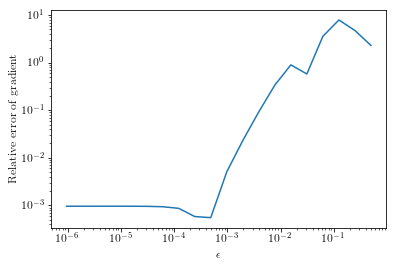

In [9]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

plt.loglog(eps_array,error_array)
#plt.ylim([8.e-5,0.2e-3])
plt.xlabel(r'$\epsilon$')
plt.ylabel('Relative error of gradient')
plt.savefig('gradient.eps',dpi = 300,format = 'eps')
plt.show()

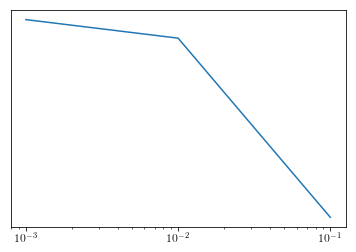

eta= 0.1 mag of gradJ =  7.05024245335e-06 mag d =  2.05459660662e-05 J= 0.000673730205791 incompressible? True mean enstrophy 1.0


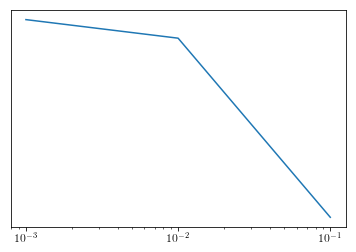

eta= 0.1 mag of gradJ =  6.81151081847e-06 mag d =  1.97480487518e-05 J= 0.000673730201597 incompressible? True mean enstrophy 1.0


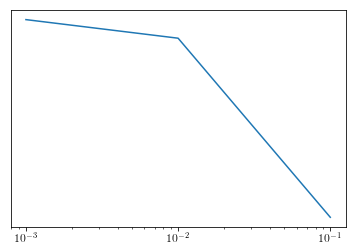

eta= 0.1 mag of gradJ =  6.58113993133e-06 mag d =  1.89828664542e-05 J= 0.000673730197843 incompressible? True mean enstrophy 1.0


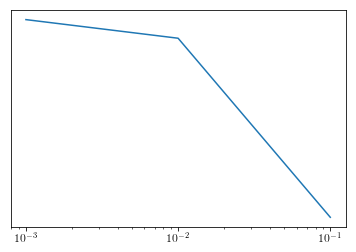

eta= 0.1 mag of gradJ =  6.35882655096e-06 mag d =  1.82490239874e-05 J= 0.000673730194493 incompressible? True mean enstrophy 1.0


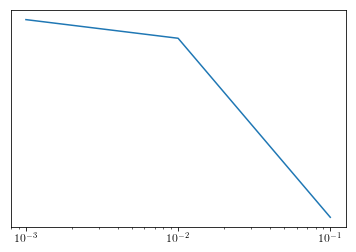

eta= 0.1 mag of gradJ =  6.14427879096e-06 mag d =  1.75451871695e-05 J= 0.000673730191513 incompressible? True mean enstrophy 1.0


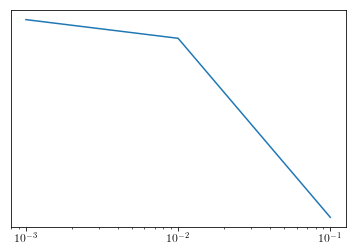

eta= 0.1 mag of gradJ =  5.93721568366e-06 mag d =  1.68700800953e-05 J= 0.000673730188873 incompressible? True mean enstrophy 1.0


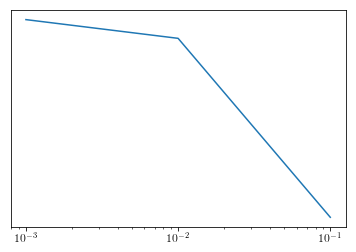

eta= 0.1 mag of gradJ =  5.73736676125e-06 mag d =  1.62224825322e-05 J= 0.000673730186544 incompressible? True mean enstrophy 1.0


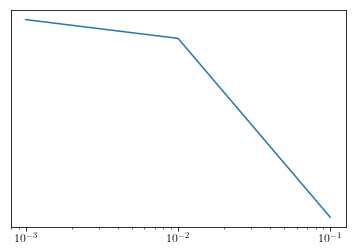

eta= 0.1 mag of gradJ =  5.54447165337e-06 mag d =  1.56012274362e-05 J= 0.0006737301845 incompressible? True mean enstrophy 1.0


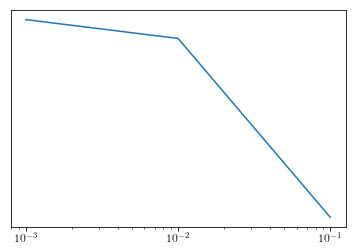

eta= 0.1 mag of gradJ =  5.35827970021e-06 mag d =  1.50051985839e-05 J= 0.000673730182716 incompressible? True mean enstrophy 1.0


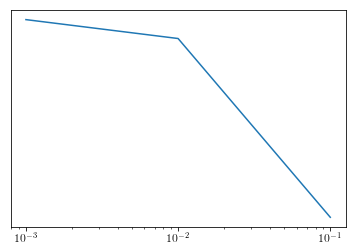

eta= 0.1 mag of gradJ =  5.17854958084e-06 mag d =  1.44333283108e-05 J= 0.00067373018117 incompressible? True mean enstrophy 1.0


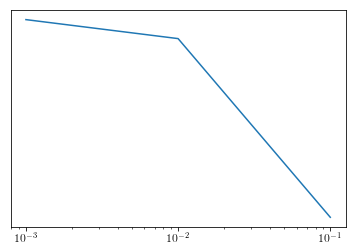

eta= 0.1 mag of gradJ =  5.00504895601e-06 mag d =  1.38845953525e-05 J= 0.000673730179842 incompressible? True mean enstrophy 1.0


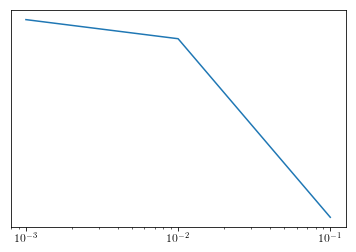

eta= 0.1 mag of gradJ =  4.83755412472e-06 mag d =  1.33580227877e-05 J= 0.000673730178713 incompressible? True mean enstrophy 1.0


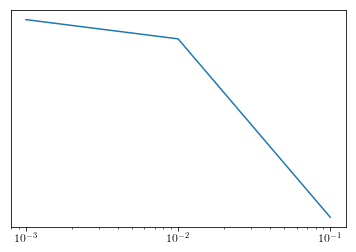

eta= 0.1 mag of gradJ =  4.67584969438e-06 mag d =  1.28526760709e-05 J= 0.000673730177764 incompressible? True mean enstrophy 1.0


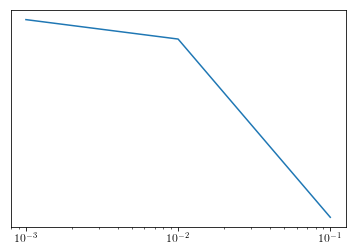

eta= 0.1 mag of gradJ =  4.51972826357e-06 mag d =  1.2367661157e-05 J= 0.000673730176981 incompressible? True mean enstrophy 1.0


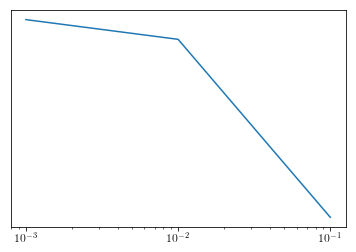

eta= 0.1 mag of gradJ =  4.3689901173e-06 mag d =  1.19021227103e-05 J= 0.000673730176348 incompressible? True mean enstrophy 1.0


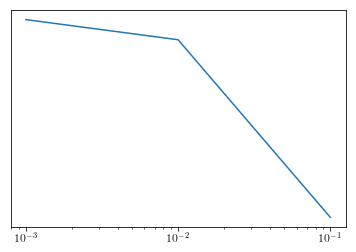

eta= 0.1 mag of gradJ =  4.22344293404e-06 mag d =  1.14552423943e-05 J= 0.000673730175851 incompressible? True mean enstrophy 1.0


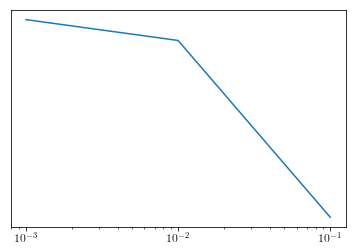

eta= 0.1 mag of gradJ =  4.08290150414e-06 mag d =  1.102623724e-05 J= 0.000673730175478 incompressible? True mean enstrophy 1.0


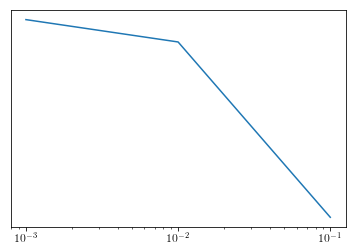

eta= 0.1 mag of gradJ =  3.94718745919e-06 mag d =  1.06143580863e-05 J= 0.000673730175217 incompressible? True mean enstrophy 1.0


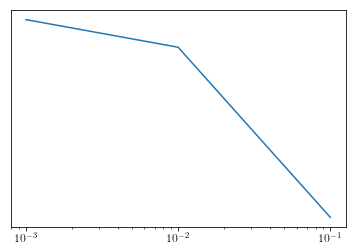

eta= 0.1 mag of gradJ =  3.81612901189e-06 mag d =  1.02188880919e-05 J= 0.000673730175058 incompressible? True mean enstrophy 1.0


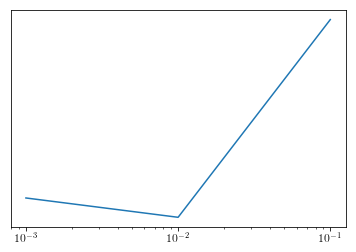

eta= 0.01 mag of gradJ =  3.689560706e-06 mag d =  9.83914131374e-06 J= 0.00067373017499 incompressible? True mean enstrophy 1.0


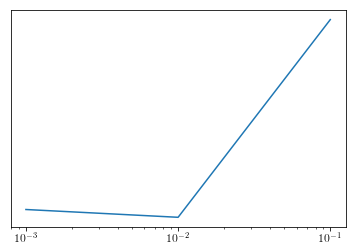

eta= 0.01 mag of gradJ =  3.67733401428e-06 mag d =  9.80264624638e-06 J= 0.000673730174988 incompressible? True mean enstrophy 1.0


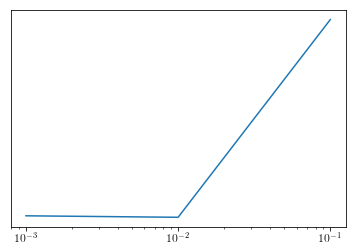

eta= 0.01 mag of gradJ =  3.66514912425e-06 mag d =  9.76629573282e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


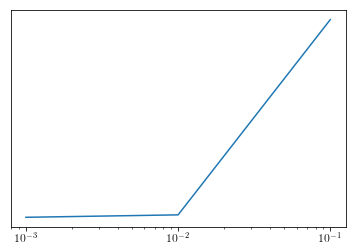

eta= 0.001 mag of gradJ =  3.65300588762e-06 mag d =  9.73008917265e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


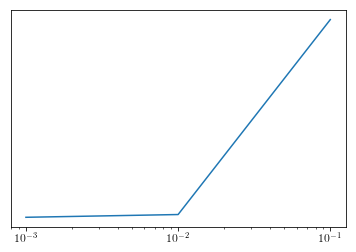

eta= 0.001 mag of gradJ =  3.65179568646e-06 mag d =  9.72648259412e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


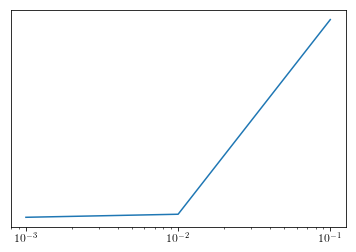

eta= 0.001 mag of gradJ =  3.65058589892e-06 mag d =  9.7228774434e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


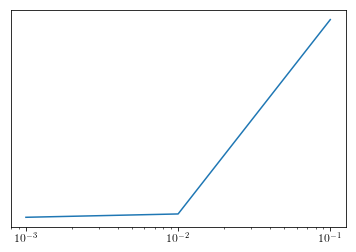

eta= 0.001 mag of gradJ =  3.64937652484e-06 mag d =  9.71927371976e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


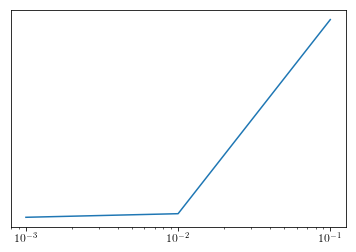

eta= 0.001 mag of gradJ =  3.64816756408e-06 mag d =  9.71567142273e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


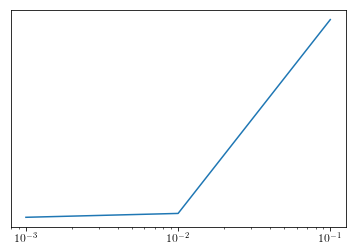

eta= 0.001 mag of gradJ =  3.6469590165e-06 mag d =  9.71207055153e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


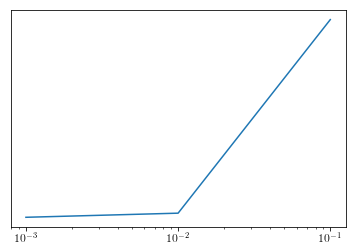

eta= 0.001 mag of gradJ =  3.64575088194e-06 mag d =  9.70847110597e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


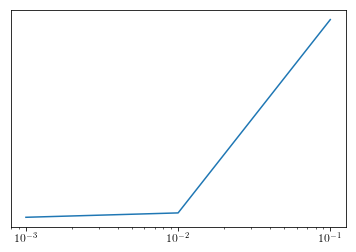

eta= 0.001 mag of gradJ =  3.64454316026e-06 mag d =  9.70487308516e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


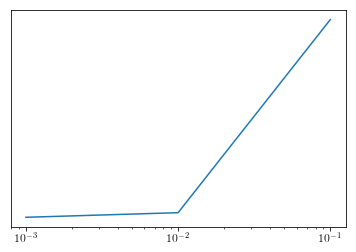

eta= 0.001 mag of gradJ =  3.64333585132e-06 mag d =  9.70127648855e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


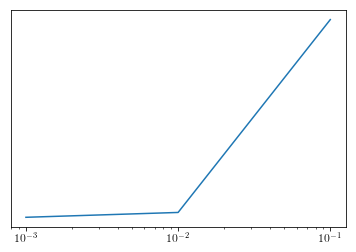

eta= 0.001 mag of gradJ =  3.64212895496e-06 mag d =  9.6976813155e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


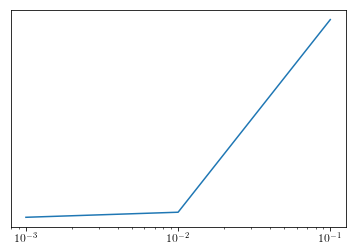

eta= 0.001 mag of gradJ =  3.64092247104e-06 mag d =  9.69408756545e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


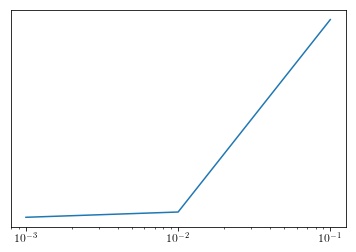

eta= 0.001 mag of gradJ =  3.63971639943e-06 mag d =  9.69049523786e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


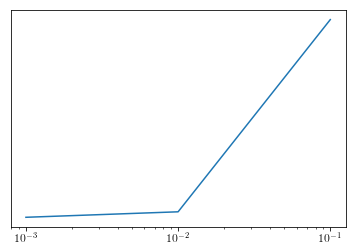

eta= 0.001 mag of gradJ =  3.63851073996e-06 mag d =  9.68690433208e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


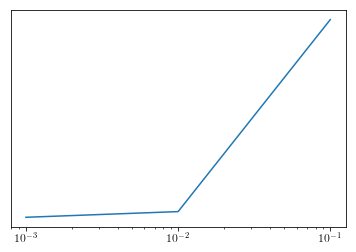

eta= 0.001 mag of gradJ =  3.63730549249e-06 mag d =  9.68331484758e-06 J= 0.000673730174987 incompressible? True mean enstrophy 1.0


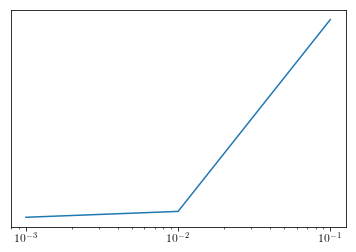

eta= 0.001 mag of gradJ =  3.63610065689e-06 mag d =  9.67972678384e-06 J= 0.000673730174988 incompressible? True mean enstrophy 1.0


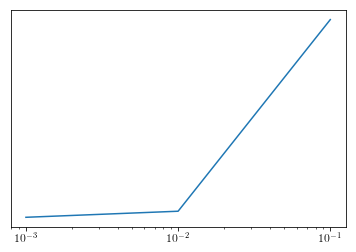

eta= 0.001 mag of gradJ =  3.63489623298e-06 mag d =  9.67614014005e-06 J= 0.000673730174988 incompressible? True mean enstrophy 1.0


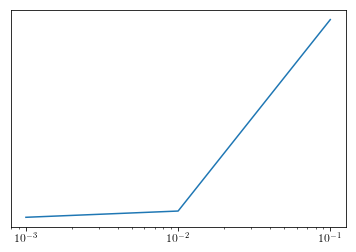

eta= 0.001 mag of gradJ =  3.63369222066e-06 mag d =  9.67255491566e-06 J= 0.000673730174988 incompressible? True mean enstrophy 1.0


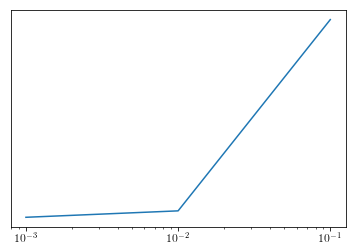

eta= 0.001 mag of gradJ =  3.63248861974e-06 mag d =  9.66897111029e-06 J= 0.000673730174988 incompressible? True mean enstrophy 1.0


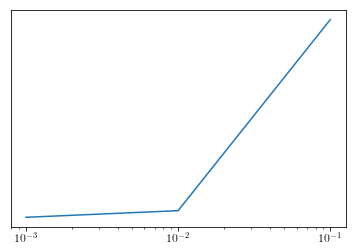

eta= 0.001 mag of gradJ =  3.6312854301e-06 mag d =  9.66538872312e-06 J= 0.000673730174988 incompressible? True mean enstrophy 1.0


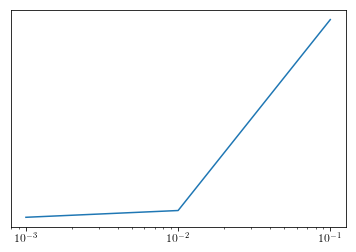

eta= 0.001 mag of gradJ =  3.63008265159e-06 mag d =  9.66180775401e-06 J= 0.000673730174988 incompressible? True mean enstrophy 1.0


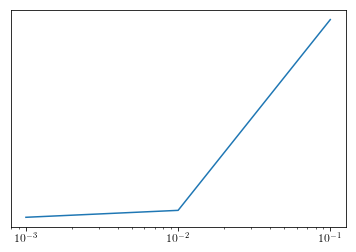

eta= 0.001 mag of gradJ =  3.62888028406e-06 mag d =  9.65822820168e-06 J= 0.000673730174988 incompressible? True mean enstrophy 1.0


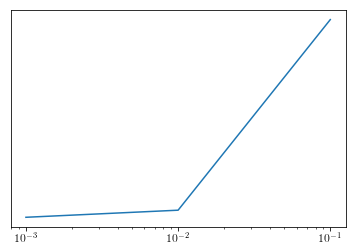

eta= 0.001 mag of gradJ =  3.62767832737e-06 mag d =  9.65465006571e-06 J= 0.000673730174989 incompressible? True mean enstrophy 1.0


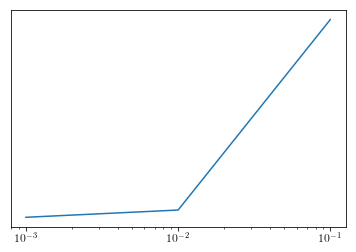

eta= 0.001 mag of gradJ =  3.62647678136e-06 mag d =  9.65107334618e-06 J= 0.000673730174989 incompressible? True mean enstrophy 1.0


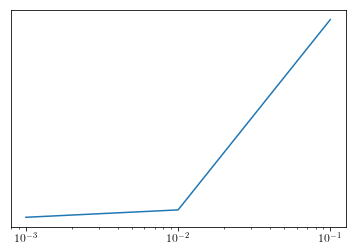

eta= 0.001 mag of gradJ =  3.62527564591e-06 mag d =  9.64749804157e-06 J= 0.000673730174989 incompressible? True mean enstrophy 1.0


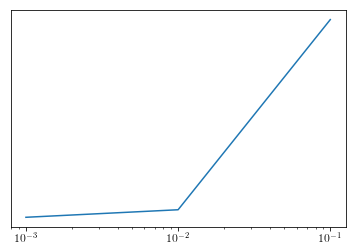

eta= 0.001 mag of gradJ =  3.62407492085e-06 mag d =  9.64392415193e-06 J= 0.000673730174989 incompressible? True mean enstrophy 1.0


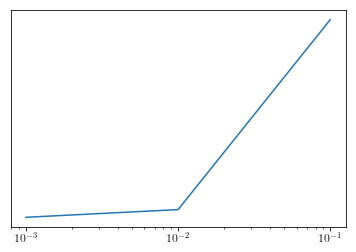

eta= 0.001 mag of gradJ =  3.62287460605e-06 mag d =  9.64035167646e-06 J= 0.000673730174989 incompressible? True mean enstrophy 1.0


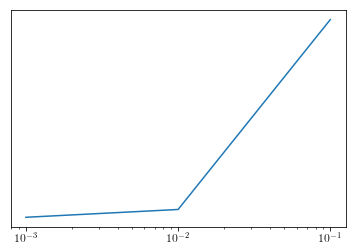

eta= 0.001 mag of gradJ =  3.62167470136e-06 mag d =  9.63678061456e-06 J= 0.00067373017499 incompressible? True mean enstrophy 1.0


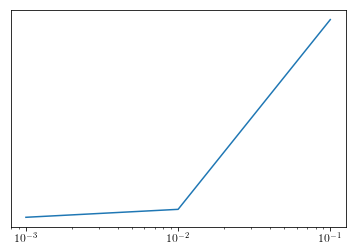

eta= 0.001 mag of gradJ =  3.62047520663e-06 mag d =  9.63321096574e-06 J= 0.00067373017499 incompressible? True mean enstrophy 1.0


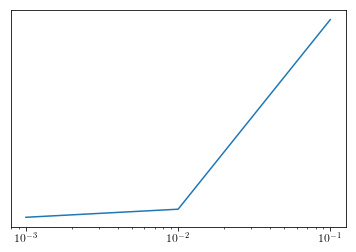

eta= 0.001 mag of gradJ =  3.61927612172e-06 mag d =  9.62964272929e-06 J= 0.00067373017499 incompressible? True mean enstrophy 1.0


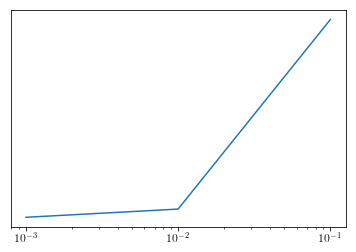

eta= 0.001 mag of gradJ =  3.61807744648e-06 mag d =  9.62607590469e-06 J= 0.00067373017499 incompressible? True mean enstrophy 1.0


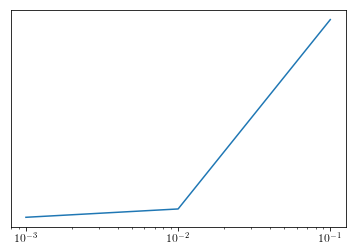

eta= 0.001 mag of gradJ =  3.61687918077e-06 mag d =  9.62251049141e-06 J= 0.00067373017499 incompressible? True mean enstrophy 1.0


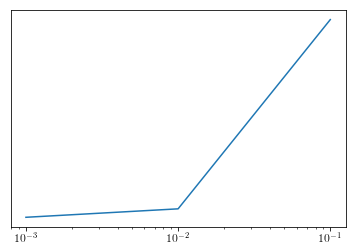

eta= 0.001 mag of gradJ =  3.61568132445e-06 mag d =  9.61894648864e-06 J= 0.000673730174991 incompressible? True mean enstrophy 1.0


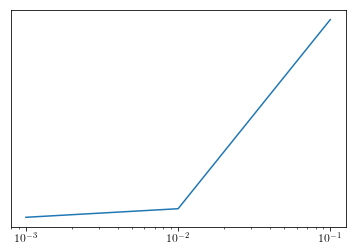

eta= 0.001 mag of gradJ =  3.61448387736e-06 mag d =  9.61538389597e-06 J= 0.000673730174991 incompressible? True mean enstrophy 1.0


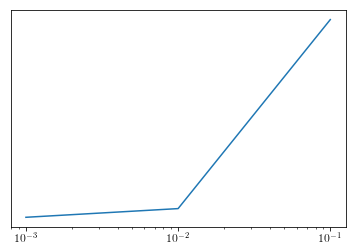

eta= 0.001 mag of gradJ =  3.61328683936e-06 mag d =  9.61182271276e-06 J= 0.000673730174991 incompressible? True mean enstrophy 1.0


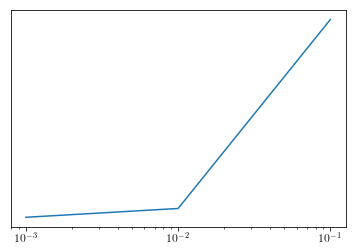

eta= 0.001 mag of gradJ =  3.61209021032e-06 mag d =  9.60826293857e-06 J= 0.000673730174991 incompressible? True mean enstrophy 1.0


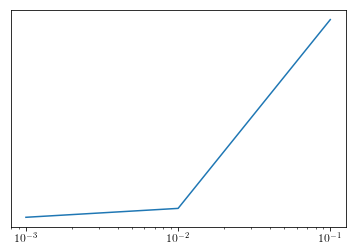

eta= 0.001 mag of gradJ =  3.61089399007e-06 mag d =  9.60470457263e-06 J= 0.000673730174992 incompressible? True mean enstrophy 1.0


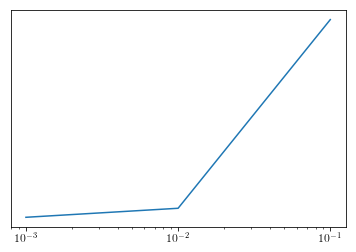

eta= 0.001 mag of gradJ =  3.60969817849e-06 mag d =  9.6011476143e-06 J= 0.000673730174992 incompressible? True mean enstrophy 1.0


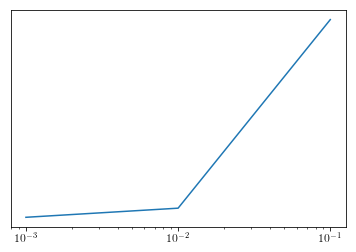

eta= 0.001 mag of gradJ =  3.60850277541e-06 mag d =  9.59759206331e-06 J= 0.000673730174992 incompressible? True mean enstrophy 1.0


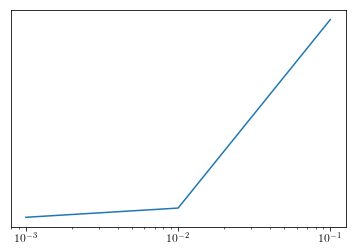

eta= 0.001 mag of gradJ =  3.60730778071e-06 mag d =  9.59403791889e-06 J= 0.000673730174993 incompressible? True mean enstrophy 1.0


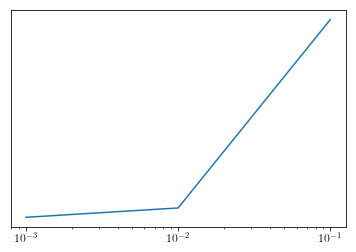

eta= 0.001 mag of gradJ =  3.60611319424e-06 mag d =  9.59048518037e-06 J= 0.000673730174993 incompressible? True mean enstrophy 1.0


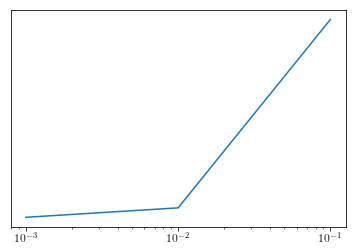

eta= 0.001 mag of gradJ =  3.60491901583e-06 mag d =  9.58693384741e-06 J= 0.000673730174993 incompressible? True mean enstrophy 1.0


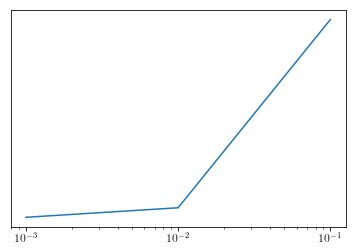

eta= 0.001 mag of gradJ =  3.60372524537e-06 mag d =  9.5833839191e-06 J= 0.000673730174994 incompressible? True mean enstrophy 1.0


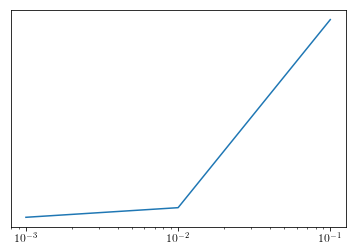

eta= 0.001 mag of gradJ =  3.6025318827e-06 mag d =  9.57983539487e-06 J= 0.000673730174994 incompressible? True mean enstrophy 1.0


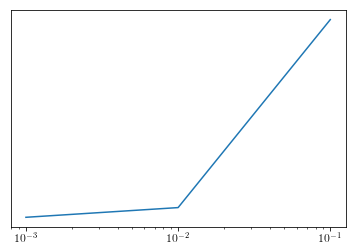

eta= 0.001 mag of gradJ =  3.60133892767e-06 mag d =  9.57628827468e-06 J= 0.000673730174994 incompressible? True mean enstrophy 1.0


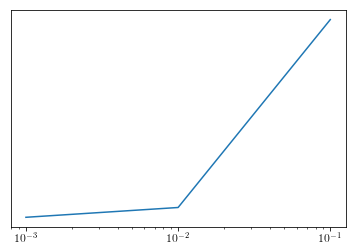

eta= 0.001 mag of gradJ =  3.60014638015e-06 mag d =  9.57274255705e-06 J= 0.000673730174995 incompressible? True mean enstrophy 1.0


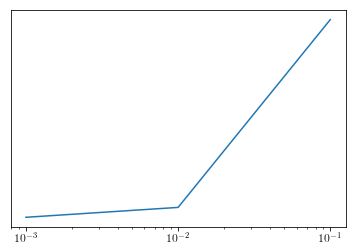

eta= 0.001 mag of gradJ =  3.59895423998e-06 mag d =  9.56919824222e-06 J= 0.000673730174995 incompressible? True mean enstrophy 1.0


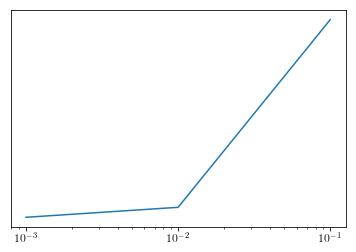

eta= 0.001 mag of gradJ =  3.59776250702e-06 mag d =  9.56565532933e-06 J= 0.000673730174995 incompressible? True mean enstrophy 1.0


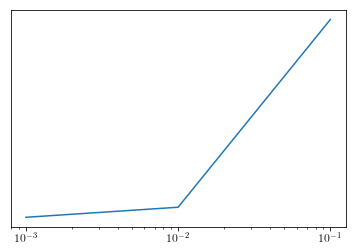

eta= 0.001 mag of gradJ =  3.59657118114e-06 mag d =  9.56211381752e-06 J= 0.000673730174996 incompressible? True mean enstrophy 1.0


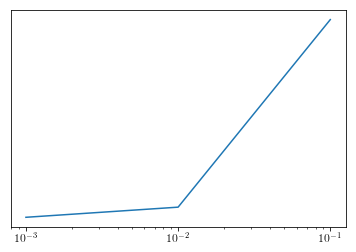

eta= 0.001 mag of gradJ =  3.59538026218e-06 mag d =  9.55857370667e-06 J= 0.000673730174996 incompressible? True mean enstrophy 1.0


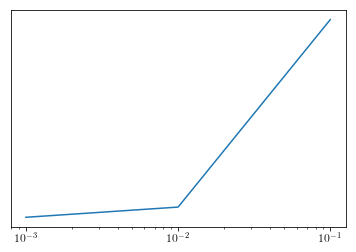

eta= 0.001 mag of gradJ =  3.59418975e-06 mag d =  9.55503499573e-06 J= 0.000673730174996 incompressible? True mean enstrophy 1.0


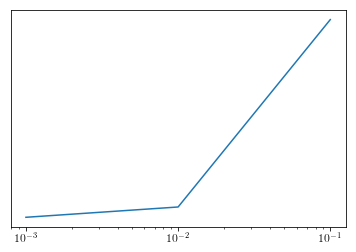

eta= 0.001 mag of gradJ =  3.59299964446e-06 mag d =  9.55149768444e-06 J= 0.000673730174997 incompressible? True mean enstrophy 1.0


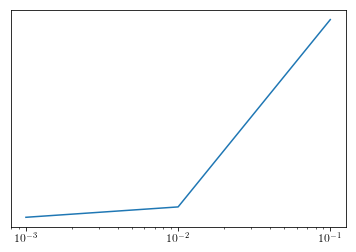

eta= 0.001 mag of gradJ =  3.5918099454e-06 mag d =  9.54796177231e-06 J= 0.000673730174997 incompressible? True mean enstrophy 1.0


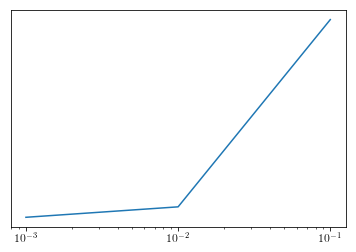

eta= 0.001 mag of gradJ =  3.5906206527e-06 mag d =  9.54442725857e-06 J= 0.000673730174998 incompressible? True mean enstrophy 1.0


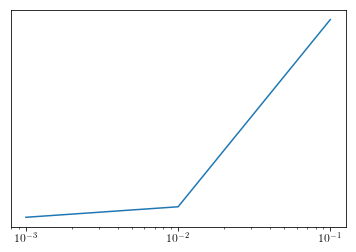

eta= 0.001 mag of gradJ =  3.5894317662e-06 mag d =  9.54089414253e-06 J= 0.000673730174998 incompressible? True mean enstrophy 1.0


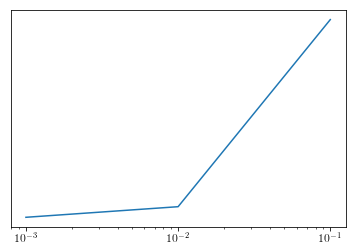

eta= 0.001 mag of gradJ =  3.58824328577e-06 mag d =  9.53736242362e-06 J= 0.000673730174998 incompressible? True mean enstrophy 1.0


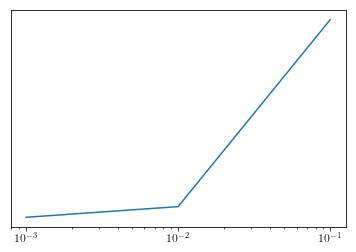

eta= 0.001 mag of gradJ =  3.58705521124e-06 mag d =  9.53383210156e-06 J= 0.000673730174999 incompressible? True mean enstrophy 1.0


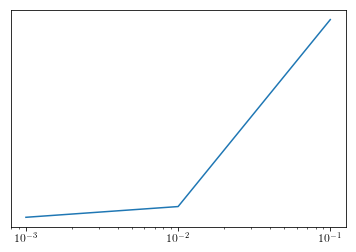

eta= 0.001 mag of gradJ =  3.5858675425e-06 mag d =  9.53030317552e-06 J= 0.000673730174999 incompressible? True mean enstrophy 1.0


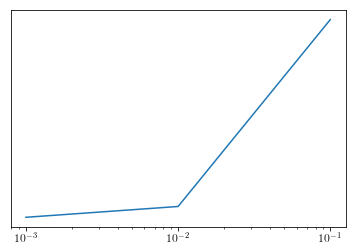

eta= 0.001 mag of gradJ =  3.58468027937e-06 mag d =  9.52677564509e-06 J= 0.000673730175 incompressible? True mean enstrophy 1.0


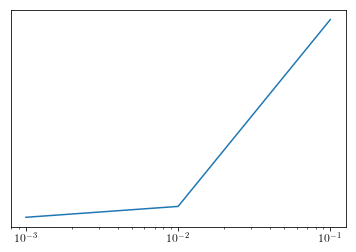

eta= 0.001 mag of gradJ =  3.58349342174e-06 mag d =  9.52324950957e-06 J= 0.000673730175 incompressible? True mean enstrophy 1.0


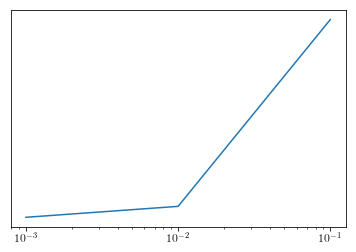

eta= 0.001 mag of gradJ =  3.58230696946e-06 mag d =  9.51972476825e-06 J= 0.000673730175001 incompressible? True mean enstrophy 1.0


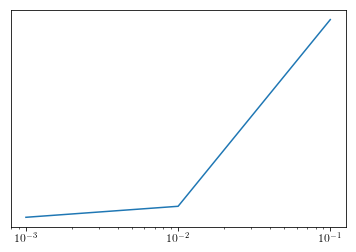

eta= 0.001 mag of gradJ =  3.58112092237e-06 mag d =  9.51620142051e-06 J= 0.000673730175001 incompressible? True mean enstrophy 1.0


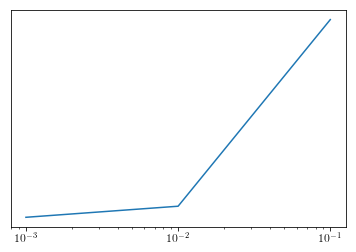

eta= 0.001 mag of gradJ =  3.57993528033e-06 mag d =  9.51267946618e-06 J= 0.000673730175001 incompressible? True mean enstrophy 1.0


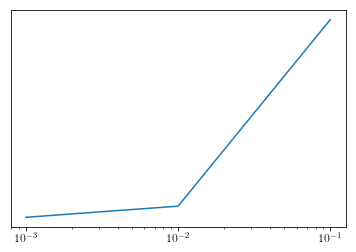

eta= 0.001 mag of gradJ =  3.57875004321e-06 mag d =  9.5091589047e-06 J= 0.000673730175002 incompressible? True mean enstrophy 1.0


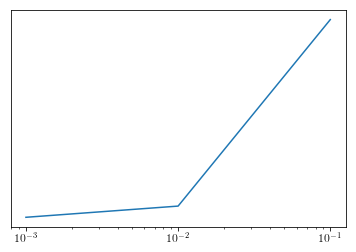

eta= 0.001 mag of gradJ =  3.57756521085e-06 mag d =  9.50563973488e-06 J= 0.000673730175002 incompressible? True mean enstrophy 1.0


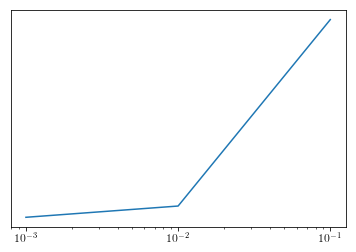

eta= 0.001 mag of gradJ =  3.57638078312e-06 mag d =  9.50212195671e-06 J= 0.000673730175003 incompressible? True mean enstrophy 1.0


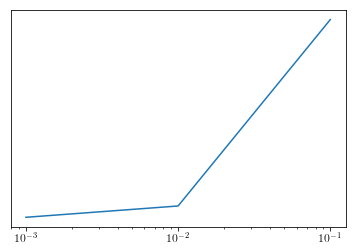

eta= 0.001 mag of gradJ =  3.57519675988e-06 mag d =  9.49860556926e-06 J= 0.000673730175003 incompressible? True mean enstrophy 1.0


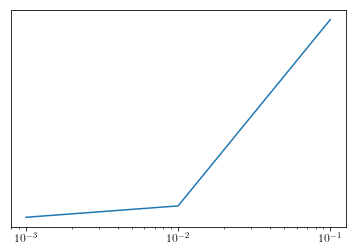

eta= 0.001 mag of gradJ =  3.57401314097e-06 mag d =  9.495090572e-06 J= 0.000673730175004 incompressible? True mean enstrophy 1.0


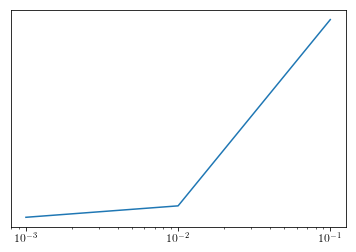

eta= 0.001 mag of gradJ =  3.57282992626e-06 mag d =  9.49157696476e-06 J= 0.000673730175004 incompressible? True mean enstrophy 1.0


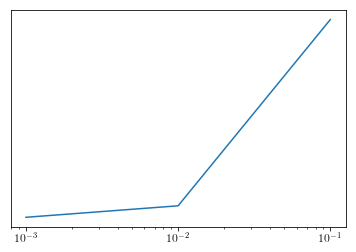

eta= 0.001 mag of gradJ =  3.57164711559e-06 mag d =  9.48806474672e-06 J= 0.000673730175005 incompressible? True mean enstrophy 1.0


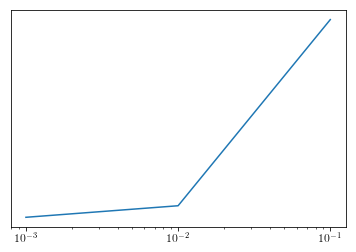

eta= 0.001 mag of gradJ =  3.57046470884e-06 mag d =  9.48455391699e-06 J= 0.000673730175005 incompressible? True mean enstrophy 1.0


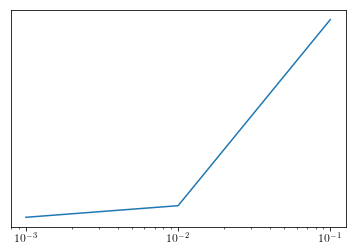

eta= 0.001 mag of gradJ =  3.56928270586e-06 mag d =  9.48104447529e-06 J= 0.000673730175006 incompressible? True mean enstrophy 1.0


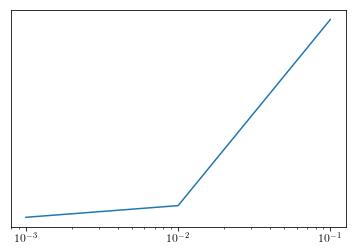

eta= 0.001 mag of gradJ =  3.5681011065e-06 mag d =  9.47753642094e-06 J= 0.000673730175006 incompressible? True mean enstrophy 1.0


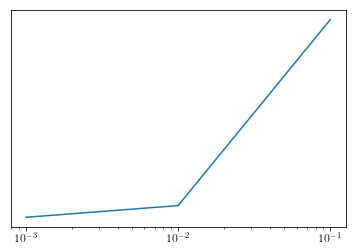

eta= 0.001 mag of gradJ =  3.56691991062e-06 mag d =  9.47402975352e-06 J= 0.000673730175007 incompressible? True mean enstrophy 1.0


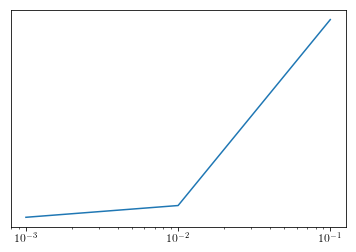

eta= 0.001 mag of gradJ =  3.56573911807e-06 mag d =  9.47052447246e-06 J= 0.000673730175008 incompressible? True mean enstrophy 1.0


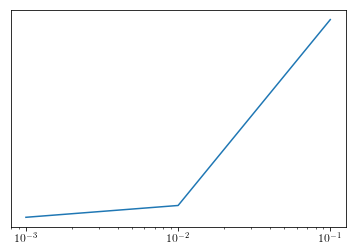

eta= 0.001 mag of gradJ =  3.56455872873e-06 mag d =  9.46702057678e-06 J= 0.000673730175008 incompressible? True mean enstrophy 1.0


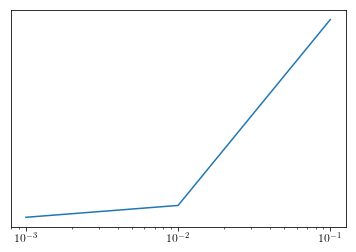

eta= 0.001 mag of gradJ =  3.56337874243e-06 mag d =  9.46351806634e-06 J= 0.000673730175009 incompressible? True mean enstrophy 1.0


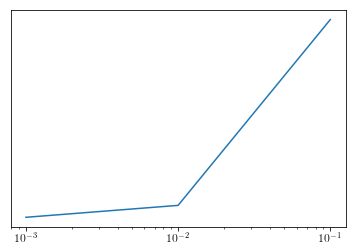

eta= 0.001 mag of gradJ =  3.56219915905e-06 mag d =  9.46001694042e-06 J= 0.000673730175009 incompressible? True mean enstrophy 1.0


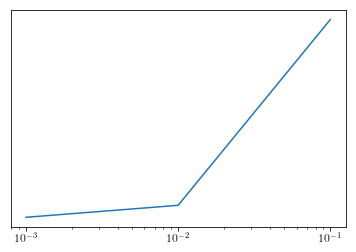

eta= 0.001 mag of gradJ =  3.56101997843e-06 mag d =  9.45651719858e-06 J= 0.00067373017501 incompressible? True mean enstrophy 1.0


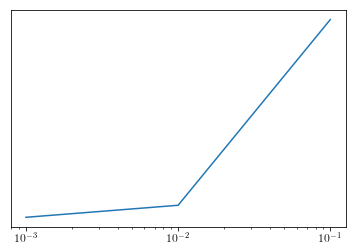

eta= 0.001 mag of gradJ =  3.55984120043e-06 mag d =  9.45301884018e-06 J= 0.00067373017501 incompressible? True mean enstrophy 1.0


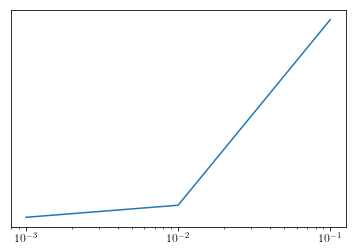

eta= 0.001 mag of gradJ =  3.55866282493e-06 mag d =  9.44952186424e-06 J= 0.000673730175011 incompressible? True mean enstrophy 1.0


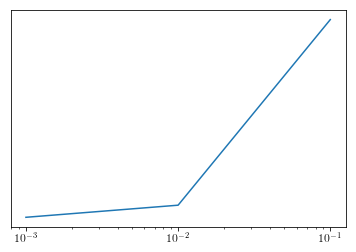

eta= 0.001 mag of gradJ =  3.55748485176e-06 mag d =  9.44602627065e-06 J= 0.000673730175012 incompressible? True mean enstrophy 1.0


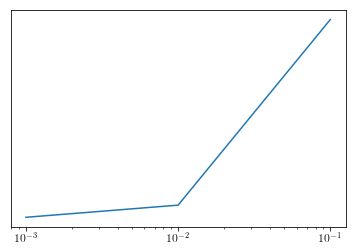

eta= 0.001 mag of gradJ =  3.55630728077e-06 mag d =  9.44253205902e-06 J= 0.000673730175012 incompressible? True mean enstrophy 1.0


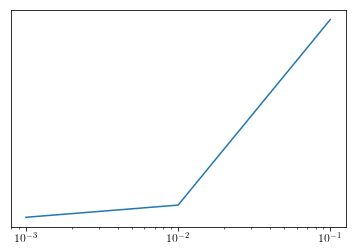

eta= 0.001 mag of gradJ =  3.55513011185e-06 mag d =  9.43903922814e-06 J= 0.000673730175013 incompressible? True mean enstrophy 1.0


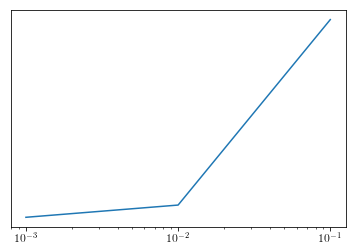

eta= 0.001 mag of gradJ =  3.55395334484e-06 mag d =  9.43554777785e-06 J= 0.000673730175013 incompressible? True mean enstrophy 1.0


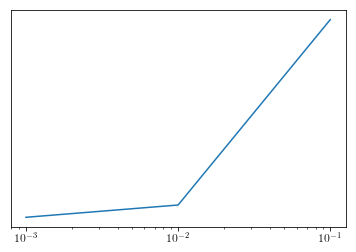

eta= 0.001 mag of gradJ =  3.55277697961e-06 mag d =  9.43205770734e-06 J= 0.000673730175014 incompressible? True mean enstrophy 1.0


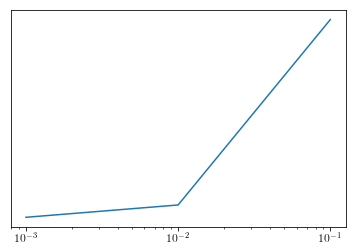

eta= 0.001 mag of gradJ =  3.551601016e-06 mag d =  9.42856901645e-06 J= 0.000673730175015 incompressible? True mean enstrophy 1.0


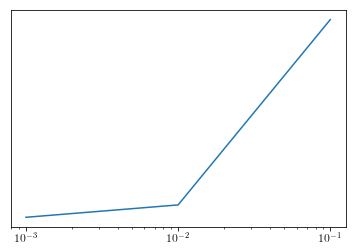

eta= 0.001 mag of gradJ =  3.55042545388e-06 mag d =  9.42508170407e-06 J= 0.000673730175015 incompressible? True mean enstrophy 1.0


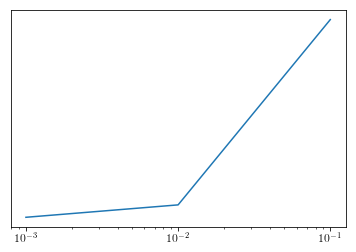

eta= 0.001 mag of gradJ =  3.54925029309e-06 mag d =  9.42159577022e-06 J= 0.000673730175016 incompressible? True mean enstrophy 1.0


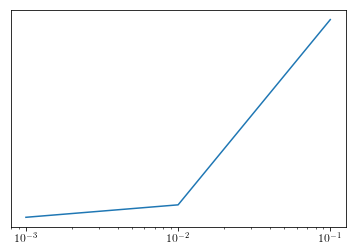

eta= 0.001 mag of gradJ =  3.54807553351e-06 mag d =  9.41811121389e-06 J= 0.000673730175017 incompressible? True mean enstrophy 1.0


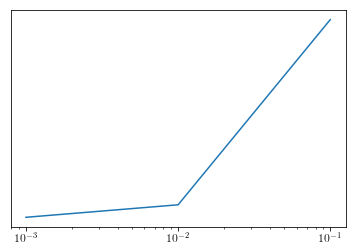

eta= 0.001 mag of gradJ =  3.54690117499e-06 mag d =  9.41462803453e-06 J= 0.000673730175017 incompressible? True mean enstrophy 1.0


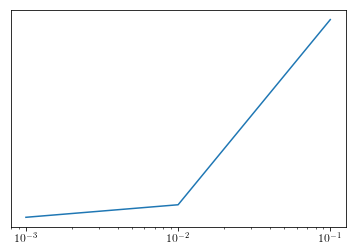

eta= 0.001 mag of gradJ =  3.54572721739e-06 mag d =  9.41114623177e-06 J= 0.000673730175018 incompressible? True mean enstrophy 1.0


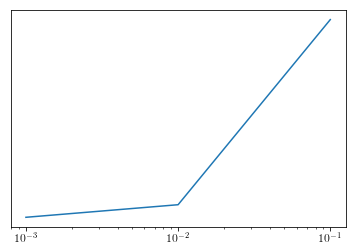

eta= 0.001 mag of gradJ =  3.54455366056e-06 mag d =  9.40766580499e-06 J= 0.000673730175019 incompressible? True mean enstrophy 1.0


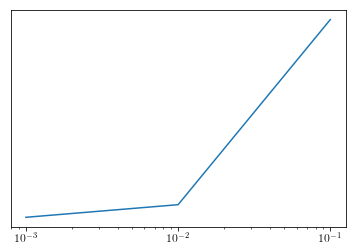

eta= 0.001 mag of gradJ =  3.54338050437e-06 mag d =  9.40418675352e-06 J= 0.000673730175019 incompressible? True mean enstrophy 1.0


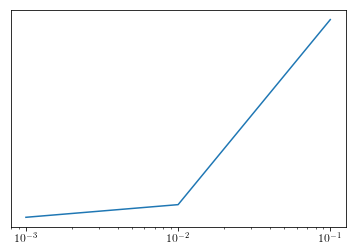

eta= 0.001 mag of gradJ =  3.54220774868e-06 mag d =  9.40070907648e-06 J= 0.00067373017502 incompressible? True mean enstrophy 1.0


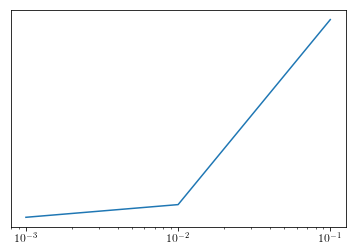

eta= 0.001 mag of gradJ =  3.54103539332e-06 mag d =  9.39723277421e-06 J= 0.000673730175021 incompressible? True mean enstrophy 1.0


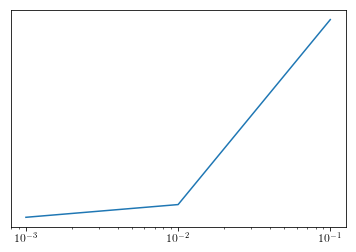

eta= 0.001 mag of gradJ =  3.53986343818e-06 mag d =  9.39375784537e-06 J= 0.000673730175021 incompressible? True mean enstrophy 1.0


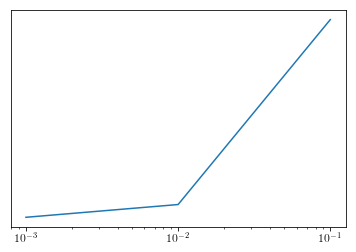

eta= 0.001 mag of gradJ =  3.53869188311e-06 mag d =  9.39028428923e-06 J= 0.000673730175022 incompressible? True mean enstrophy 1.0


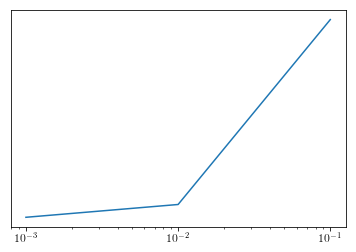

eta= 0.001 mag of gradJ =  3.53752072797e-06 mag d =  9.38681210589e-06 J= 0.000673730175023 incompressible? True mean enstrophy 1.0


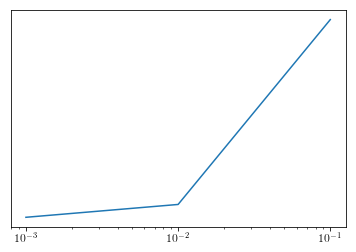

eta= 0.001 mag of gradJ =  3.5363499726e-06 mag d =  9.38334129469e-06 J= 0.000673730175024 incompressible? True mean enstrophy 1.0


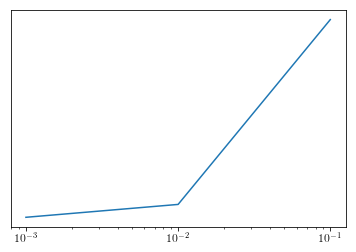

eta= 0.001 mag of gradJ =  3.53517961688e-06 mag d =  9.37987185454e-06 J= 0.000673730175024 incompressible? True mean enstrophy 1.0


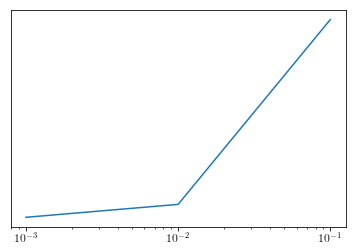

eta= 0.001 mag of gradJ =  3.53400966066e-06 mag d =  9.37640378546e-06 J= 0.000673730175025 incompressible? True mean enstrophy 1.0


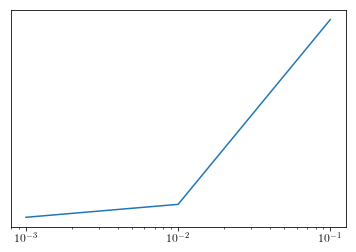

eta= 0.001 mag of gradJ =  3.53284010381e-06 mag d =  9.37293708643e-06 J= 0.000673730175026 incompressible? True mean enstrophy 1.0


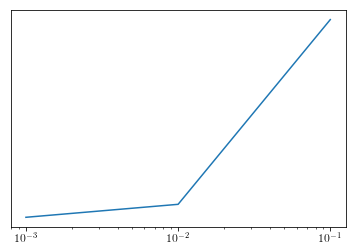

eta= 0.001 mag of gradJ =  3.53167094616e-06 mag d =  9.369471757e-06 J= 0.000673730175027 incompressible? True mean enstrophy 1.0


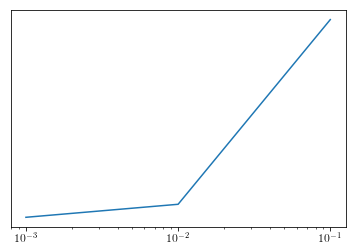

eta= 0.001 mag of gradJ =  3.53050218761e-06 mag d =  9.36600779652e-06 J= 0.000673730175027 incompressible? True mean enstrophy 1.0


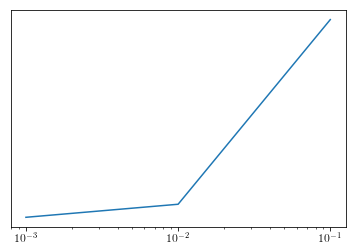

eta= 0.001 mag of gradJ =  3.52933382798e-06 mag d =  9.3625452048e-06 J= 0.000673730175028 incompressible? True mean enstrophy 1.0


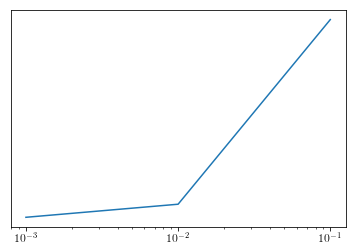

eta= 0.001 mag of gradJ =  3.52816586715e-06 mag d =  9.35908398102e-06 J= 0.000673730175029 incompressible? True mean enstrophy 1.0


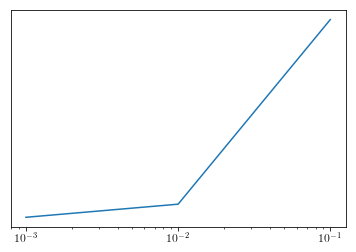

eta= 0.001 mag of gradJ =  3.52699830497e-06 mag d =  9.35562412435e-06 J= 0.00067373017503 incompressible? True mean enstrophy 1.0


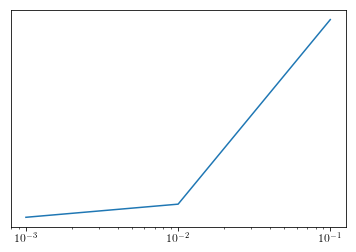

eta= 0.001 mag of gradJ =  3.52583114131e-06 mag d =  9.35216563477e-06 J= 0.00067373017503 incompressible? True mean enstrophy 1.0


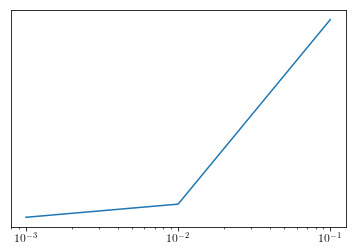

eta= 0.001 mag of gradJ =  3.52466437602e-06 mag d =  9.34870851131e-06 J= 0.000673730175031 incompressible? True mean enstrophy 1.0


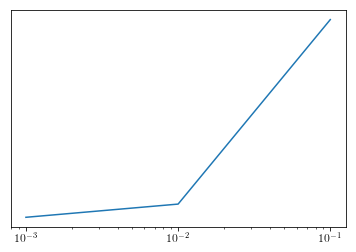

eta= 0.001 mag of gradJ =  3.52349800896e-06 mag d =  9.34525275342e-06 J= 0.000673730175032 incompressible? True mean enstrophy 1.0


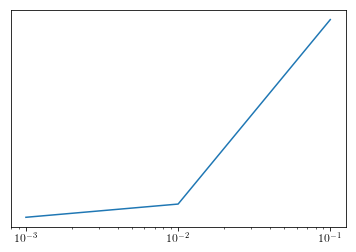

eta= 0.001 mag of gradJ =  3.52233203999e-06 mag d =  9.34179836096e-06 J= 0.000673730175033 incompressible? True mean enstrophy 1.0


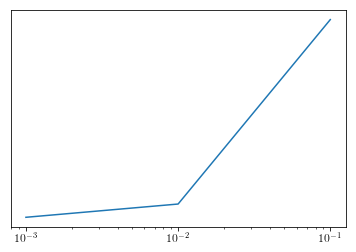

eta= 0.001 mag of gradJ =  3.52116646896e-06 mag d =  9.33834533282e-06 J= 0.000673730175034 incompressible? True mean enstrophy 1.0


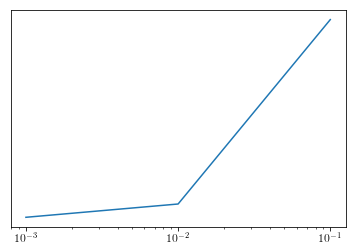

eta= 0.001 mag of gradJ =  3.52000129575e-06 mag d =  9.33489366865e-06 J= 0.000673730175034 incompressible? True mean enstrophy 1.0


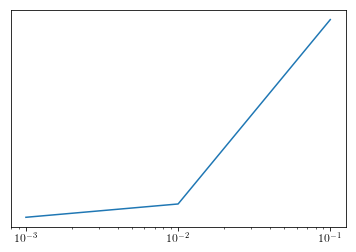

eta= 0.001 mag of gradJ =  3.51883652021e-06 mag d =  9.33144336789e-06 J= 0.000673730175035 incompressible? True mean enstrophy 1.0


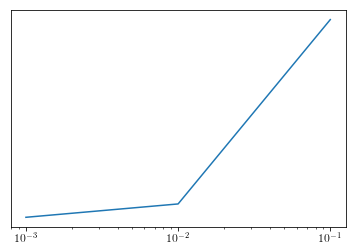

eta= 0.001 mag of gradJ =  3.51767214219e-06 mag d =  9.32799443001e-06 J= 0.000673730175036 incompressible? True mean enstrophy 1.0


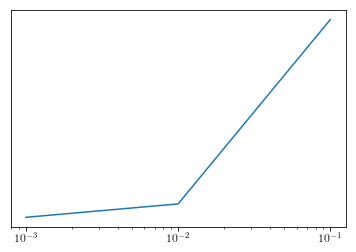

eta= 0.001 mag of gradJ =  3.51650816156e-06 mag d =  9.3245468544e-06 J= 0.000673730175037 incompressible? True mean enstrophy 1.0


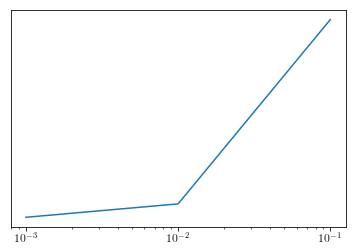

eta= 0.001 mag of gradJ =  3.51534457817e-06 mag d =  9.32110064043e-06 J= 0.000673730175038 incompressible? True mean enstrophy 1.0


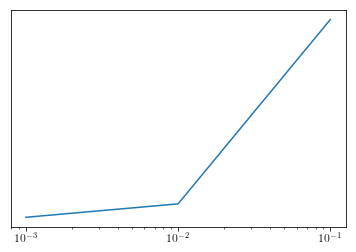

eta= 0.001 mag of gradJ =  3.51418139189e-06 mag d =  9.31765578758e-06 J= 0.000673730175039 incompressible? True mean enstrophy 1.0


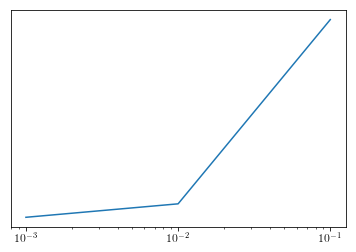

eta= 0.001 mag of gradJ =  3.51301860258e-06 mag d =  9.31421229523e-06 J= 0.00067373017504 incompressible? True mean enstrophy 1.0


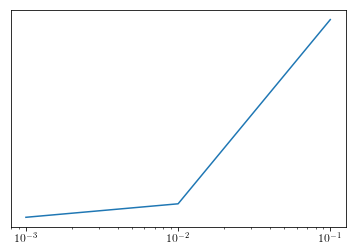

eta= 0.001 mag of gradJ =  3.51185621009e-06 mag d =  9.31077016297e-06 J= 0.00067373017504 incompressible? True mean enstrophy 1.0


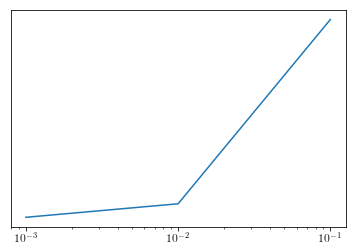

eta= 0.001 mag of gradJ =  3.51069421429e-06 mag d =  9.30732939039e-06 J= 0.000673730175041 incompressible? True mean enstrophy 1.0


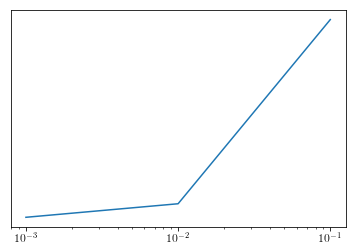

eta= 0.001 mag of gradJ =  3.50953261502e-06 mag d =  9.30388997643e-06 J= 0.000673730175042 incompressible? True mean enstrophy 1.0


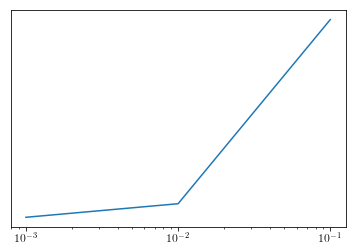

eta= 0.001 mag of gradJ =  3.50837141216e-06 mag d =  9.30045192091e-06 J= 0.000673730175043 incompressible? True mean enstrophy 1.0


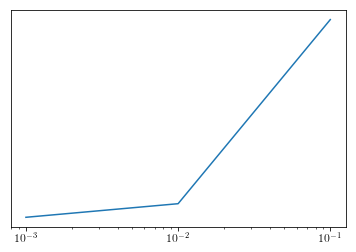

eta= 0.001 mag of gradJ =  3.50721060557e-06 mag d =  9.29701522313e-06 J= 0.000673730175044 incompressible? True mean enstrophy 1.0


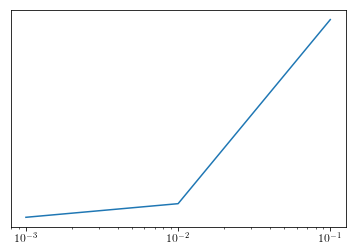

eta= 0.001 mag of gradJ =  3.50605019511e-06 mag d =  9.29357988218e-06 J= 0.000673730175045 incompressible? True mean enstrophy 1.0


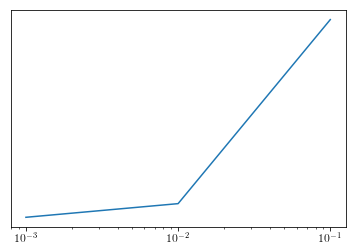

eta= 0.001 mag of gradJ =  3.50489018061e-06 mag d =  9.2901458984e-06 J= 0.000673730175046 incompressible? True mean enstrophy 1.0


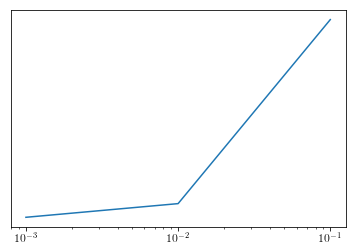

eta= 0.001 mag of gradJ =  3.50373056197e-06 mag d =  9.2867132706e-06 J= 0.000673730175047 incompressible? True mean enstrophy 1.0


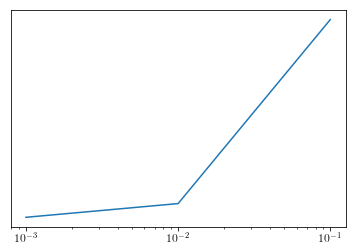

eta= 0.001 mag of gradJ =  3.50257133903e-06 mag d =  9.28328199783e-06 J= 0.000673730175048 incompressible? True mean enstrophy 1.0


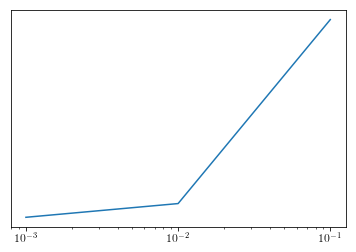

eta= 0.001 mag of gradJ =  3.50141251165e-06 mag d =  9.27985208051e-06 J= 0.000673730175049 incompressible? True mean enstrophy 1.0


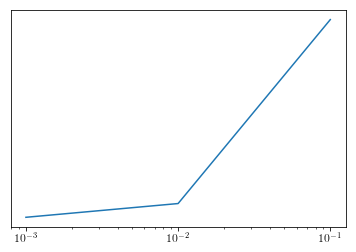

eta= 0.001 mag of gradJ =  3.5002540797e-06 mag d =  9.27642351723e-06 J= 0.00067373017505 incompressible? True mean enstrophy 1.0


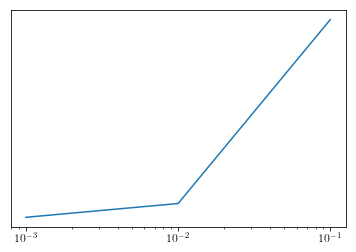

eta= 0.001 mag of gradJ =  3.49909604303e-06 mag d =  9.27299630792e-06 J= 0.00067373017505 incompressible? True mean enstrophy 1.0


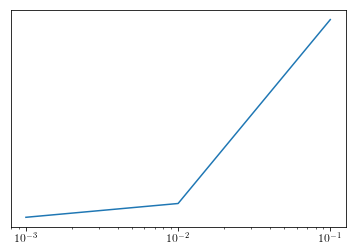

eta= 0.001 mag of gradJ =  3.4979384015e-06 mag d =  9.26957045173e-06 J= 0.000673730175051 incompressible? True mean enstrophy 1.0


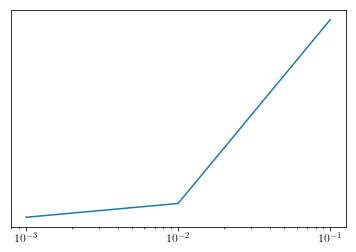

eta= 0.001 mag of gradJ =  3.49678115498e-06 mag d =  9.26614594831e-06 J= 0.000673730175052 incompressible? True mean enstrophy 1.0


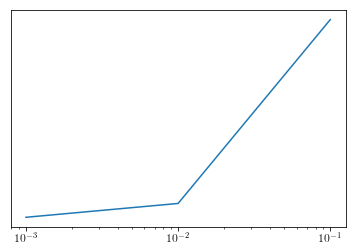

eta= 0.001 mag of gradJ =  3.49562430332e-06 mag d =  9.26272279691e-06 J= 0.000673730175053 incompressible? True mean enstrophy 1.0


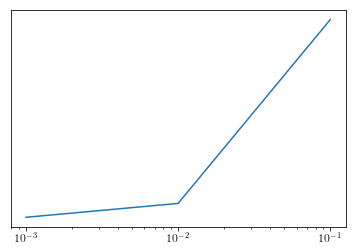

eta= 0.001 mag of gradJ =  3.49446784639e-06 mag d =  9.25930099719e-06 J= 0.000673730175054 incompressible? True mean enstrophy 1.0


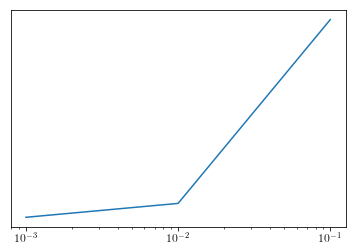

eta= 0.001 mag of gradJ =  3.49331178404e-06 mag d =  9.25588054846e-06 J= 0.000673730175055 incompressible? True mean enstrophy 1.0


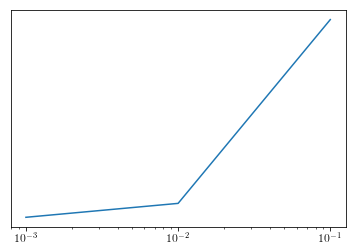

eta= 0.001 mag of gradJ =  3.49215611614e-06 mag d =  9.25246145015e-06 J= 0.000673730175056 incompressible? True mean enstrophy 1.0


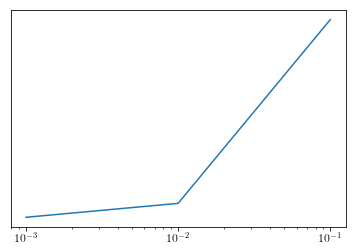

eta= 0.001 mag of gradJ =  3.49100084254e-06 mag d =  9.24904370167e-06 J= 0.000673730175057 incompressible? True mean enstrophy 1.0


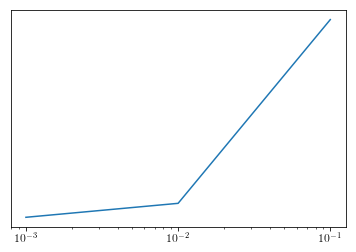

eta= 0.001 mag of gradJ =  3.48984596311e-06 mag d =  9.24562730246e-06 J= 0.000673730175058 incompressible? True mean enstrophy 1.0


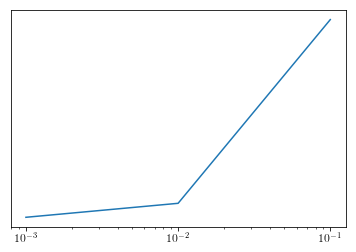

eta= 0.001 mag of gradJ =  3.48869147771e-06 mag d =  9.24221225221e-06 J= 0.000673730175059 incompressible? True mean enstrophy 1.0


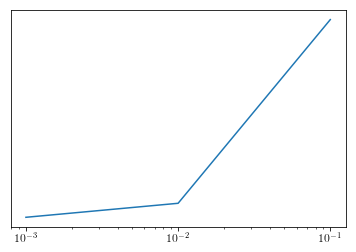

eta= 0.001 mag of gradJ =  3.4875373862e-06 mag d =  9.23879854985e-06 J= 0.00067373017506 incompressible? True mean enstrophy 1.0


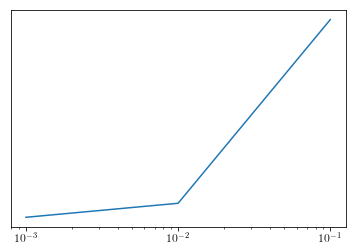

eta= 0.001 mag of gradJ =  3.48638368843e-06 mag d =  9.23538619544e-06 J= 0.000673730175061 incompressible? True mean enstrophy 1.0


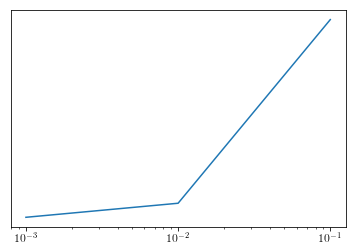

eta= 0.001 mag of gradJ =  3.48523038428e-06 mag d =  9.23197518792e-06 J= 0.000673730175062 incompressible? True mean enstrophy 1.0


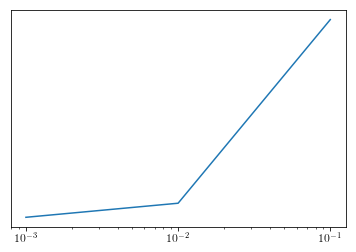

eta= 0.001 mag of gradJ =  3.48407747359e-06 mag d =  9.22856552699e-06 J= 0.000673730175063 incompressible? True mean enstrophy 1.0


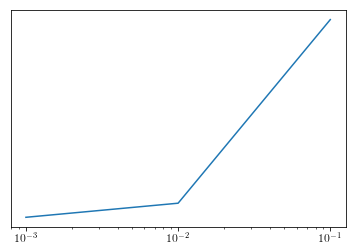

eta= 0.001 mag of gradJ =  3.48292495623e-06 mag d =  9.22515721207e-06 J= 0.000673730175064 incompressible? True mean enstrophy 1.0


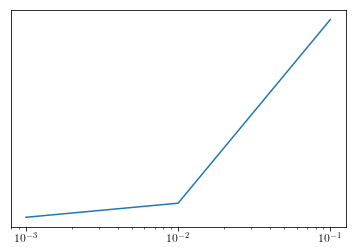

eta= 0.001 mag of gradJ =  3.48177283207e-06 mag d =  9.2217502424e-06 J= 0.000673730175065 incompressible? True mean enstrophy 1.0


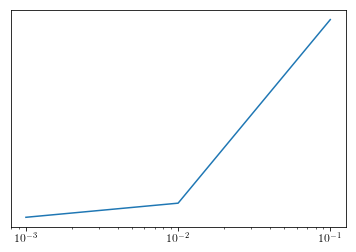

eta= 0.001 mag of gradJ =  3.48062110096e-06 mag d =  9.21834461774e-06 J= 0.000673730175066 incompressible? True mean enstrophy 1.0


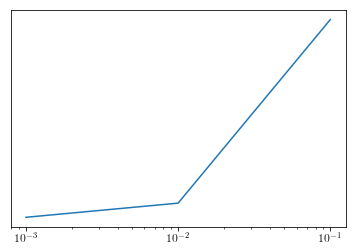

eta= 0.001 mag of gradJ =  3.47946976277e-06 mag d =  9.21494033723e-06 J= 0.000673730175068 incompressible? True mean enstrophy 1.0


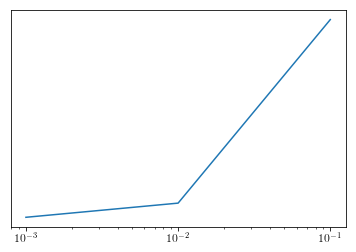

eta= 0.001 mag of gradJ =  3.47831881735e-06 mag d =  9.21153740041e-06 J= 0.000673730175069 incompressible? True mean enstrophy 1.0


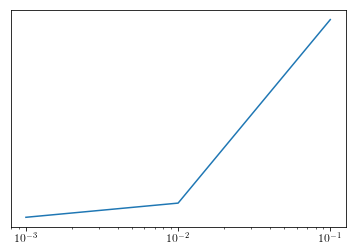

eta= 0.001 mag of gradJ =  3.47716826457e-06 mag d =  9.20813580655e-06 J= 0.00067373017507 incompressible? True mean enstrophy 1.0


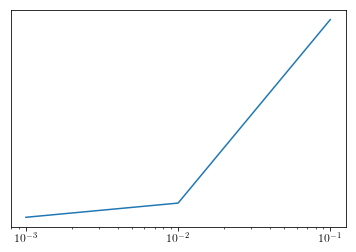

eta= 0.001 mag of gradJ =  3.47601810428e-06 mag d =  9.20473555582e-06 J= 0.000673730175071 incompressible? True mean enstrophy 1.0


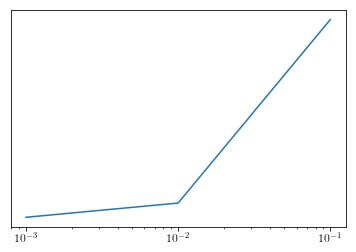

eta= 0.001 mag of gradJ =  3.47486833635e-06 mag d =  9.2013366469e-06 J= 0.000673730175072 incompressible? True mean enstrophy 1.0


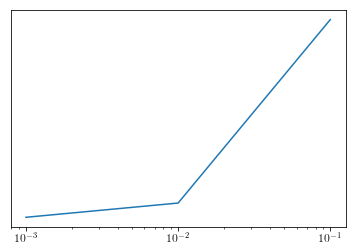

eta= 0.001 mag of gradJ =  3.47371896065e-06 mag d =  9.19793907934e-06 J= 0.000673730175073 incompressible? True mean enstrophy 1.0


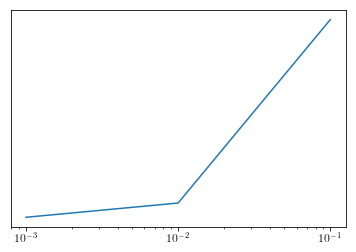

eta= 0.001 mag of gradJ =  3.47256997702e-06 mag d =  9.19454285288e-06 J= 0.000673730175074 incompressible? True mean enstrophy 1.0


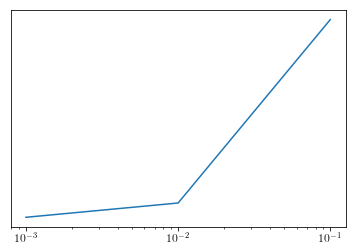

eta= 0.001 mag of gradJ =  3.47142138535e-06 mag d =  9.19114796648e-06 J= 0.000673730175075 incompressible? True mean enstrophy 1.0


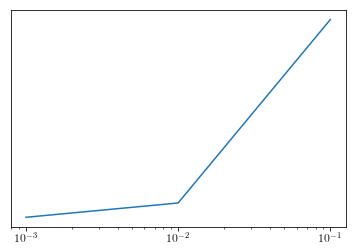

eta= 0.001 mag of gradJ =  3.47027318546e-06 mag d =  9.18775442037e-06 J= 0.000673730175076 incompressible? True mean enstrophy 1.0


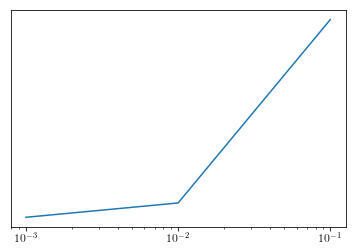

eta= 0.001 mag of gradJ =  3.46912537725e-06 mag d =  9.1843622133e-06 J= 0.000673730175077 incompressible? True mean enstrophy 1.0


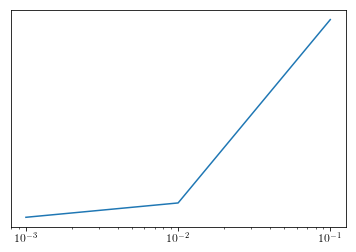

eta= 0.001 mag of gradJ =  3.46797796057e-06 mag d =  9.18097134487e-06 J= 0.000673730175079 incompressible? True mean enstrophy 1.0


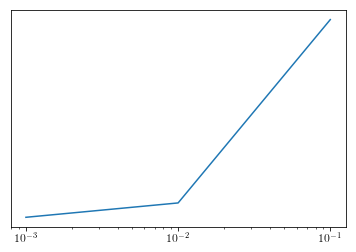

eta= 0.001 mag of gradJ =  3.46683093528e-06 mag d =  9.17758181469e-06 J= 0.00067373017508 incompressible? True mean enstrophy 1.0


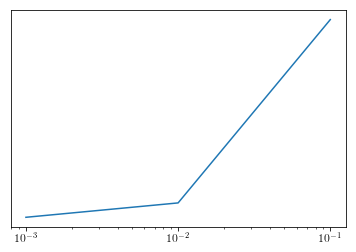

eta= 0.001 mag of gradJ =  3.46568430124e-06 mag d =  9.17419362199e-06 J= 0.000673730175081 incompressible? True mean enstrophy 1.0


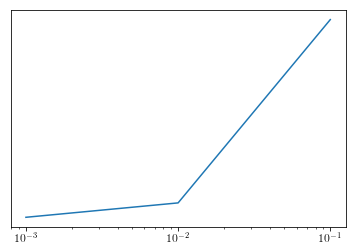

eta= 0.001 mag of gradJ =  3.4645380583e-06 mag d =  9.17080676645e-06 J= 0.000673730175082 incompressible? True mean enstrophy 1.0


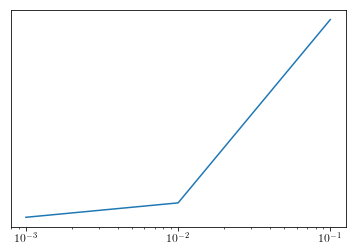

eta= 0.001 mag of gradJ =  3.46339220635e-06 mag d =  9.16742124745e-06 J= 0.000673730175083 incompressible? True mean enstrophy 1.0


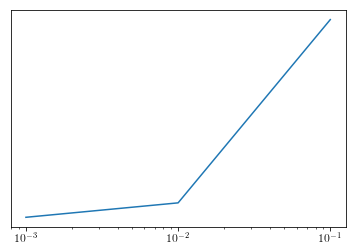

eta= 0.001 mag of gradJ =  3.46224674522e-06 mag d =  9.16403706423e-06 J= 0.000673730175084 incompressible? True mean enstrophy 1.0


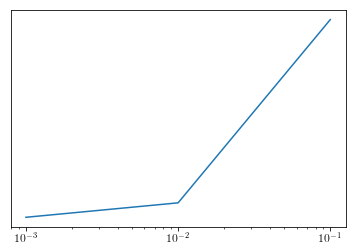

eta= 0.001 mag of gradJ =  3.4611016748e-06 mag d =  9.16065421644e-06 J= 0.000673730175085 incompressible? True mean enstrophy 1.0


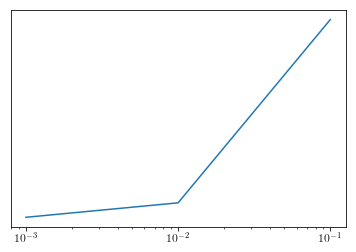

eta= 0.001 mag of gradJ =  3.45995699493e-06 mag d =  9.15727270366e-06 J= 0.000673730175087 incompressible? True mean enstrophy 1.0


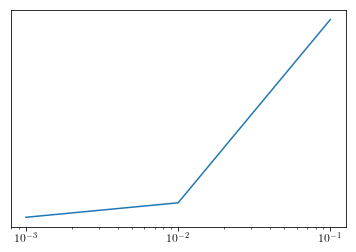

eta= 0.001 mag of gradJ =  3.45881270549e-06 mag d =  9.15389252509e-06 J= 0.000673730175088 incompressible? True mean enstrophy 1.0


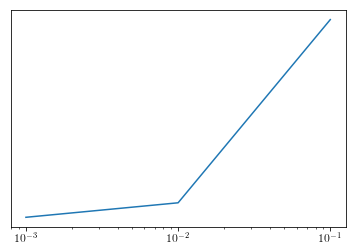

eta= 0.001 mag of gradJ =  3.45766880634e-06 mag d =  9.15051367989e-06 J= 0.000673730175089 incompressible? True mean enstrophy 1.0


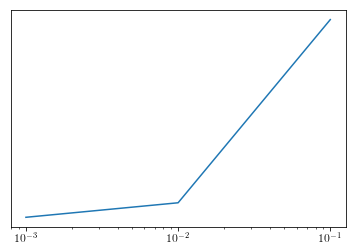

eta= 0.001 mag of gradJ =  3.45652529732e-06 mag d =  9.14713616799e-06 J= 0.00067373017509 incompressible? True mean enstrophy 1.0


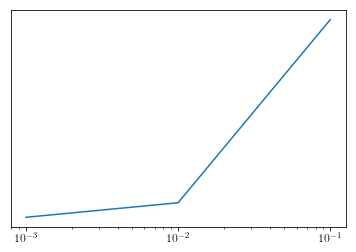

eta= 0.001 mag of gradJ =  3.45538217832e-06 mag d =  9.14375998899e-06 J= 0.000673730175091 incompressible? True mean enstrophy 1.0


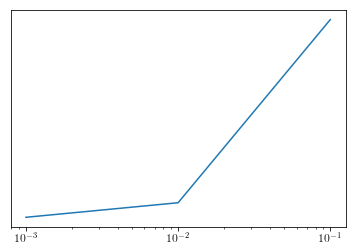

eta= 0.001 mag of gradJ =  3.45423944918e-06 mag d =  9.14038514181e-06 J= 0.000673730175092 incompressible? True mean enstrophy 1.0


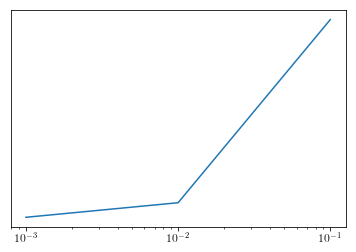

eta= 0.001 mag of gradJ =  3.45309710978e-06 mag d =  9.137011626e-06 J= 0.000673730175094 incompressible? True mean enstrophy 1.0


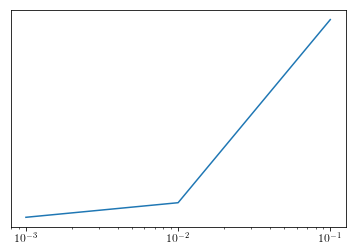

eta= 0.001 mag of gradJ =  3.45195515998e-06 mag d =  9.13363944124e-06 J= 0.000673730175095 incompressible? True mean enstrophy 1.0


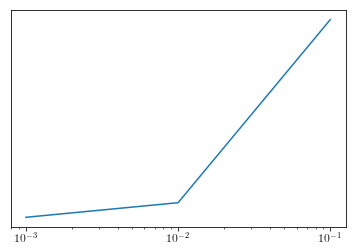

eta= 0.001 mag of gradJ =  3.45081359962e-06 mag d =  9.13026858701e-06 J= 0.000673730175096 incompressible? True mean enstrophy 1.0


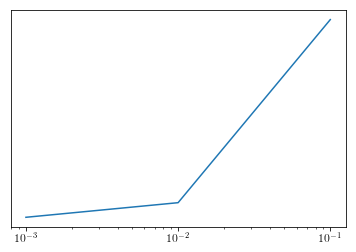

eta= 0.001 mag of gradJ =  3.44967242859e-06 mag d =  9.12689906259e-06 J= 0.000673730175097 incompressible? True mean enstrophy 1.0


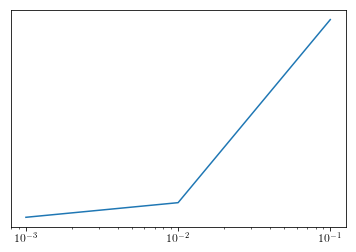

eta= 0.001 mag of gradJ =  3.44853164674e-06 mag d =  9.12353086727e-06 J= 0.000673730175099 incompressible? True mean enstrophy 1.0


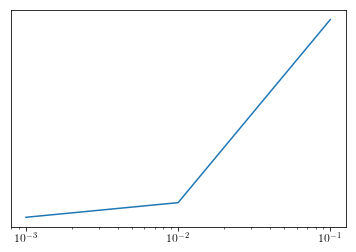

eta= 0.001 mag of gradJ =  3.44739125393e-06 mag d =  9.12016400085e-06 J= 0.0006737301751 incompressible? True mean enstrophy 1.0


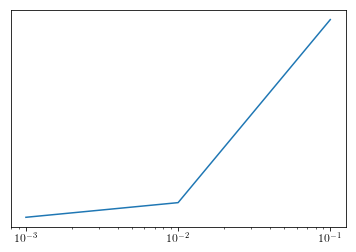

eta= 0.001 mag of gradJ =  3.44625125004e-06 mag d =  9.11679846243e-06 J= 0.000673730175101 incompressible? True mean enstrophy 1.0


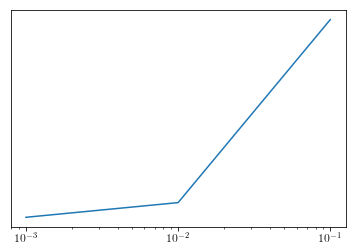

eta= 0.001 mag of gradJ =  3.44511163491e-06 mag d =  9.11343425194e-06 J= 0.000673730175102 incompressible? True mean enstrophy 1.0


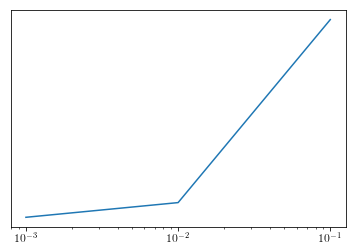

eta= 0.001 mag of gradJ =  3.44397240841e-06 mag d =  9.11007136849e-06 J= 0.000673730175104 incompressible? True mean enstrophy 1.0


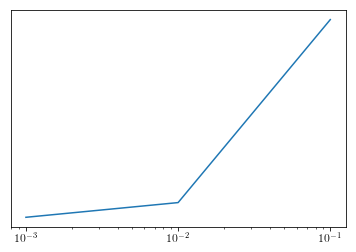

eta= 0.001 mag of gradJ =  3.4428335704e-06 mag d =  9.10670981135e-06 J= 0.000673730175105 incompressible? True mean enstrophy 1.0


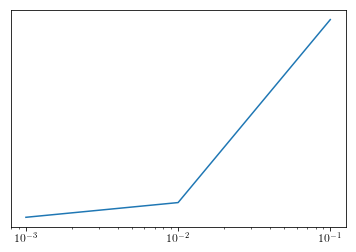

eta= 0.001 mag of gradJ =  3.44169512075e-06 mag d =  9.10334958037e-06 J= 0.000673730175106 incompressible? True mean enstrophy 1.0


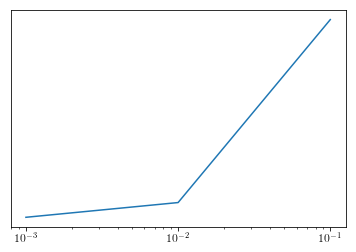

eta= 0.001 mag of gradJ =  3.44055705933e-06 mag d =  9.09999067477e-06 J= 0.000673730175107 incompressible? True mean enstrophy 1.0


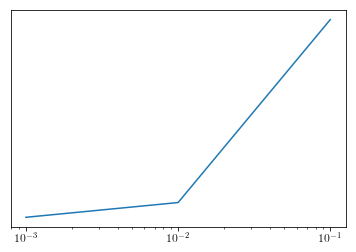

eta= 0.001 mag of gradJ =  3.43941938599e-06 mag d =  9.09663309407e-06 J= 0.000673730175109 incompressible? True mean enstrophy 1.0


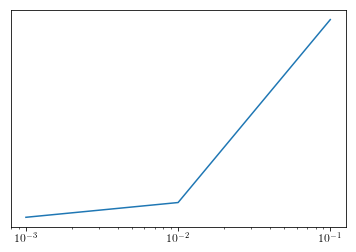

eta= 0.001 mag of gradJ =  3.43828210059e-06 mag d =  9.09327683759e-06 J= 0.00067373017511 incompressible? True mean enstrophy 1.0


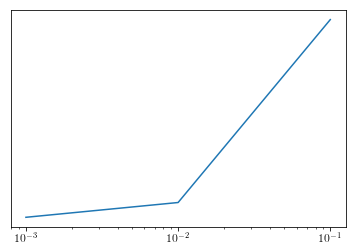

eta= 0.001 mag of gradJ =  3.437145203e-06 mag d =  9.0899219049e-06 J= 0.000673730175111 incompressible? True mean enstrophy 1.0


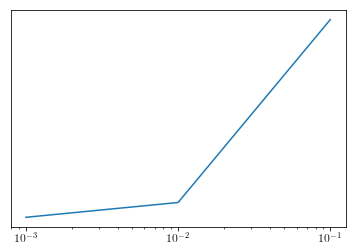

eta= 0.001 mag of gradJ =  3.43600869308e-06 mag d =  9.08656829543e-06 J= 0.000673730175113 incompressible? True mean enstrophy 1.0


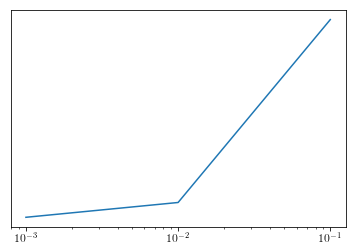

eta= 0.001 mag of gradJ =  3.4348725707e-06 mag d =  9.08321600876e-06 J= 0.000673730175114 incompressible? True mean enstrophy 1.0


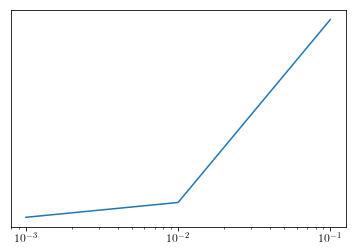

eta= 0.001 mag of gradJ =  3.43373683572e-06 mag d =  9.07986504406e-06 J= 0.000673730175115 incompressible? True mean enstrophy 1.0


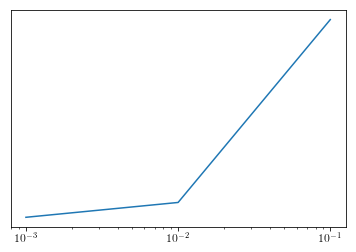

eta= 0.001 mag of gradJ =  3.43260148799e-06 mag d =  9.07651540116e-06 J= 0.000673730175117 incompressible? True mean enstrophy 1.0


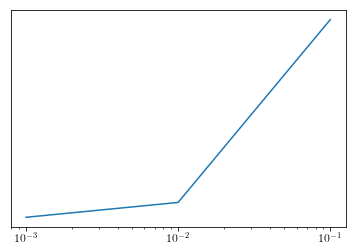

eta= 0.001 mag of gradJ =  3.43146652739e-06 mag d =  9.07316707922e-06 J= 0.000673730175118 incompressible? True mean enstrophy 1.0


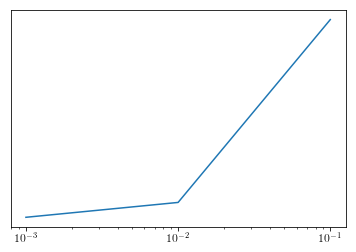

eta= 0.001 mag of gradJ =  3.43033195378e-06 mag d =  9.06982007774e-06 J= 0.000673730175119 incompressible? True mean enstrophy 1.0


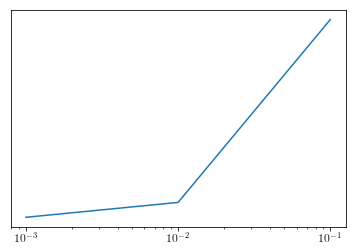

eta= 0.001 mag of gradJ =  3.42919776702e-06 mag d =  9.06647439609e-06 J= 0.000673730175121 incompressible? True mean enstrophy 1.0


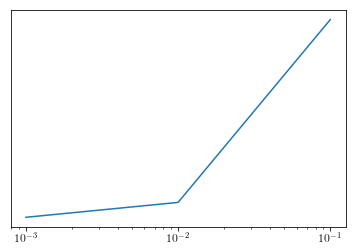

eta= 0.001 mag of gradJ =  3.42806396697e-06 mag d =  9.06313003396e-06 J= 0.000673730175122 incompressible? True mean enstrophy 1.0


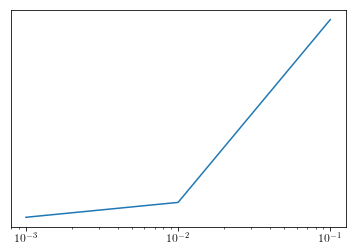

eta= 0.001 mag of gradJ =  3.4269305535e-06 mag d =  9.05978699061e-06 J= 0.000673730175123 incompressible? True mean enstrophy 1.0


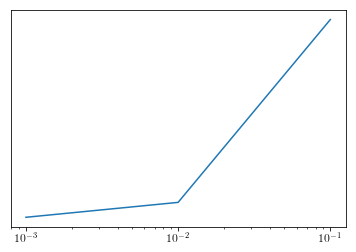

eta= 0.001 mag of gradJ =  3.42579752647e-06 mag d =  9.05644526542e-06 J= 0.000673730175125 incompressible? True mean enstrophy 1.0


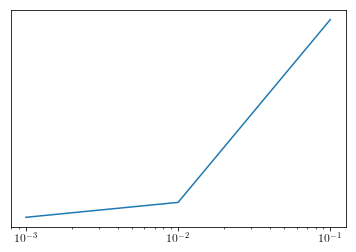

eta= 0.001 mag of gradJ =  3.42466488574e-06 mag d =  9.05310485843e-06 J= 0.000673730175126 incompressible? True mean enstrophy 1.0


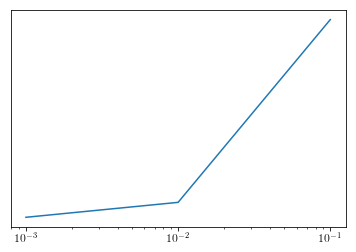

eta= 0.001 mag of gradJ =  3.42353263118e-06 mag d =  9.04976576823e-06 J= 0.000673730175127 incompressible? True mean enstrophy 1.0


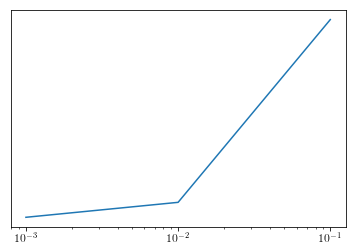

eta= 0.001 mag of gradJ =  3.42240076265e-06 mag d =  9.04642799487e-06 J= 0.000673730175129 incompressible? True mean enstrophy 1.0


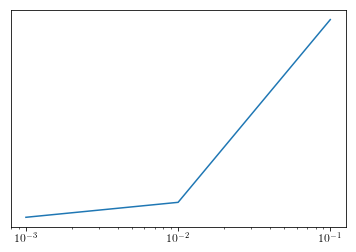

eta= 0.001 mag of gradJ =  3.42126928002e-06 mag d =  9.0430915375e-06 J= 0.00067373017513 incompressible? True mean enstrophy 1.0


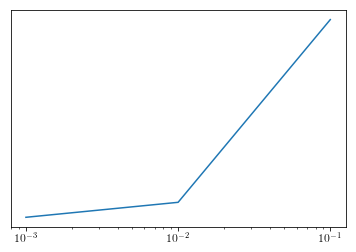

eta= 0.001 mag of gradJ =  3.42013818315e-06 mag d =  9.03975639556e-06 J= 0.000673730175132 incompressible? True mean enstrophy 1.0


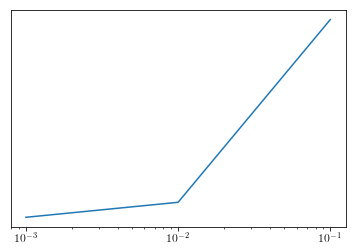

eta= 0.001 mag of gradJ =  3.4190074719e-06 mag d =  9.03642256904e-06 J= 0.000673730175133 incompressible? True mean enstrophy 1.0


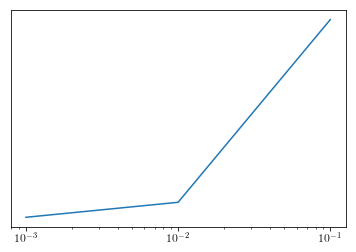

eta= 0.001 mag of gradJ =  3.41787714613e-06 mag d =  9.03309005673e-06 J= 0.000673730175134 incompressible? True mean enstrophy 1.0


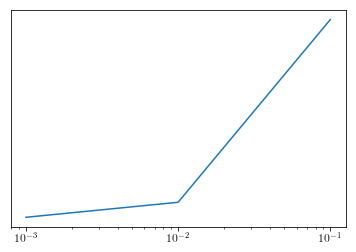

eta= 0.001 mag of gradJ =  3.41674720572e-06 mag d =  9.02975885829e-06 J= 0.000673730175136 incompressible? True mean enstrophy 1.0


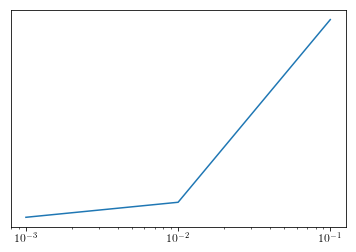

eta= 0.001 mag of gradJ =  3.41561765051e-06 mag d =  9.02642897353e-06 J= 0.000673730175137 incompressible? True mean enstrophy 1.0


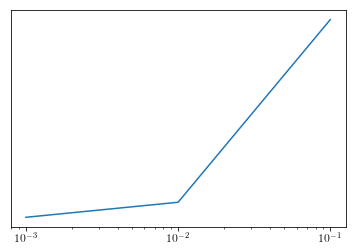

eta= 0.001 mag of gradJ =  3.41448848039e-06 mag d =  9.02310040135e-06 J= 0.000673730175139 incompressible? True mean enstrophy 1.0


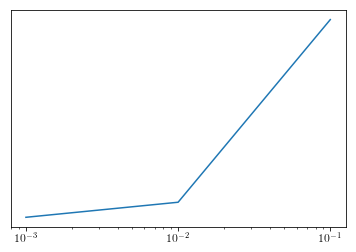

eta= 0.001 mag of gradJ =  3.41335969521e-06 mag d =  9.01977314133e-06 J= 0.00067373017514 incompressible? True mean enstrophy 1.0


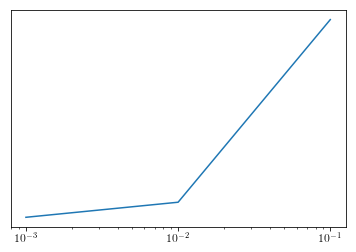

eta= 0.001 mag of gradJ =  3.41223129483e-06 mag d =  9.01644719327e-06 J= 0.000673730175141 incompressible? True mean enstrophy 1.0


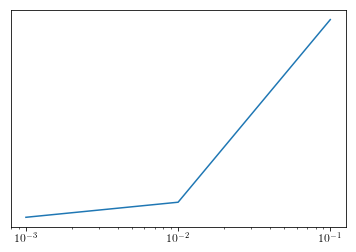

eta= 0.001 mag of gradJ =  3.41110327912e-06 mag d =  9.01312255647e-06 J= 0.000673730175143 incompressible? True mean enstrophy 1.0


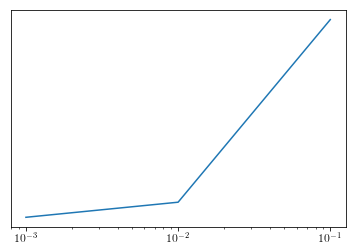

eta= 0.001 mag of gradJ =  3.40997564795e-06 mag d =  9.00979923006e-06 J= 0.000673730175144 incompressible? True mean enstrophy 1.0


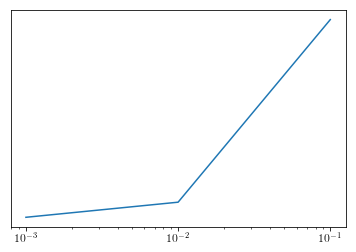

eta= 0.001 mag of gradJ =  3.40884840118e-06 mag d =  9.00647721399e-06 J= 0.000673730175146 incompressible? True mean enstrophy 1.0


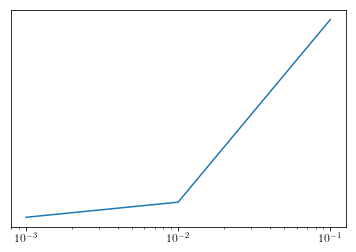

eta= 0.001 mag of gradJ =  3.40772153866e-06 mag d =  9.0031565075e-06 J= 0.000673730175147 incompressible? True mean enstrophy 1.0


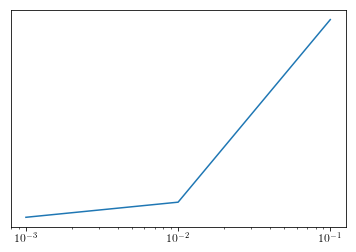

eta= 0.001 mag of gradJ =  3.40659506028e-06 mag d =  8.99983710988e-06 J= 0.000673730175149 incompressible? True mean enstrophy 1.0


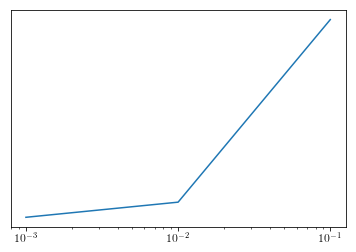

eta= 0.001 mag of gradJ =  3.40546896588e-06 mag d =  8.99651902074e-06 J= 0.00067373017515 incompressible? True mean enstrophy 1.0


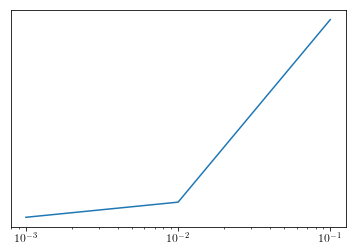

eta= 0.001 mag of gradJ =  3.40434325535e-06 mag d =  8.99320223957e-06 J= 0.000673730175152 incompressible? True mean enstrophy 1.0


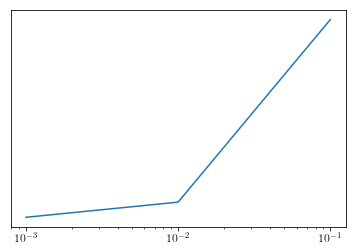

eta= 0.001 mag of gradJ =  3.40321792853e-06 mag d =  8.98988676577e-06 J= 0.000673730175153 incompressible? True mean enstrophy 1.0


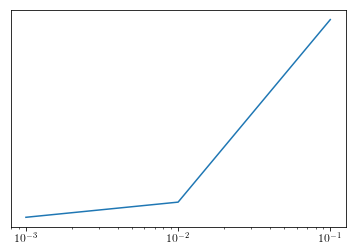

eta= 0.001 mag of gradJ =  3.40209298529e-06 mag d =  8.98657259889e-06 J= 0.000673730175155 incompressible? True mean enstrophy 1.0


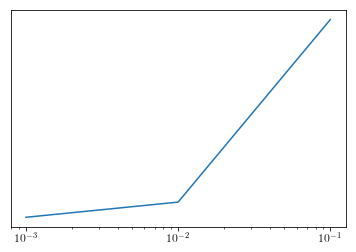

eta= 0.001 mag of gradJ =  3.4009684255e-06 mag d =  8.98325973845e-06 J= 0.000673730175156 incompressible? True mean enstrophy 1.0


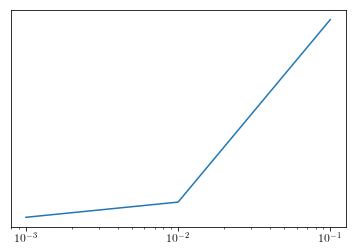

eta= 0.001 mag of gradJ =  3.39984424903e-06 mag d =  8.97994818368e-06 J= 0.000673730175158 incompressible? True mean enstrophy 1.0


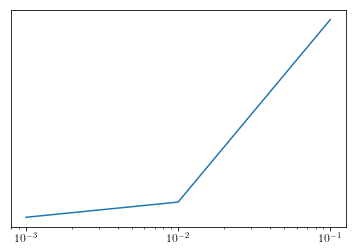

eta= 0.001 mag of gradJ =  3.39872045574e-06 mag d =  8.97663793375e-06 J= 0.000673730175159 incompressible? True mean enstrophy 1.0


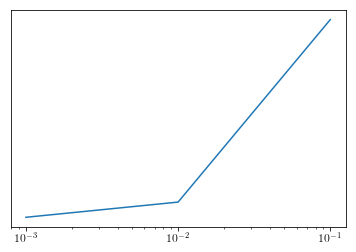

eta= 0.001 mag of gradJ =  3.39759704549e-06 mag d =  8.97332898895e-06 J= 0.000673730175161 incompressible? True mean enstrophy 1.0


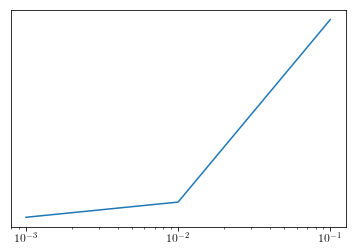

eta= 0.001 mag of gradJ =  3.39647401814e-06 mag d =  8.97002134824e-06 J= 0.000673730175162 incompressible? True mean enstrophy 1.0


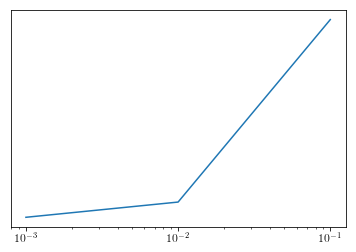

eta= 0.001 mag of gradJ =  3.39535137357e-06 mag d =  8.96671501109e-06 J= 0.000673730175164 incompressible? True mean enstrophy 1.0


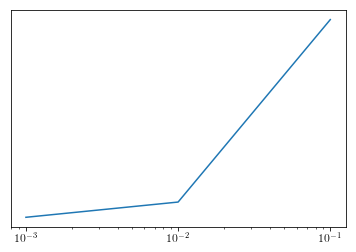

eta= 0.001 mag of gradJ =  3.39422911163e-06 mag d =  8.96340997687e-06 J= 0.000673730175165 incompressible? True mean enstrophy 1.0


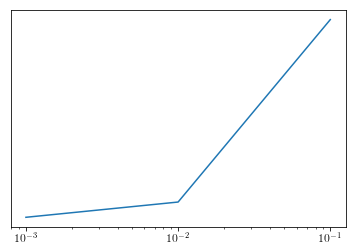

eta= 0.001 mag of gradJ =  3.3931072322e-06 mag d =  8.96010624526e-06 J= 0.000673730175167 incompressible? True mean enstrophy 1.0


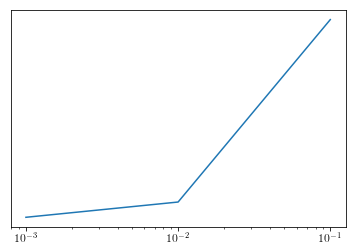

eta= 0.001 mag of gradJ =  3.39198573513e-06 mag d =  8.95680381577e-06 J= 0.000673730175168 incompressible? True mean enstrophy 1.0


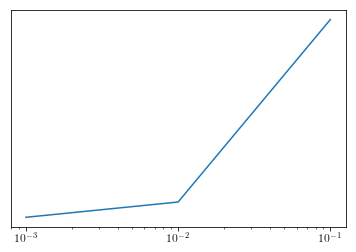

eta= 0.001 mag of gradJ =  3.3908646203e-06 mag d =  8.95350268745e-06 J= 0.00067373017517 incompressible? True mean enstrophy 1.0


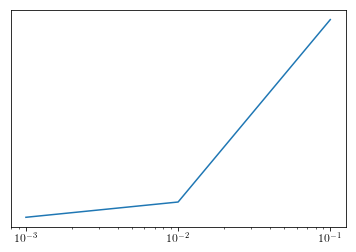

eta= 0.001 mag of gradJ =  3.38974388756e-06 mag d =  8.95020286017e-06 J= 0.000673730175171 incompressible? True mean enstrophy 1.0


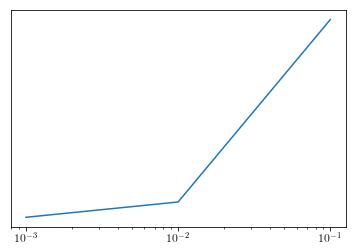

eta= 0.001 mag of gradJ =  3.38862353679e-06 mag d =  8.94690433327e-06 J= 0.000673730175173 incompressible? True mean enstrophy 1.0


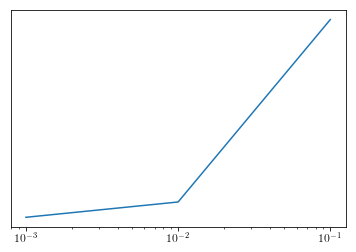

eta= 0.001 mag of gradJ =  3.38750356785e-06 mag d =  8.94360710593e-06 J= 0.000673730175175 incompressible? True mean enstrophy 1.0


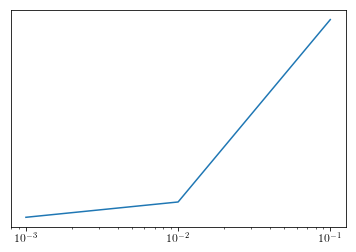

eta= 0.001 mag of gradJ =  3.38638398059e-06 mag d =  8.94031117817e-06 J= 0.000673730175176 incompressible? True mean enstrophy 1.0


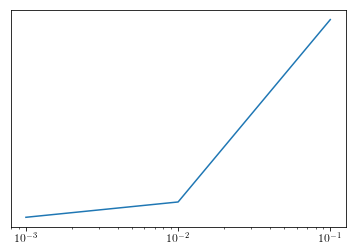

eta= 0.001 mag of gradJ =  3.38526477489e-06 mag d =  8.93701654915e-06 J= 0.000673730175178 incompressible? True mean enstrophy 1.0


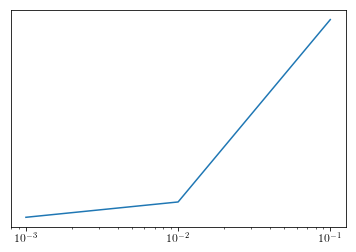

eta= 0.001 mag of gradJ =  3.38414595061e-06 mag d =  8.93372321835e-06 J= 0.000673730175179 incompressible? True mean enstrophy 1.0


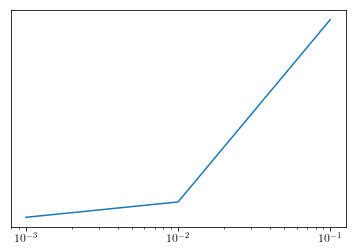

eta= 0.001 mag of gradJ =  3.38302750763e-06 mag d =  8.93043118516e-06 J= 0.000673730175181 incompressible? True mean enstrophy 1.0


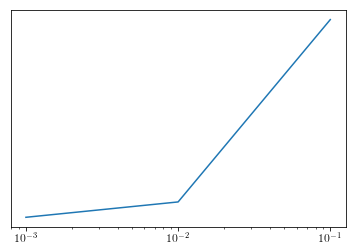

eta= 0.001 mag of gradJ =  3.38190944579e-06 mag d =  8.92714044894e-06 J= 0.000673730175183 incompressible? True mean enstrophy 1.0


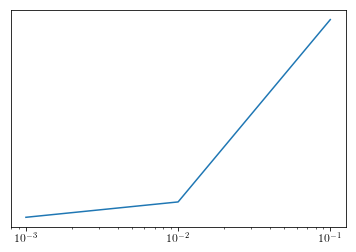

eta= 0.001 mag of gradJ =  3.38079176497e-06 mag d =  8.92385100961e-06 J= 0.000673730175184 incompressible? True mean enstrophy 1.0


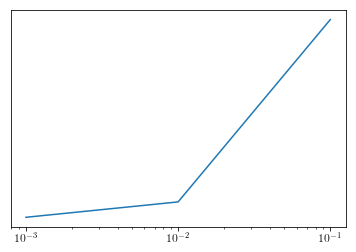

eta= 0.001 mag of gradJ =  3.37967446504e-06 mag d =  8.92056286591e-06 J= 0.000673730175186 incompressible? True mean enstrophy 1.0


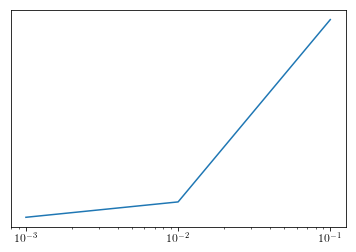

eta= 0.001 mag of gradJ =  3.37855754586e-06 mag d =  8.917276018e-06 J= 0.000673730175187 incompressible? True mean enstrophy 1.0


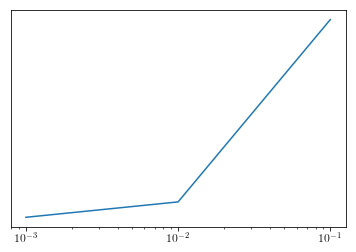

eta= 0.001 mag of gradJ =  3.3774410073e-06 mag d =  8.91399046517e-06 J= 0.000673730175189 incompressible? True mean enstrophy 1.0


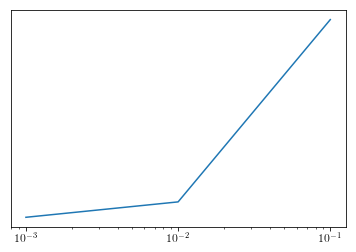

eta= 0.001 mag of gradJ =  3.37632484921e-06 mag d =  8.91070620644e-06 J= 0.000673730175191 incompressible? True mean enstrophy 1.0


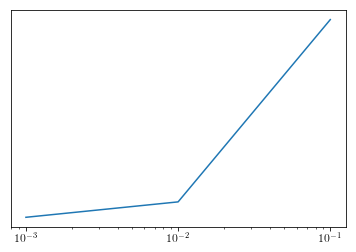

eta= 0.001 mag of gradJ =  3.37520907148e-06 mag d =  8.90742324167e-06 J= 0.000673730175192 incompressible? True mean enstrophy 1.0


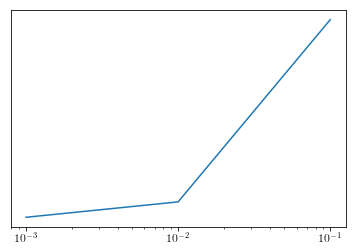

eta= 0.001 mag of gradJ =  3.37409367395e-06 mag d =  8.90414157047e-06 J= 0.000673730175194 incompressible? True mean enstrophy 1.0


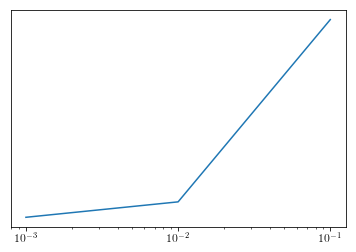

eta= 0.001 mag of gradJ =  3.37297865651e-06 mag d =  8.90086119176e-06 J= 0.000673730175196 incompressible? True mean enstrophy 1.0


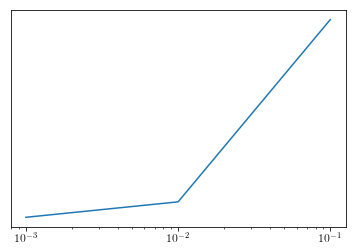

eta= 0.001 mag of gradJ =  3.37186401901e-06 mag d =  8.89758210568e-06 J= 0.000673730175197 incompressible? True mean enstrophy 1.0


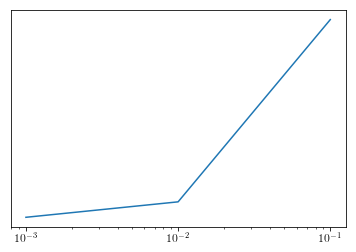

eta= 0.001 mag of gradJ =  3.37074976132e-06 mag d =  8.89430431122e-06 J= 0.000673730175199 incompressible? True mean enstrophy 1.0


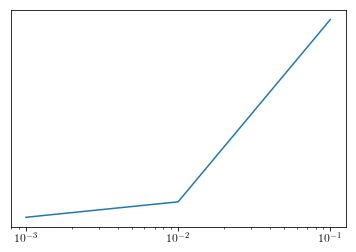

eta= 0.001 mag of gradJ =  3.3696358833e-06 mag d =  8.89102780806e-06 J= 0.000673730175201 incompressible? True mean enstrophy 1.0


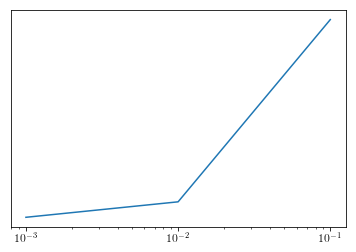

eta= 0.001 mag of gradJ =  3.36852238482e-06 mag d =  8.88775259551e-06 J= 0.000673730175202 incompressible? True mean enstrophy 1.0


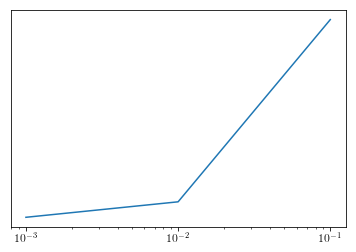

eta= 0.001 mag of gradJ =  3.36740926576e-06 mag d =  8.88447867295e-06 J= 0.000673730175204 incompressible? True mean enstrophy 1.0


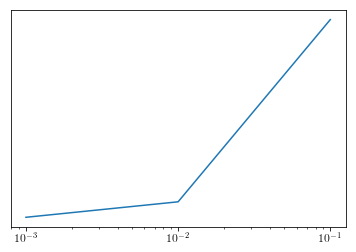

eta= 0.001 mag of gradJ =  3.36629652597e-06 mag d =  8.88120604018e-06 J= 0.000673730175206 incompressible? True mean enstrophy 1.0


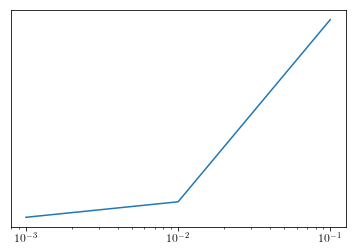

eta= 0.001 mag of gradJ =  3.36518416532e-06 mag d =  8.87793469651e-06 J= 0.000673730175207 incompressible? True mean enstrophy 1.0


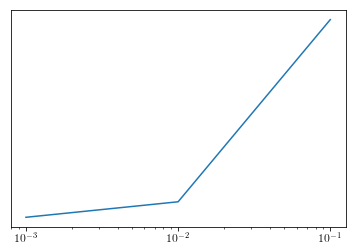

eta= 0.001 mag of gradJ =  3.36407218367e-06 mag d =  8.87466464121e-06 J= 0.000673730175209 incompressible? True mean enstrophy 1.0


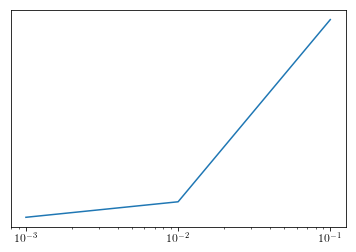

eta= 0.001 mag of gradJ =  3.3629605809e-06 mag d =  8.87139587426e-06 J= 0.000673730175211 incompressible? True mean enstrophy 1.0


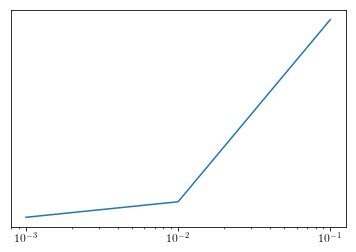

eta= 0.001 mag of gradJ =  3.36184935686e-06 mag d =  8.86812839458e-06 J= 0.000673730175212 incompressible? True mean enstrophy 1.0


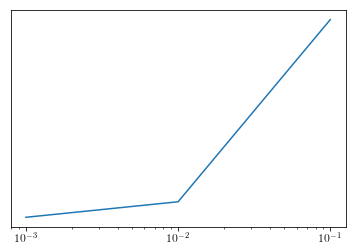

eta= 0.001 mag of gradJ =  3.36073851143e-06 mag d =  8.8648622018e-06 J= 0.000673730175214 incompressible? True mean enstrophy 1.0


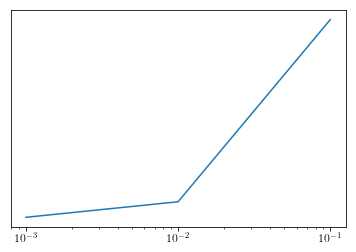

eta= 0.001 mag of gradJ =  3.35962804447e-06 mag d =  8.86159729536e-06 J= 0.000673730175216 incompressible? True mean enstrophy 1.0


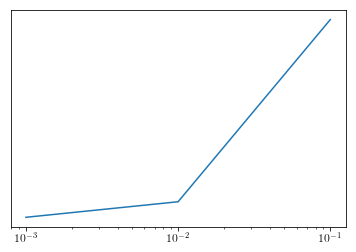

eta= 0.001 mag of gradJ =  3.35851795586e-06 mag d =  8.85833367473e-06 J= 0.000673730175218 incompressible? True mean enstrophy 1.0


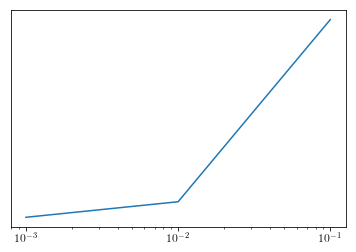

eta= 0.001 mag of gradJ =  3.35740824544e-06 mag d =  8.85507133967e-06 J= 0.000673730175219 incompressible? True mean enstrophy 1.0


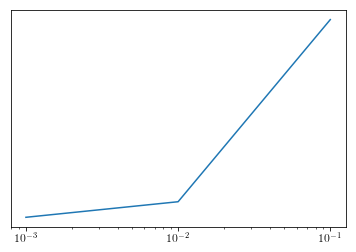

eta= 0.001 mag of gradJ =  3.35629891309e-06 mag d =  8.8518102893e-06 J= 0.000673730175221 incompressible? True mean enstrophy 1.0


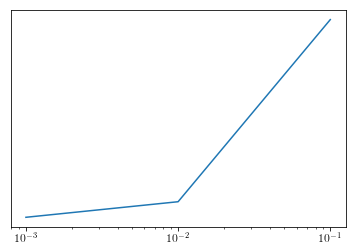

eta= 0.001 mag of gradJ =  3.35518995868e-06 mag d =  8.84855052314e-06 J= 0.000673730175223 incompressible? True mean enstrophy 1.0


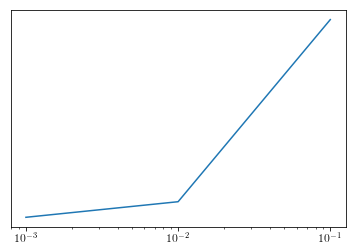

eta= 0.001 mag of gradJ =  3.35408138208e-06 mag d =  8.84529204078e-06 J= 0.000673730175225 incompressible? True mean enstrophy 1.0


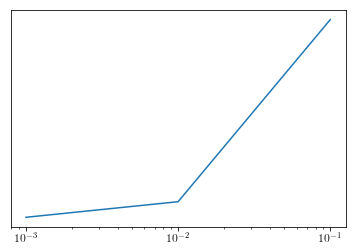

eta= 0.001 mag of gradJ =  3.35297318315e-06 mag d =  8.84203484181e-06 J= 0.000673730175226 incompressible? True mean enstrophy 1.0


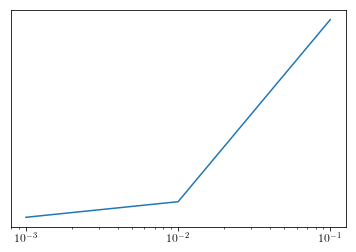

eta= 0.001 mag of gradJ =  3.35186536175e-06 mag d =  8.83877892525e-06 J= 0.000673730175228 incompressible? True mean enstrophy 1.0


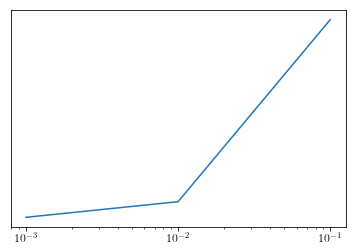

eta= 0.001 mag of gradJ =  3.35075791776e-06 mag d =  8.83552429076e-06 J= 0.00067373017523 incompressible? True mean enstrophy 1.0


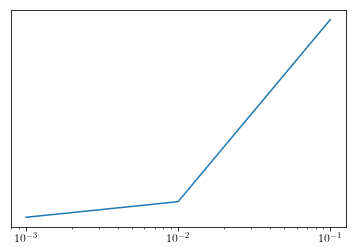

eta= 0.001 mag of gradJ =  3.34965085104e-06 mag d =  8.8322709381e-06 J= 0.000673730175232 incompressible? True mean enstrophy 1.0


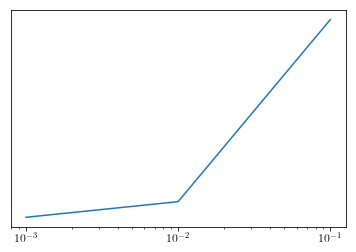

eta= 0.001 mag of gradJ =  3.34854416145e-06 mag d =  8.82901886649e-06 J= 0.000673730175233 incompressible? True mean enstrophy 1.0


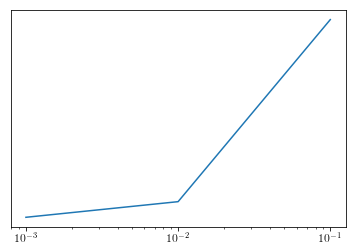

eta= 0.001 mag of gradJ =  3.34743784888e-06 mag d =  8.82576807537e-06 J= 0.000673730175235 incompressible? True mean enstrophy 1.0


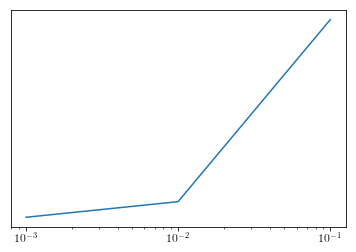

eta= 0.001 mag of gradJ =  3.34633191317e-06 mag d =  8.82251856432e-06 J= 0.000673730175237 incompressible? True mean enstrophy 1.0


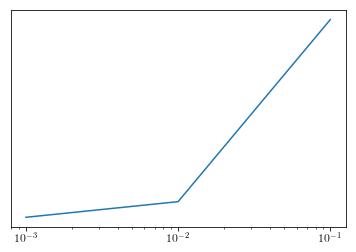

eta= 0.001 mag of gradJ =  3.3452263542e-06 mag d =  8.81927033266e-06 J= 0.000673730175239 incompressible? True mean enstrophy 1.0


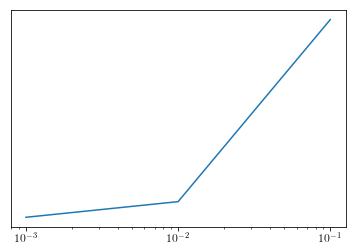

eta= 0.001 mag of gradJ =  3.34412117184e-06 mag d =  8.81602337992e-06 J= 0.000673730175241 incompressible? True mean enstrophy 1.0


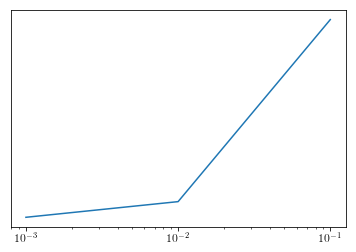

eta= 0.001 mag of gradJ =  3.34301636596e-06 mag d =  8.81277770563e-06 J= 0.000673730175242 incompressible? True mean enstrophy 1.0


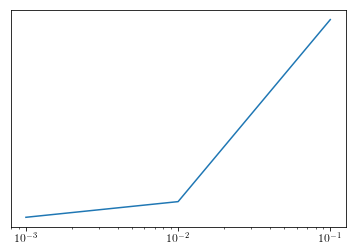

eta= 0.001 mag of gradJ =  3.3419119364e-06 mag d =  8.80953330935e-06 J= 0.000673730175244 incompressible? True mean enstrophy 1.0


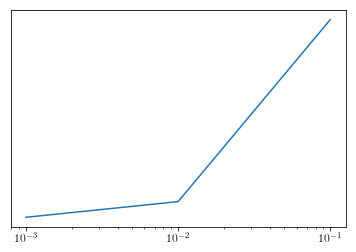

eta= 0.001 mag of gradJ =  3.34080788306e-06 mag d =  8.80629019032e-06 J= 0.000673730175246 incompressible? True mean enstrophy 1.0


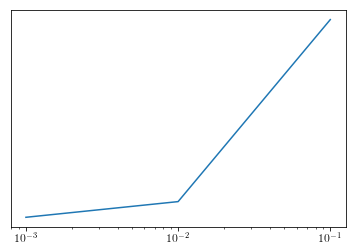

eta= 0.001 mag of gradJ =  3.33970420579e-06 mag d =  8.80304834831e-06 J= 0.000673730175248 incompressible? True mean enstrophy 1.0


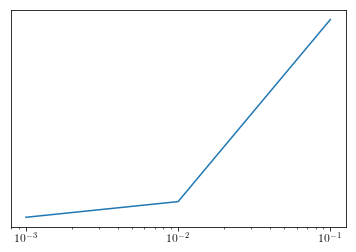

eta= 0.001 mag of gradJ =  3.33860090447e-06 mag d =  8.79980778236e-06 J= 0.00067373017525 incompressible? True mean enstrophy 1.0


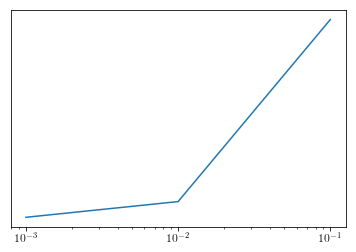

eta= 0.001 mag of gradJ =  3.33749797895e-06 mag d =  8.79656849232e-06 J= 0.000673730175251 incompressible? True mean enstrophy 1.0


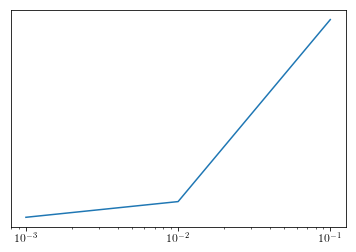

eta= 0.001 mag of gradJ =  3.33639542911e-06 mag d =  8.79333047757e-06 J= 0.000673730175253 incompressible? True mean enstrophy 1.0


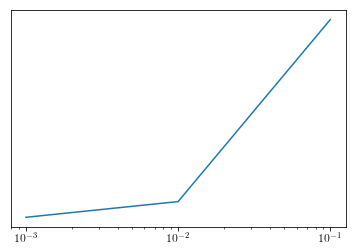

eta= 0.001 mag of gradJ =  3.33529325481e-06 mag d =  8.79009373721e-06 J= 0.000673730175255 incompressible? True mean enstrophy 1.0


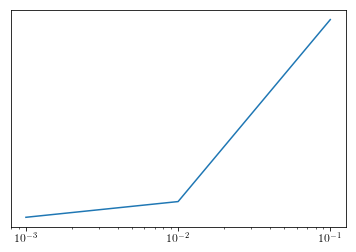

eta= 0.001 mag of gradJ =  3.33419145593e-06 mag d =  8.78685827134e-06 J= 0.000673730175257 incompressible? True mean enstrophy 1.0


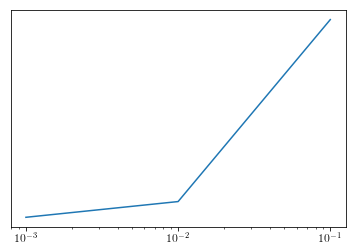

eta= 0.001 mag of gradJ =  3.33309003232e-06 mag d =  8.7836240792e-06 J= 0.000673730175259 incompressible? True mean enstrophy 1.0


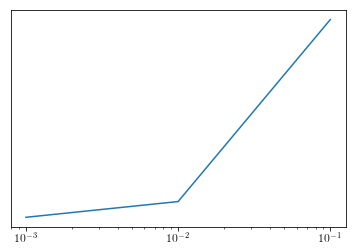

eta= 0.001 mag of gradJ =  3.33198898386e-06 mag d =  8.78039115984e-06 J= 0.000673730175261 incompressible? True mean enstrophy 1.0


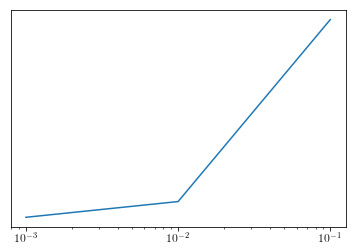

eta= 0.001 mag of gradJ =  3.33088831041e-06 mag d =  8.77715951355e-06 J= 0.000673730175263 incompressible? True mean enstrophy 1.0


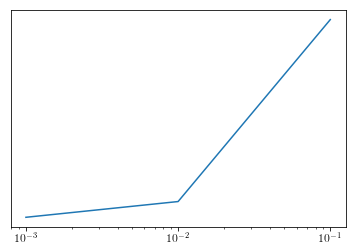

eta= 0.001 mag of gradJ =  3.32978801185e-06 mag d =  8.77392913886e-06 J= 0.000673730175264 incompressible? True mean enstrophy 1.0


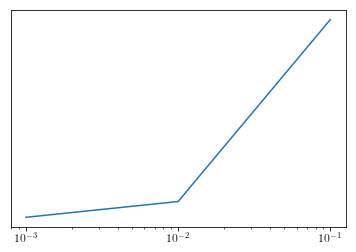

eta= 0.001 mag of gradJ =  3.32868808804e-06 mag d =  8.77070003586e-06 J= 0.000673730175266 incompressible? True mean enstrophy 1.0


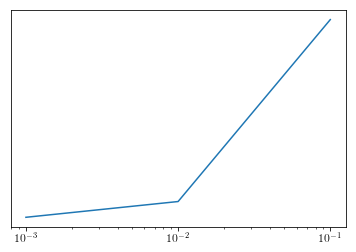

eta= 0.001 mag of gradJ =  3.32758853884e-06 mag d =  8.76747220397e-06 J= 0.000673730175268 incompressible? True mean enstrophy 1.0


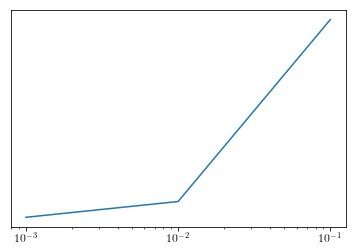

eta= 0.001 mag of gradJ =  3.32648936412e-06 mag d =  8.76424564269e-06 J= 0.00067373017527 incompressible? True mean enstrophy 1.0


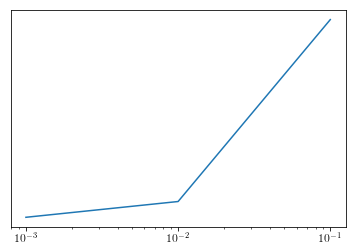

eta= 0.001 mag of gradJ =  3.32539056376e-06 mag d =  8.76102035114e-06 J= 0.000673730175272 incompressible? True mean enstrophy 1.0


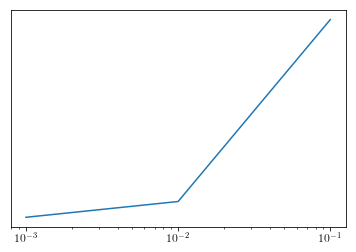

eta= 0.001 mag of gradJ =  3.32429213763e-06 mag d =  8.75779632919e-06 J= 0.000673730175274 incompressible? True mean enstrophy 1.0


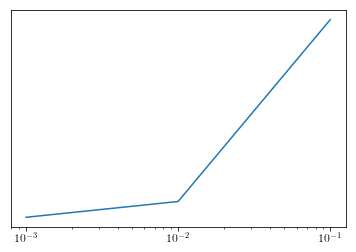

eta= 0.001 mag of gradJ =  3.32319408557e-06 mag d =  8.75457357618e-06 J= 0.000673730175276 incompressible? True mean enstrophy 1.0


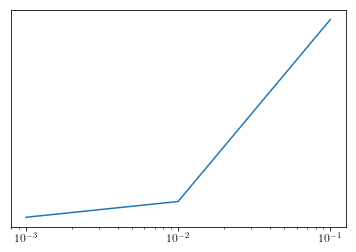

eta= 0.001 mag of gradJ =  3.32209640748e-06 mag d =  8.7513520912e-06 J= 0.000673730175278 incompressible? True mean enstrophy 1.0


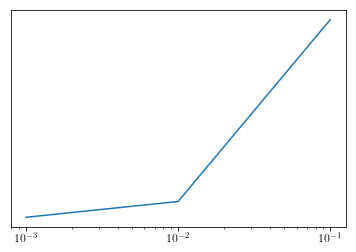

eta= 0.001 mag of gradJ =  3.32099910322e-06 mag d =  8.74813187446e-06 J= 0.00067373017528 incompressible? True mean enstrophy 1.0


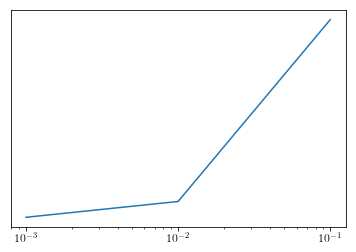

eta= 0.001 mag of gradJ =  3.31990217264e-06 mag d =  8.74491292478e-06 J= 0.000673730175282 incompressible? True mean enstrophy 1.0


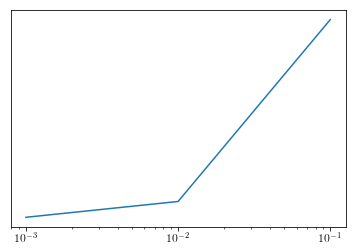

eta= 0.001 mag of gradJ =  3.31880561563e-06 mag d =  8.74169524205e-06 J= 0.000673730175284 incompressible? True mean enstrophy 1.0


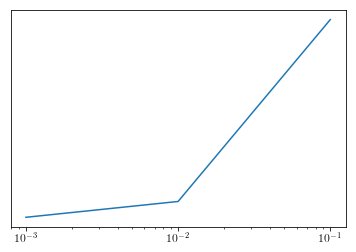

eta= 0.001 mag of gradJ =  3.31770943204e-06 mag d =  8.73847882582e-06 J= 0.000673730175285 incompressible? True mean enstrophy 1.0


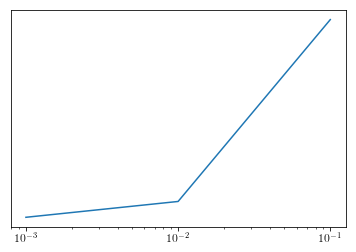

eta= 0.001 mag of gradJ =  3.31661362176e-06 mag d =  8.73526367494e-06 J= 0.000673730175287 incompressible? True mean enstrophy 1.0


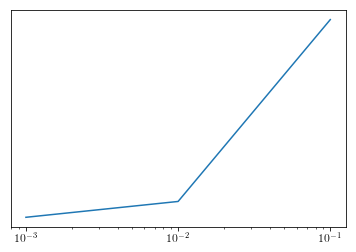

eta= 0.001 mag of gradJ =  3.31551818463e-06 mag d =  8.73204978964e-06 J= 0.000673730175289 incompressible? True mean enstrophy 1.0


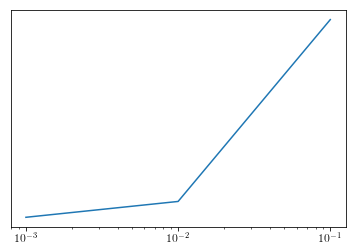

eta= 0.001 mag of gradJ =  3.31442312055e-06 mag d =  8.72883716889e-06 J= 0.000673730175291 incompressible? True mean enstrophy 1.0


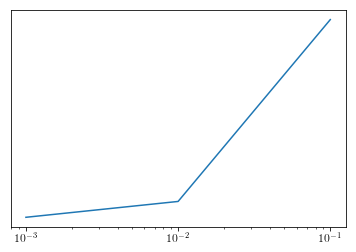

eta= 0.001 mag of gradJ =  3.31332842937e-06 mag d =  8.7256258123e-06 J= 0.000673730175293 incompressible? True mean enstrophy 1.0


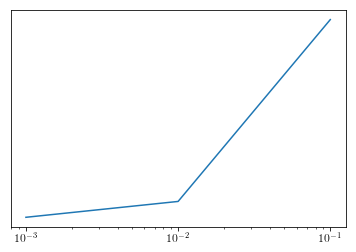

eta= 0.001 mag of gradJ =  3.31223411095e-06 mag d =  8.72241571954e-06 J= 0.000673730175295 incompressible? True mean enstrophy 1.0


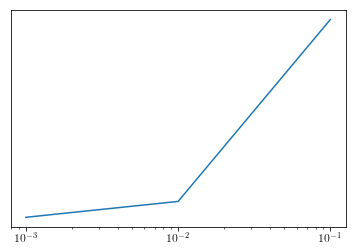

eta= 0.001 mag of gradJ =  3.31114016519e-06 mag d =  8.71920688951e-06 J= 0.000673730175297 incompressible? True mean enstrophy 1.0


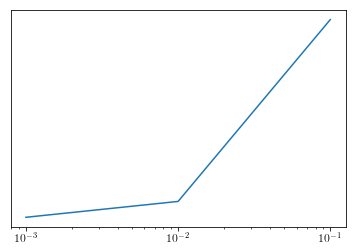

eta= 0.001 mag of gradJ =  3.31004659192e-06 mag d =  8.71599932263e-06 J= 0.000673730175299 incompressible? True mean enstrophy 1.0


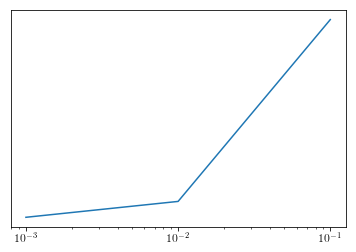

eta= 0.001 mag of gradJ =  3.30895339103e-06 mag d =  8.71279301755e-06 J= 0.000673730175301 incompressible? True mean enstrophy 1.0


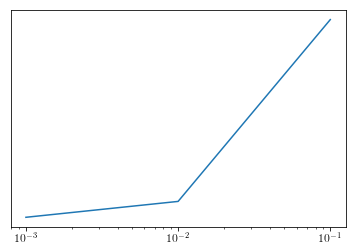

eta= 0.001 mag of gradJ =  3.30786056239e-06 mag d =  8.7095879739e-06 J= 0.000673730175303 incompressible? True mean enstrophy 1.0


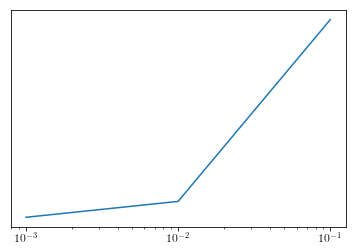

eta= 0.001 mag of gradJ =  3.30676810587e-06 mag d =  8.7063841915e-06 J= 0.000673730175305 incompressible? True mean enstrophy 1.0


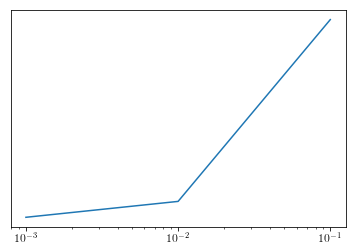

eta= 0.001 mag of gradJ =  3.30567602132e-06 mag d =  8.70318166966e-06 J= 0.000673730175307 incompressible? True mean enstrophy 1.0


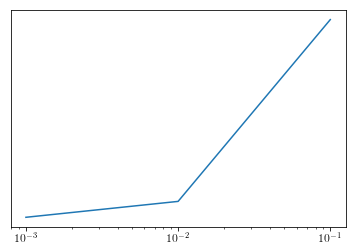

eta= 0.001 mag of gradJ =  3.30458430863e-06 mag d =  8.69998040775e-06 J= 0.000673730175309 incompressible? True mean enstrophy 1.0


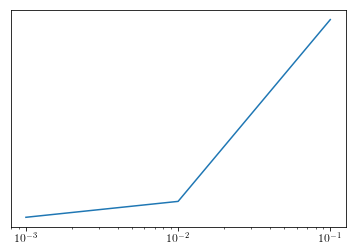

eta= 0.001 mag of gradJ =  3.30349296766e-06 mag d =  8.69678040534e-06 J= 0.000673730175311 incompressible? True mean enstrophy 1.0


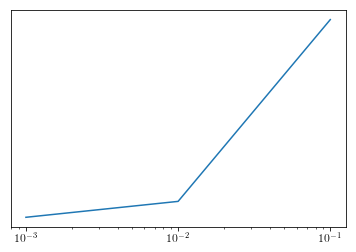

eta= 0.001 mag of gradJ =  3.30240199828e-06 mag d =  8.69358166185e-06 J= 0.000673730175313 incompressible? True mean enstrophy 1.0


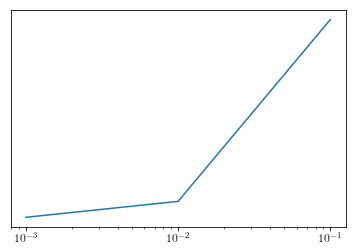

eta= 0.001 mag of gradJ =  3.30131140036e-06 mag d =  8.6903841766e-06 J= 0.000673730175315 incompressible? True mean enstrophy 1.0


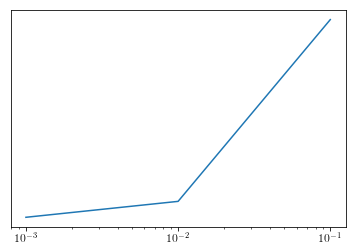

eta= 0.001 mag of gradJ =  3.30022117375e-06 mag d =  8.68718794962e-06 J= 0.000673730175317 incompressible? True mean enstrophy 1.0


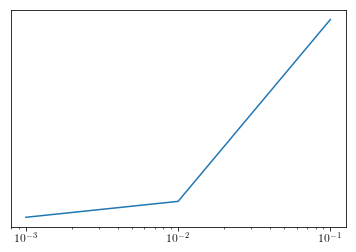

eta= 0.001 mag of gradJ =  3.29913131835e-06 mag d =  8.68399297993e-06 J= 0.000673730175319 incompressible? True mean enstrophy 1.0


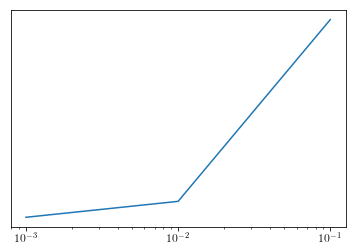

eta= 0.001 mag of gradJ =  3.29804183403e-06 mag d =  8.68079926671e-06 J= 0.000673730175321 incompressible? True mean enstrophy 1.0


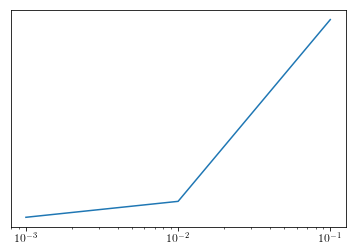

eta= 0.001 mag of gradJ =  3.29695272062e-06 mag d =  8.67760681042e-06 J= 0.000673730175323 incompressible? True mean enstrophy 1.0


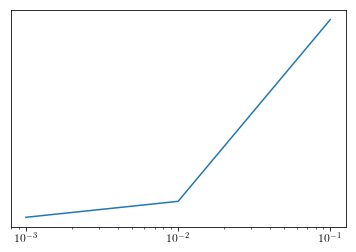

eta= 0.001 mag of gradJ =  3.29586397803e-06 mag d =  8.67441560959e-06 J= 0.000673730175325 incompressible? True mean enstrophy 1.0


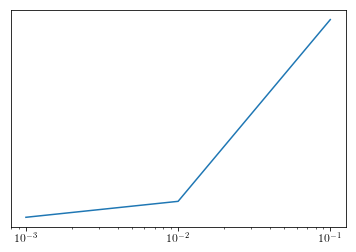

eta= 0.001 mag of gradJ =  3.29477560611e-06 mag d =  8.67122566424e-06 J= 0.000673730175328 incompressible? True mean enstrophy 1.0


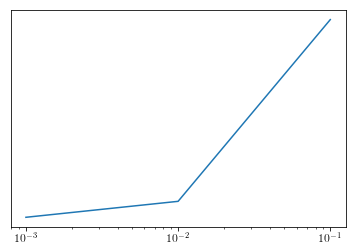

eta= 0.001 mag of gradJ =  3.29368760472e-06 mag d =  8.66803697376e-06 J= 0.00067373017533 incompressible? True mean enstrophy 1.0


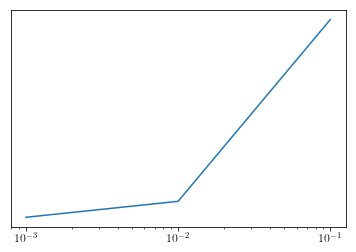

eta= 0.001 mag of gradJ =  3.29259997376e-06 mag d =  8.66484953702e-06 J= 0.000673730175332 incompressible? True mean enstrophy 1.0


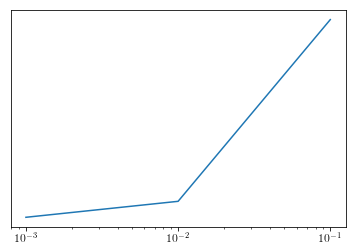

eta= 0.001 mag of gradJ =  3.29151271308e-06 mag d =  8.66166335456e-06 J= 0.000673730175334 incompressible? True mean enstrophy 1.0


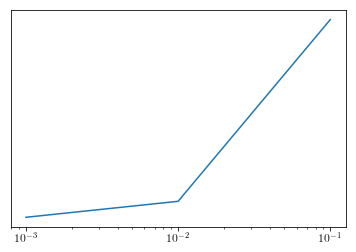

eta= 0.001 mag of gradJ =  3.29042582254e-06 mag d =  8.65847842514e-06 J= 0.000673730175336 incompressible? True mean enstrophy 1.0


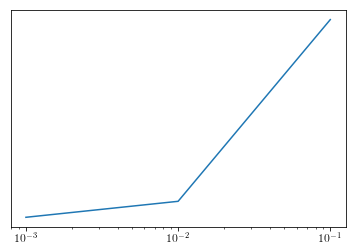

eta= 0.001 mag of gradJ =  3.28933930202e-06 mag d =  8.65529474856e-06 J= 0.000673730175338 incompressible? True mean enstrophy 1.0


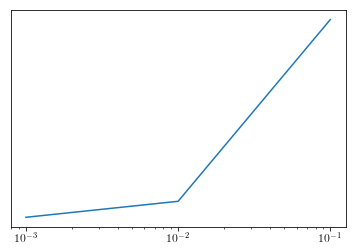

eta= 0.001 mag of gradJ =  3.2882531514e-06 mag d =  8.6521123239e-06 J= 0.00067373017534 incompressible? True mean enstrophy 1.0


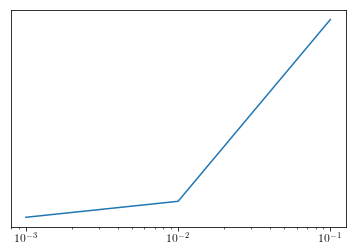

eta= 0.001 mag of gradJ =  3.28716737052e-06 mag d =  8.64893115121e-06 J= 0.000673730175342 incompressible? True mean enstrophy 1.0


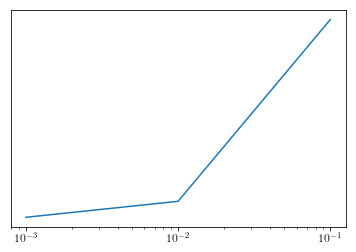

eta= 0.001 mag of gradJ =  3.28608195929e-06 mag d =  8.64575122944e-06 J= 0.000673730175344 incompressible? True mean enstrophy 1.0


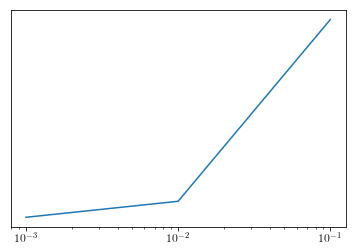

eta= 0.001 mag of gradJ =  3.28499691755e-06 mag d =  8.6425725582e-06 J= 0.000673730175346 incompressible? True mean enstrophy 1.0


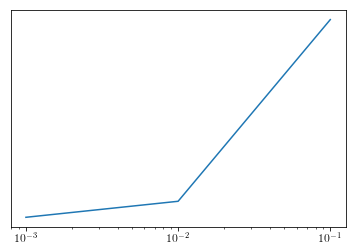

eta= 0.001 mag of gradJ =  3.28391224517e-06 mag d =  8.63939513742e-06 J= 0.000673730175348 incompressible? True mean enstrophy 1.0


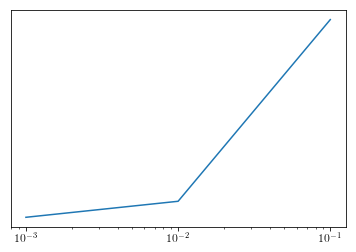

eta= 0.001 mag of gradJ =  3.28282794204e-06 mag d =  8.636218966e-06 J= 0.00067373017535 incompressible? True mean enstrophy 1.0


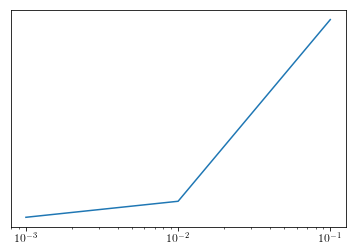

eta= 0.001 mag of gradJ =  3.28174400802e-06 mag d =  8.63304404359e-06 J= 0.000673730175353 incompressible? True mean enstrophy 1.0


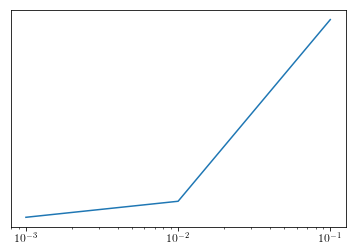

eta= 0.001 mag of gradJ =  3.28066044296e-06 mag d =  8.62987037005e-06 J= 0.000673730175355 incompressible? True mean enstrophy 1.0


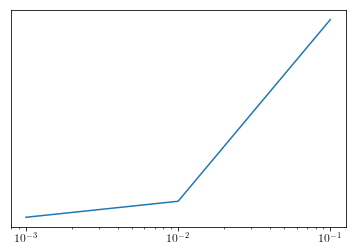

eta= 0.001 mag of gradJ =  3.27957724676e-06 mag d =  8.62669794451e-06 J= 0.000673730175357 incompressible? True mean enstrophy 1.0


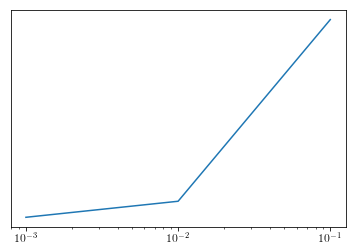

eta= 0.001 mag of gradJ =  3.27849441927e-06 mag d =  8.62352676639e-06 J= 0.000673730175359 incompressible? True mean enstrophy 1.0


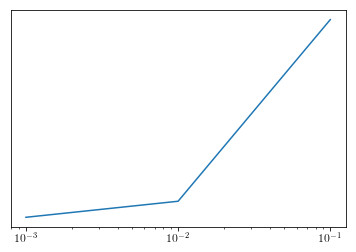

eta= 0.001 mag of gradJ =  3.27741196037e-06 mag d =  8.62035683514e-06 J= 0.000673730175361 incompressible? True mean enstrophy 1.0


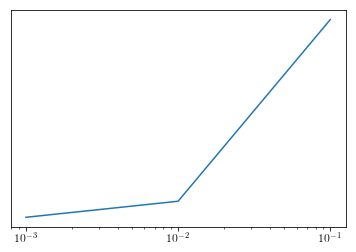

eta= 0.001 mag of gradJ =  3.27632986994e-06 mag d =  8.61718815044e-06 J= 0.000673730175363 incompressible? True mean enstrophy 1.0


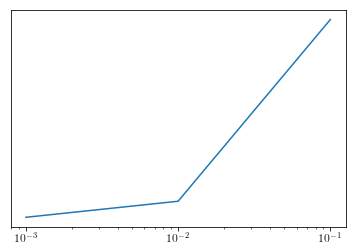

eta= 0.001 mag of gradJ =  3.27524814782e-06 mag d =  8.61402071161e-06 J= 0.000673730175365 incompressible? True mean enstrophy 1.0


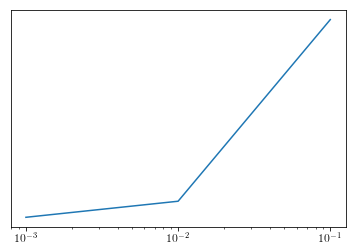

eta= 0.001 mag of gradJ =  3.27416679391e-06 mag d =  8.61085451827e-06 J= 0.000673730175368 incompressible? True mean enstrophy 1.0


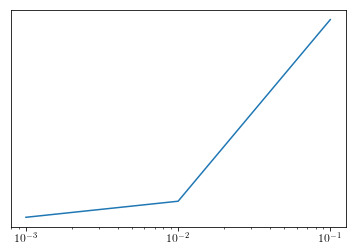

eta= 0.001 mag of gradJ =  3.27308580806e-06 mag d =  8.60768957023e-06 J= 0.00067373017537 incompressible? True mean enstrophy 1.0


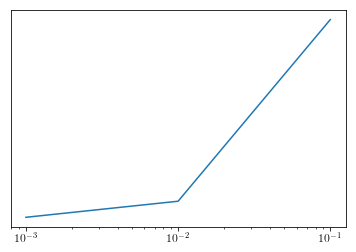

eta= 0.001 mag of gradJ =  3.27200519015e-06 mag d =  8.60452586628e-06 J= 0.000673730175372 incompressible? True mean enstrophy 1.0


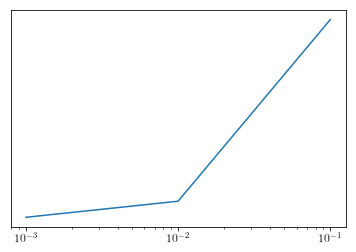

eta= 0.001 mag of gradJ =  3.27092494005e-06 mag d =  8.60136340633e-06 J= 0.000673730175374 incompressible? True mean enstrophy 1.0


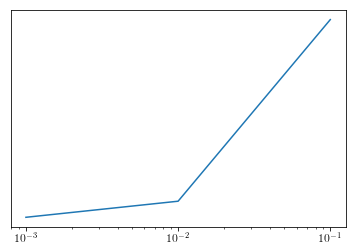

eta= 0.001 mag of gradJ =  3.26984505762e-06 mag d =  8.59820218973e-06 J= 0.000673730175376 incompressible? True mean enstrophy 1.0


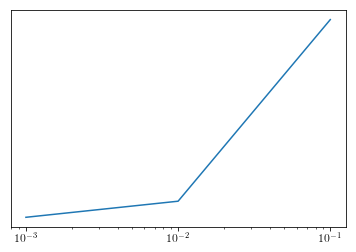

eta= 0.001 mag of gradJ =  3.26876554275e-06 mag d =  8.595042216e-06 J= 0.000673730175379 incompressible? True mean enstrophy 1.0


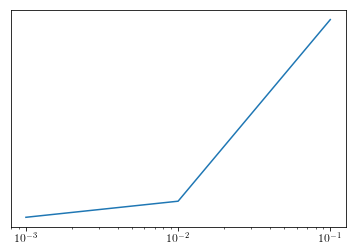

eta= 0.001 mag of gradJ =  3.26768639529e-06 mag d =  8.59188348474e-06 J= 0.000673730175381 incompressible? True mean enstrophy 1.0


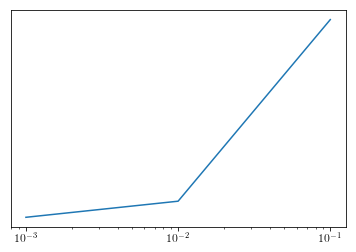

eta= 0.001 mag of gradJ =  3.26660761513e-06 mag d =  8.58872599527e-06 J= 0.000673730175383 incompressible? True mean enstrophy 1.0


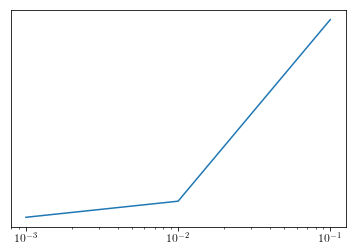

eta= 0.001 mag of gradJ =  3.26552920212e-06 mag d =  8.58556974711e-06 J= 0.000673730175385 incompressible? True mean enstrophy 1.0


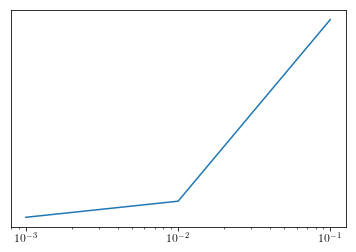

eta= 0.001 mag of gradJ =  3.26445115615e-06 mag d =  8.58241473975e-06 J= 0.000673730175387 incompressible? True mean enstrophy 1.0


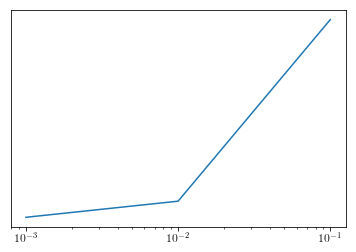

eta= 0.001 mag of gradJ =  3.26337347708e-06 mag d =  8.57926097276e-06 J= 0.00067373017539 incompressible? True mean enstrophy 1.0


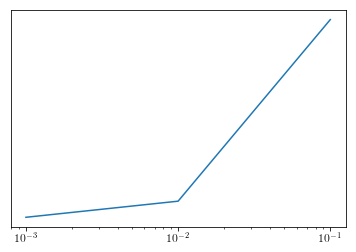

eta= 0.001 mag of gradJ =  3.26229616478e-06 mag d =  8.57610844556e-06 J= 0.000673730175392 incompressible? True mean enstrophy 1.0


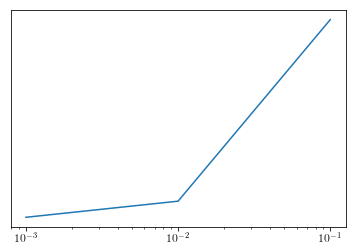

eta= 0.001 mag of gradJ =  3.26121921912e-06 mag d =  8.57295715754e-06 J= 0.000673730175394 incompressible? True mean enstrophy 1.0


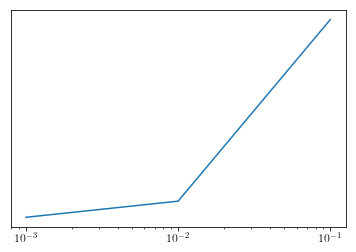

eta= 0.001 mag of gradJ =  3.26014263997e-06 mag d =  8.56980710846e-06 J= 0.000673730175396 incompressible? True mean enstrophy 1.0


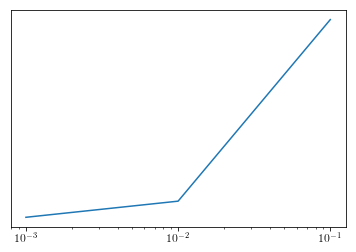

eta= 0.001 mag of gradJ =  3.25906642721e-06 mag d =  8.56665829756e-06 J= 0.000673730175398 incompressible? True mean enstrophy 1.0


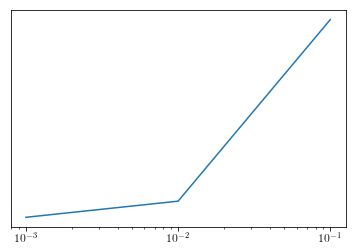

eta= 0.001 mag of gradJ =  3.25799058071e-06 mag d =  8.56351072429e-06 J= 0.000673730175401 incompressible? True mean enstrophy 1.0


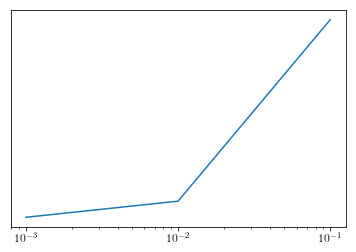

eta= 0.001 mag of gradJ =  3.25691510033e-06 mag d =  8.56036438814e-06 J= 0.000673730175403 incompressible? True mean enstrophy 1.0


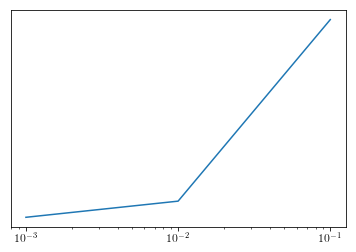

eta= 0.001 mag of gradJ =  3.25583998595e-06 mag d =  8.55721928903e-06 J= 0.000673730175405 incompressible? True mean enstrophy 1.0


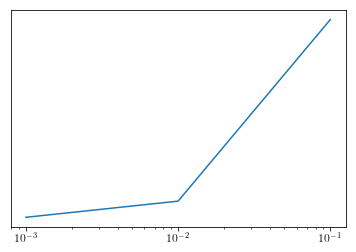

eta= 0.001 mag of gradJ =  3.25476523744e-06 mag d =  8.55407542592e-06 J= 0.000673730175407 incompressible? True mean enstrophy 1.0


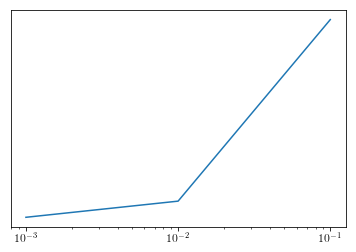

eta= 0.001 mag of gradJ =  3.25369085466e-06 mag d =  8.55093279859e-06 J= 0.00067373017541 incompressible? True mean enstrophy 1.0


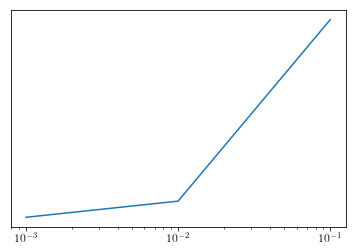

eta= 0.001 mag of gradJ =  3.2526168375e-06 mag d =  8.54779140631e-06 J= 0.000673730175412 incompressible? True mean enstrophy 1.0


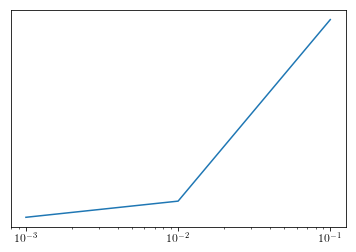

eta= 0.001 mag of gradJ =  3.25154318581e-06 mag d =  8.54465124906e-06 J= 0.000673730175414 incompressible? True mean enstrophy 1.0


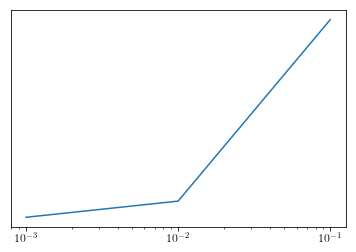

eta= 0.001 mag of gradJ =  3.25046989948e-06 mag d =  8.54151232543e-06 J= 0.000673730175417 incompressible? True mean enstrophy 1.0


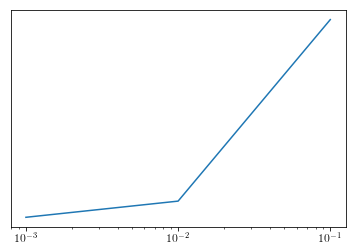

eta= 0.001 mag of gradJ =  3.24939697838e-06 mag d =  8.53837463553e-06 J= 0.000673730175419 incompressible? True mean enstrophy 1.0


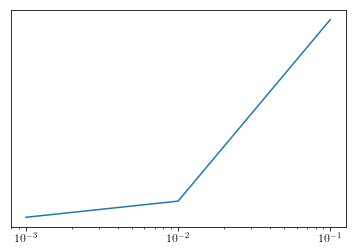

eta= 0.001 mag of gradJ =  3.24832442237e-06 mag d =  8.53523817905e-06 J= 0.000673730175421 incompressible? True mean enstrophy 1.0


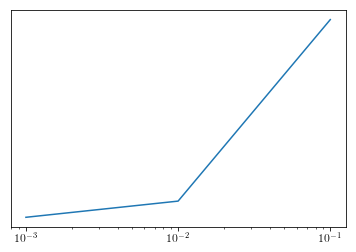

eta= 0.001 mag of gradJ =  3.24725223133e-06 mag d =  8.53210295504e-06 J= 0.000673730175423 incompressible? True mean enstrophy 1.0


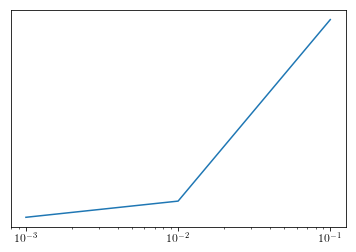

eta= 0.001 mag of gradJ =  3.24618040512e-06 mag d =  8.52896896324e-06 J= 0.000673730175426 incompressible? True mean enstrophy 1.0


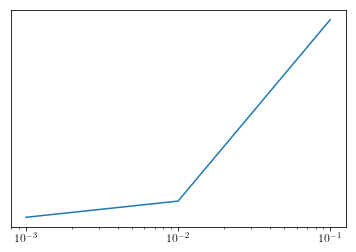

eta= 0.001 mag of gradJ =  3.24510894362e-06 mag d =  8.52583620295e-06 J= 0.000673730175428 incompressible? True mean enstrophy 1.0


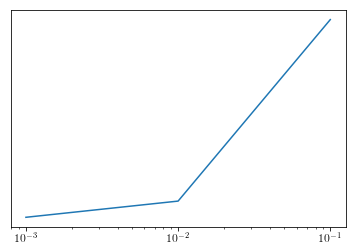

eta= 0.001 mag of gradJ =  3.2440378467e-06 mag d =  8.52270467381e-06 J= 0.00067373017543 incompressible? True mean enstrophy 1.0


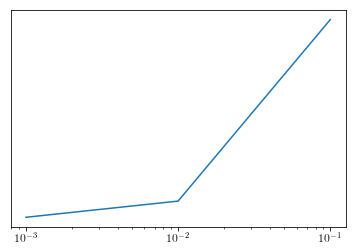

eta= 0.001 mag of gradJ =  3.24296711423e-06 mag d =  8.51957437521e-06 J= 0.000673730175433 incompressible? True mean enstrophy 1.0


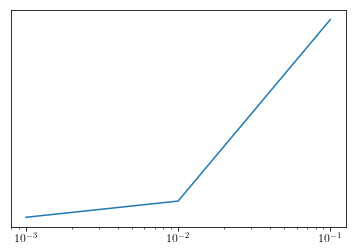

eta= 0.001 mag of gradJ =  3.24189674609e-06 mag d =  8.51644530657e-06 J= 0.000673730175435 incompressible? True mean enstrophy 1.0


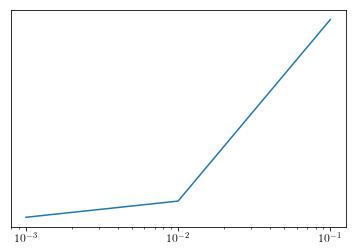

eta= 0.001 mag of gradJ =  3.24082674215e-06 mag d =  8.51331746755e-06 J= 0.000673730175437 incompressible? True mean enstrophy 1.0


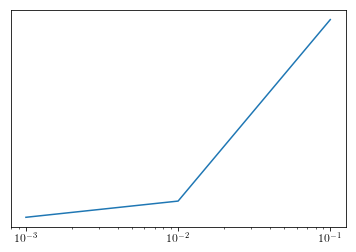

eta= 0.001 mag of gradJ =  3.23975710226e-06 mag d =  8.51019085779e-06 J= 0.00067373017544 incompressible? True mean enstrophy 1.0


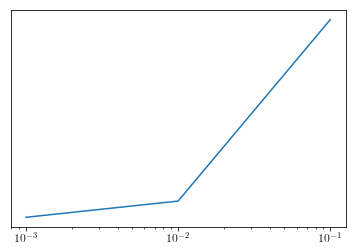

eta= 0.001 mag of gradJ =  3.23868782632e-06 mag d =  8.50706547632e-06 J= 0.000673730175442 incompressible? True mean enstrophy 1.0


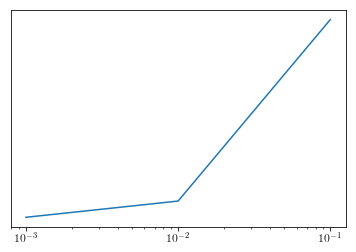

eta= 0.001 mag of gradJ =  3.23761891419e-06 mag d =  8.50394132276e-06 J= 0.000673730175444 incompressible? True mean enstrophy 1.0


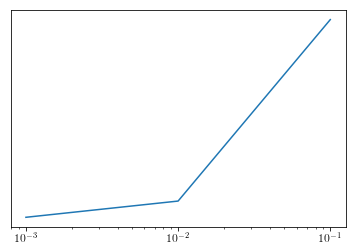

eta= 0.001 mag of gradJ =  3.23655036574e-06 mag d =  8.50081839714e-06 J= 0.000673730175447 incompressible? True mean enstrophy 1.0


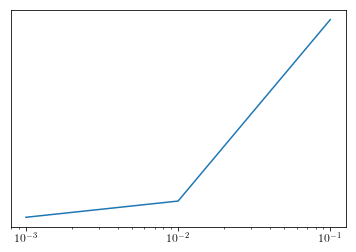

eta= 0.001 mag of gradJ =  3.23548218084e-06 mag d =  8.49769669833e-06 J= 0.000673730175449 incompressible? True mean enstrophy 1.0


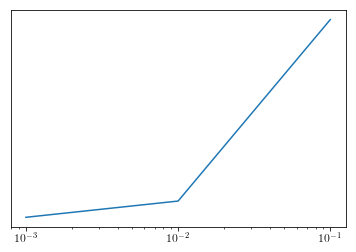

eta= 0.001 mag of gradJ =  3.23441435937e-06 mag d =  8.49457622606e-06 J= 0.000673730175451 incompressible? True mean enstrophy 1.0


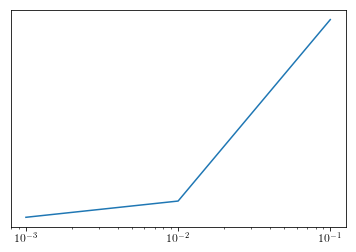

eta= 0.001 mag of gradJ =  3.2333469012e-06 mag d =  8.49145697967e-06 J= 0.000673730175454 incompressible? True mean enstrophy 1.0


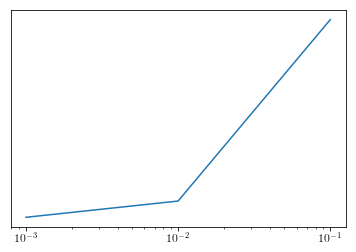

eta= 0.001 mag of gradJ =  3.2322798062e-06 mag d =  8.48833895869e-06 J= 0.000673730175456 incompressible? True mean enstrophy 1.0


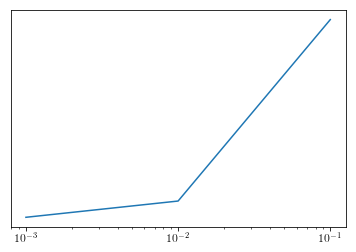

eta= 0.001 mag of gradJ =  3.23121307424e-06 mag d =  8.48522216305e-06 J= 0.000673730175458 incompressible? True mean enstrophy 1.0


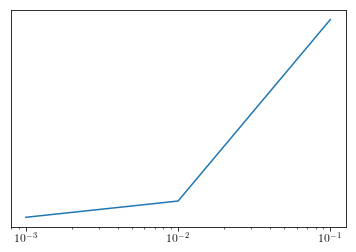

eta= 0.001 mag of gradJ =  3.23014670519e-06 mag d =  8.48210659167e-06 J= 0.000673730175461 incompressible? True mean enstrophy 1.0


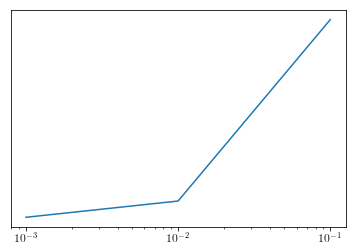

eta= 0.001 mag of gradJ =  3.22908069893e-06 mag d =  8.47899224426e-06 J= 0.000673730175463 incompressible? True mean enstrophy 1.0


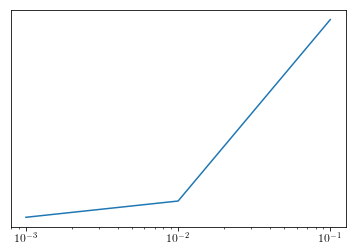

eta= 0.001 mag of gradJ =  3.22801505533e-06 mag d =  8.47587912022e-06 J= 0.000673730175466 incompressible? True mean enstrophy 1.0


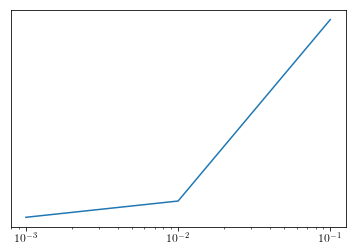

eta= 0.001 mag of gradJ =  3.22694977426e-06 mag d =  8.4727672193e-06 J= 0.000673730175468 incompressible? True mean enstrophy 1.0


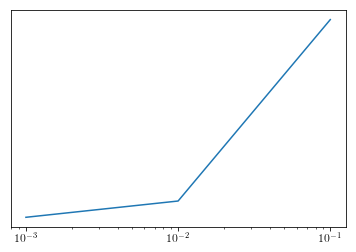

eta= 0.001 mag of gradJ =  3.22588485558e-06 mag d =  8.4696565408e-06 J= 0.00067373017547 incompressible? True mean enstrophy 1.0


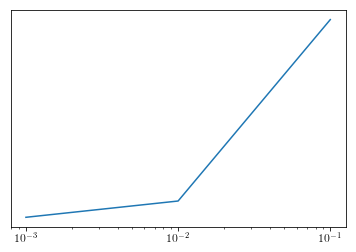

eta= 0.001 mag of gradJ =  3.22482029919e-06 mag d =  8.4665470842e-06 J= 0.000673730175473 incompressible? True mean enstrophy 1.0


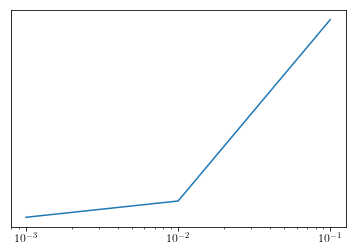

eta= 0.001 mag of gradJ =  3.22375610494e-06 mag d =  8.46343884915e-06 J= 0.000673730175475 incompressible? True mean enstrophy 1.0


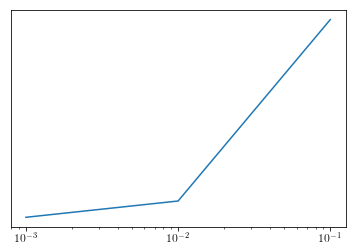

eta= 0.001 mag of gradJ =  3.22269227272e-06 mag d =  8.46033183473e-06 J= 0.000673730175478 incompressible? True mean enstrophy 1.0


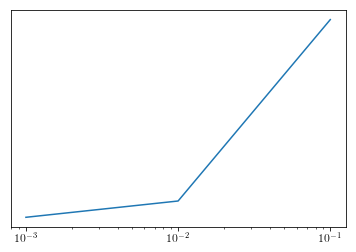

eta= 0.001 mag of gradJ =  3.22162880237e-06 mag d =  8.45722604128e-06 J= 0.00067373017548 incompressible? True mean enstrophy 1.0


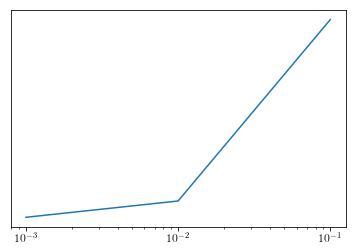

eta= 0.001 mag of gradJ =  3.2205656938e-06 mag d =  8.45412146725e-06 J= 0.000673730175482 incompressible? True mean enstrophy 1.0


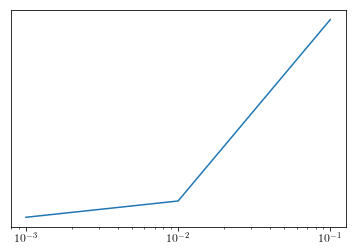

eta= 0.001 mag of gradJ =  3.21950294687e-06 mag d =  8.45101811271e-06 J= 0.000673730175485 incompressible? True mean enstrophy 1.0


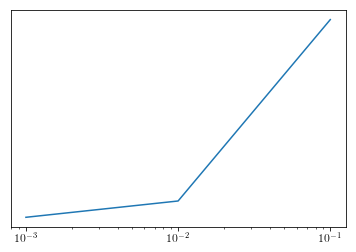

eta= 0.001 mag of gradJ =  3.21844056144e-06 mag d =  8.44791597712e-06 J= 0.000673730175487 incompressible? True mean enstrophy 1.0


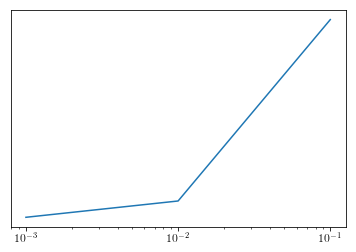

eta= 0.001 mag of gradJ =  3.2173785374e-06 mag d =  8.44481506001e-06 J= 0.00067373017549 incompressible? True mean enstrophy 1.0


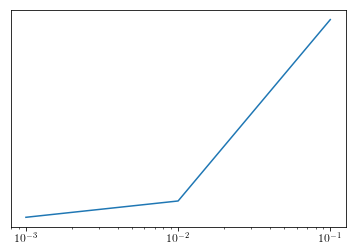

eta= 0.001 mag of gradJ =  3.21631687461e-06 mag d =  8.44171536068e-06 J= 0.000673730175492 incompressible? True mean enstrophy 1.0


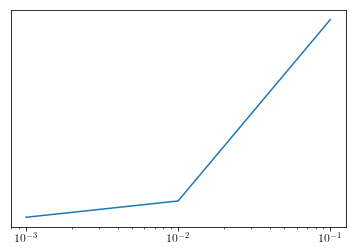

eta= 0.001 mag of gradJ =  3.21525557295e-06 mag d =  8.43861687886e-06 J= 0.000673730175495 incompressible? True mean enstrophy 1.0


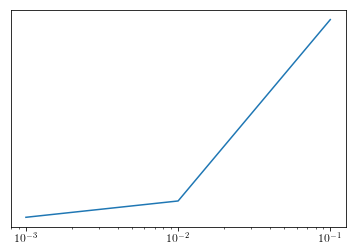

eta= 0.001 mag of gradJ =  3.21419463229e-06 mag d =  8.43551961401e-06 J= 0.000673730175497 incompressible? True mean enstrophy 1.0


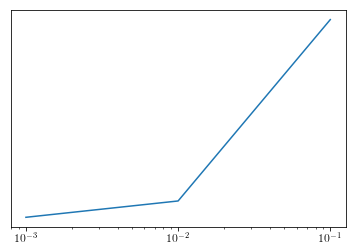

eta= 0.001 mag of gradJ =  3.21313405251e-06 mag d =  8.43242356538e-06 J= 0.000673730175499 incompressible? True mean enstrophy 1.0


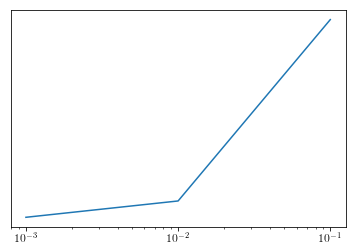

eta= 0.001 mag of gradJ =  3.21207383347e-06 mag d =  8.42932873249e-06 J= 0.000673730175502 incompressible? True mean enstrophy 1.0


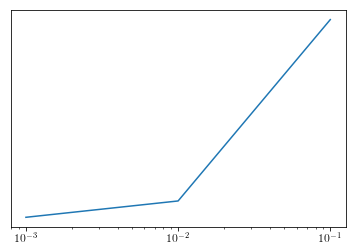

eta= 0.001 mag of gradJ =  3.21101397504e-06 mag d =  8.42623511542e-06 J= 0.000673730175504 incompressible? True mean enstrophy 1.0


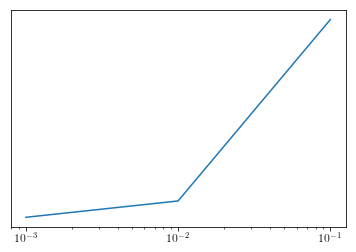

eta= 0.001 mag of gradJ =  3.20995447711e-06 mag d =  8.42314271312e-06 J= 0.000673730175507 incompressible? True mean enstrophy 1.0


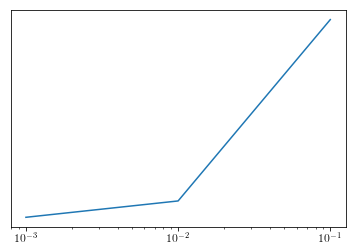

eta= 0.001 mag of gradJ =  3.20889533954e-06 mag d =  8.420051525e-06 J= 0.000673730175509 incompressible? True mean enstrophy 1.0


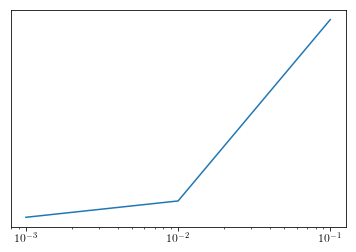

eta= 0.001 mag of gradJ =  3.20783656221e-06 mag d =  8.41696155097e-06 J= 0.000673730175512 incompressible? True mean enstrophy 1.0


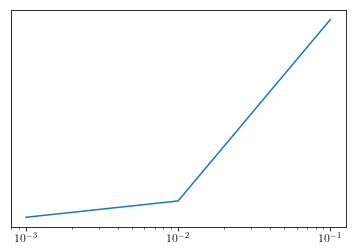

eta= 0.001 mag of gradJ =  3.206778145e-06 mag d =  8.41387279002e-06 J= 0.000673730175514 incompressible? True mean enstrophy 1.0


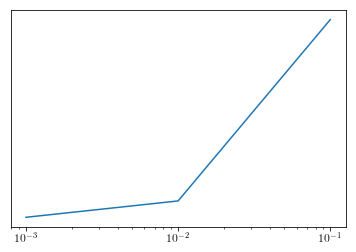

eta= 0.001 mag of gradJ =  3.20572008777e-06 mag d =  8.41078524198e-06 J= 0.000673730175517 incompressible? True mean enstrophy 1.0


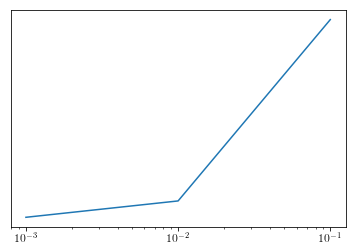

eta= 0.001 mag of gradJ =  3.20466239039e-06 mag d =  8.40769890648e-06 J= 0.000673730175519 incompressible? True mean enstrophy 1.0


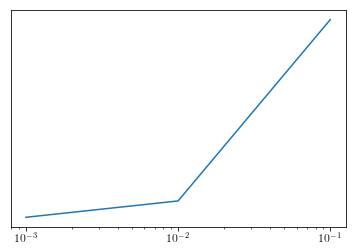

eta= 0.001 mag of gradJ =  3.20360505275e-06 mag d =  8.40461378278e-06 J= 0.000673730175522 incompressible? True mean enstrophy 1.0


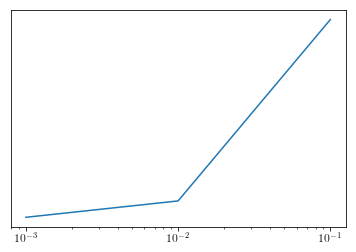

eta= 0.001 mag of gradJ =  3.20254807471e-06 mag d =  8.40152987039e-06 J= 0.000673730175524 incompressible? True mean enstrophy 1.0


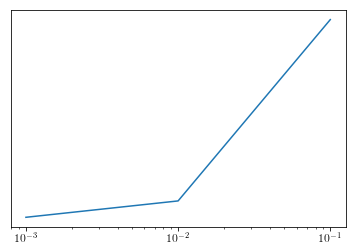

eta= 0.001 mag of gradJ =  3.20149145615e-06 mag d =  8.39844716879e-06 J= 0.000673730175527 incompressible? True mean enstrophy 1.0


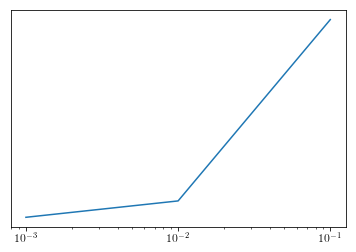

eta= 0.001 mag of gradJ =  3.20043519694e-06 mag d =  8.39536567772e-06 J= 0.000673730175529 incompressible? True mean enstrophy 1.0


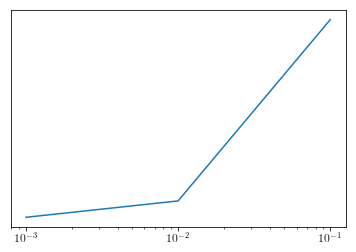

eta= 0.001 mag of gradJ =  3.19937929695e-06 mag d =  8.39228539649e-06 J= 0.000673730175532 incompressible? True mean enstrophy 1.0


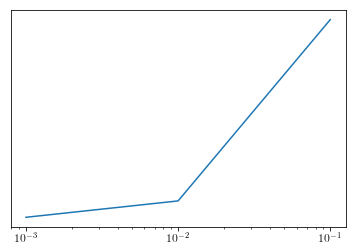

eta= 0.001 mag of gradJ =  3.19832375606e-06 mag d =  8.38920632456e-06 J= 0.000673730175534 incompressible? True mean enstrophy 1.0


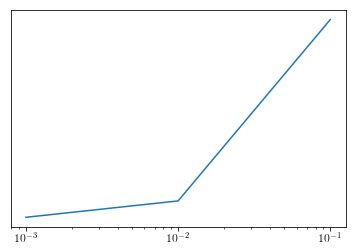

eta= 0.001 mag of gradJ =  3.19726857414e-06 mag d =  8.3861284617e-06 J= 0.000673730175537 incompressible? True mean enstrophy 1.0


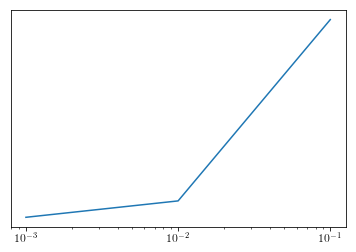

eta= 0.001 mag of gradJ =  3.19621375106e-06 mag d =  8.38305180685e-06 J= 0.00067373017554 incompressible? True mean enstrophy 1.0


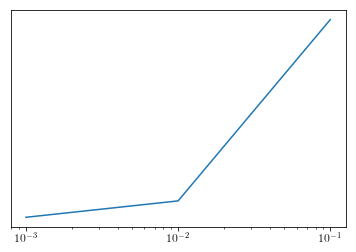

eta= 0.001 mag of gradJ =  3.19515928671e-06 mag d =  8.37997635999e-06 J= 0.000673730175542 incompressible? True mean enstrophy 1.0


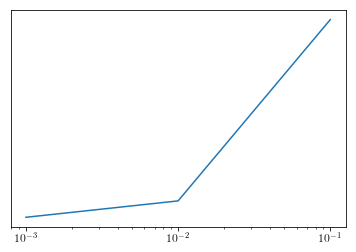

eta= 0.001 mag of gradJ =  3.19410518094e-06 mag d =  8.37690212056e-06 J= 0.000673730175545 incompressible? True mean enstrophy 1.0


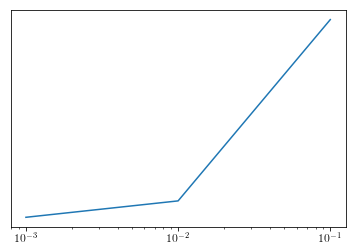

eta= 0.001 mag of gradJ =  3.19305143364e-06 mag d =  8.37382908783e-06 J= 0.000673730175547 incompressible? True mean enstrophy 1.0


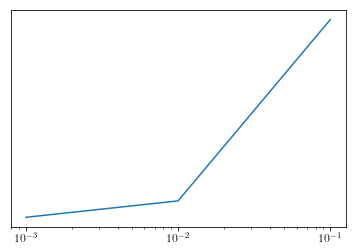

eta= 0.001 mag of gradJ =  3.19199804468e-06 mag d =  8.37075726153e-06 J= 0.00067373017555 incompressible? True mean enstrophy 1.0


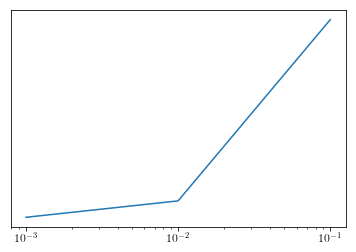

eta= 0.001 mag of gradJ =  3.19094501394e-06 mag d =  8.36768664117e-06 J= 0.000673730175552 incompressible? True mean enstrophy 1.0


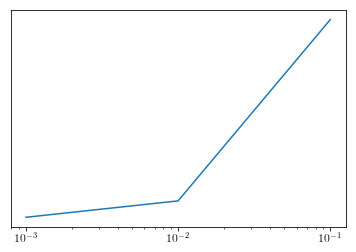

eta= 0.001 mag of gradJ =  3.18989234128e-06 mag d =  8.36461722608e-06 J= 0.000673730175555 incompressible? True mean enstrophy 1.0


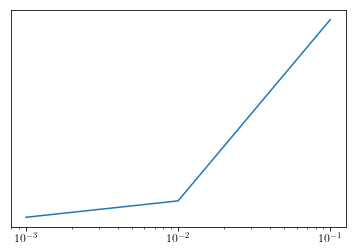

eta= 0.001 mag of gradJ =  3.18884002658e-06 mag d =  8.36154901577e-06 J= 0.000673730175557 incompressible? True mean enstrophy 1.0


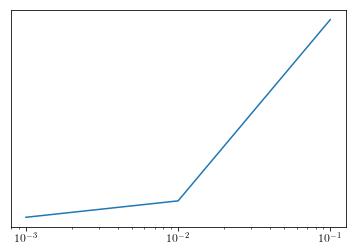

eta= 0.001 mag of gradJ =  3.18778806971e-06 mag d =  8.35848200996e-06 J= 0.00067373017556 incompressible? True mean enstrophy 1.0


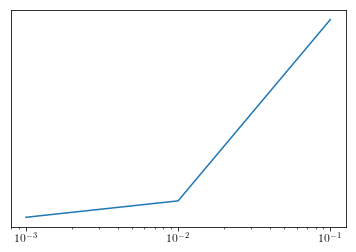

eta= 0.001 mag of gradJ =  3.18673647056e-06 mag d =  8.35541620814e-06 J= 0.000673730175563 incompressible? True mean enstrophy 1.0


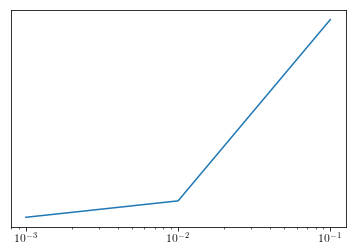

eta= 0.001 mag of gradJ =  3.18568522899e-06 mag d =  8.35235160928e-06 J= 0.000673730175565 incompressible? True mean enstrophy 1.0


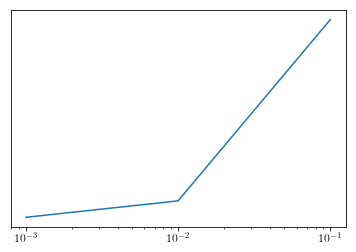

eta= 0.001 mag of gradJ =  3.18463434487e-06 mag d =  8.34928821355e-06 J= 0.000673730175568 incompressible? True mean enstrophy 1.0


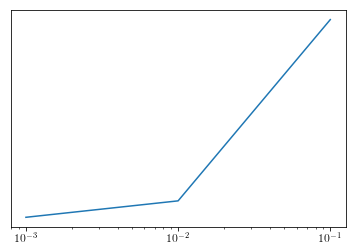

eta= 0.001 mag of gradJ =  3.18358381809e-06 mag d =  8.34622602018e-06 J= 0.00067373017557 incompressible? True mean enstrophy 1.0


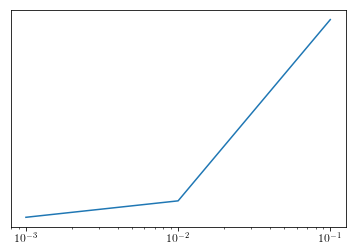

eta= 0.001 mag of gradJ =  3.18253364851e-06 mag d =  8.34316502873e-06 J= 0.000673730175573 incompressible? True mean enstrophy 1.0


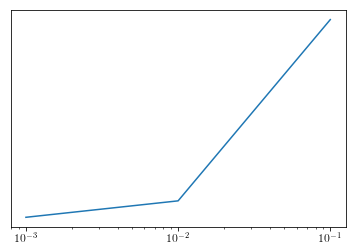

eta= 0.001 mag of gradJ =  3.18148383601e-06 mag d =  8.34010523847e-06 J= 0.000673730175576 incompressible? True mean enstrophy 1.0


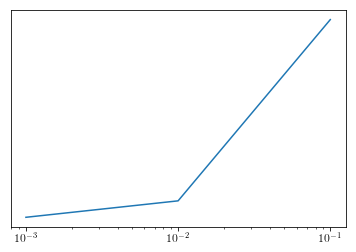

eta= 0.001 mag of gradJ =  3.18043438046e-06 mag d =  8.33704664916e-06 J= 0.000673730175578 incompressible? True mean enstrophy 1.0


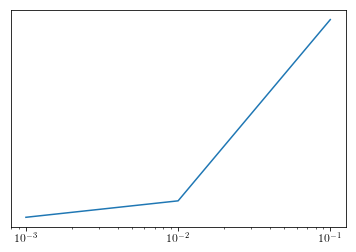

eta= 0.001 mag of gradJ =  3.17938528174e-06 mag d =  8.33398926052e-06 J= 0.000673730175581 incompressible? True mean enstrophy 1.0


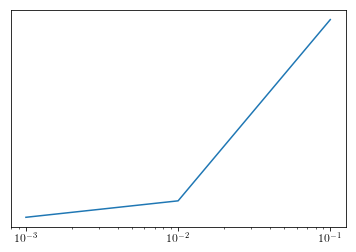

eta= 0.001 mag of gradJ =  3.17833653972e-06 mag d =  8.3309330712e-06 J= 0.000673730175583 incompressible? True mean enstrophy 1.0


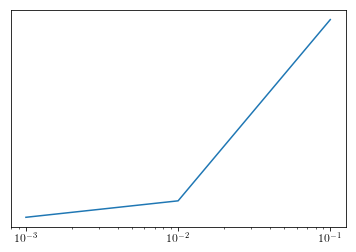

eta= 0.001 mag of gradJ =  3.17728815428e-06 mag d =  8.32787808164e-06 J= 0.000673730175586 incompressible? True mean enstrophy 1.0


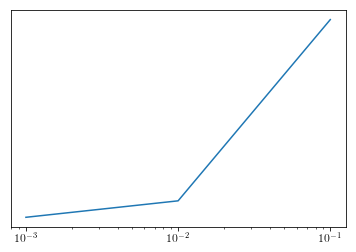

eta= 0.001 mag of gradJ =  3.17624012529e-06 mag d =  8.32482429098e-06 J= 0.000673730175589 incompressible? True mean enstrophy 1.0


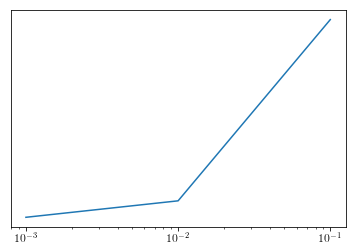

eta= 0.001 mag of gradJ =  3.17519245262e-06 mag d =  8.32177169872e-06 J= 0.000673730175591 incompressible? True mean enstrophy 1.0


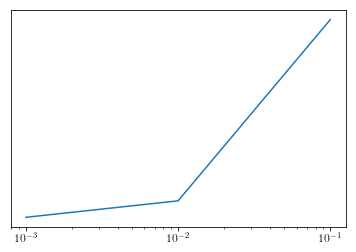

eta= 0.001 mag of gradJ =  3.17414513616e-06 mag d =  8.31872030414e-06 J= 0.000673730175594 incompressible? True mean enstrophy 1.0


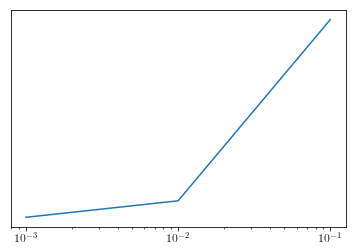

eta= 0.001 mag of gradJ =  3.17309817577e-06 mag d =  8.31567010702e-06 J= 0.000673730175597 incompressible? True mean enstrophy 1.0


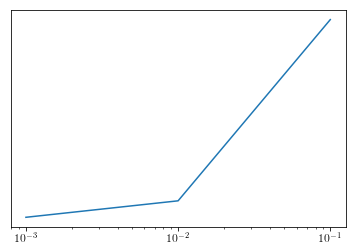

eta= 0.001 mag of gradJ =  3.17205157133e-06 mag d =  8.31262110687e-06 J= 0.000673730175599 incompressible? True mean enstrophy 1.0


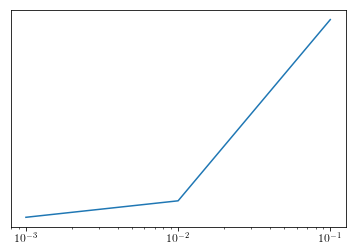

eta= 0.001 mag of gradJ =  3.17100532271e-06 mag d =  8.30957330332e-06 J= 0.000673730175602 incompressible? True mean enstrophy 1.0


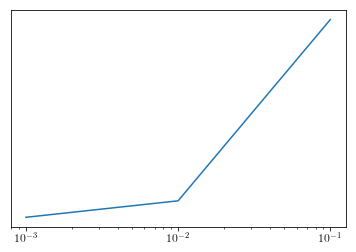

eta= 0.001 mag of gradJ =  3.16995942979e-06 mag d =  8.30652669548e-06 J= 0.000673730175605 incompressible? True mean enstrophy 1.0


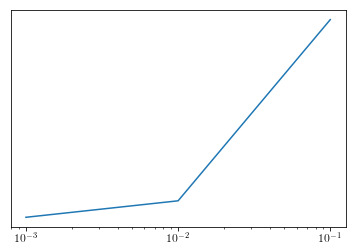

eta= 0.001 mag of gradJ =  3.16891389245e-06 mag d =  8.30348128297e-06 J= 0.000673730175607 incompressible? True mean enstrophy 1.0


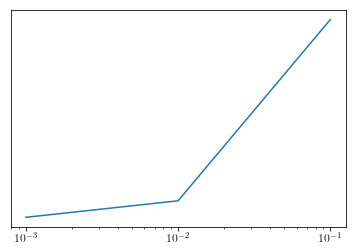

eta= 0.001 mag of gradJ =  3.16786871055e-06 mag d =  8.30043706537e-06 J= 0.00067373017561 incompressible? True mean enstrophy 1.0


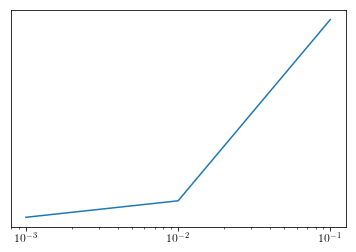

eta= 0.001 mag of gradJ =  3.16682388398e-06 mag d =  8.2973940423e-06 J= 0.000673730175613 incompressible? True mean enstrophy 1.0


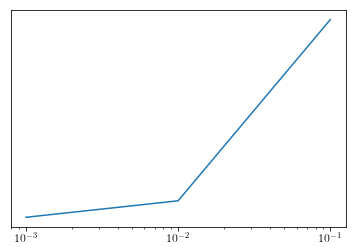

eta= 0.001 mag of gradJ =  3.16577941261e-06 mag d =  8.29435221317e-06 J= 0.000673730175615 incompressible? True mean enstrophy 1.0


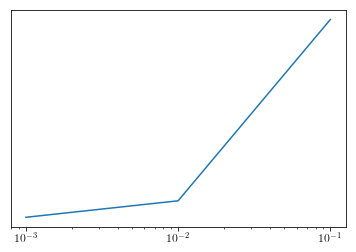

eta= 0.001 mag of gradJ =  3.16473529629e-06 mag d =  8.29131157774e-06 J= 0.000673730175618 incompressible? True mean enstrophy 1.0


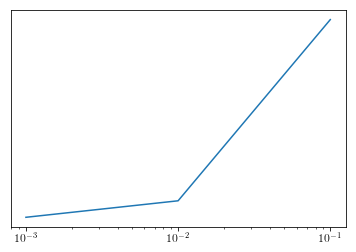

eta= 0.001 mag of gradJ =  3.16369153494e-06 mag d =  8.2882721348e-06 J= 0.000673730175621 incompressible? True mean enstrophy 1.0


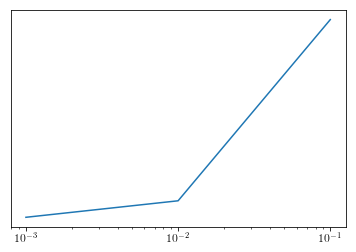

eta= 0.001 mag of gradJ =  3.16264812841e-06 mag d =  8.28523388475e-06 J= 0.000673730175623 incompressible? True mean enstrophy 1.0


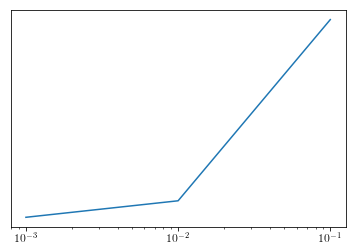

eta= 0.001 mag of gradJ =  3.16160507657e-06 mag d =  8.28219682625e-06 J= 0.000673730175626 incompressible? True mean enstrophy 1.0


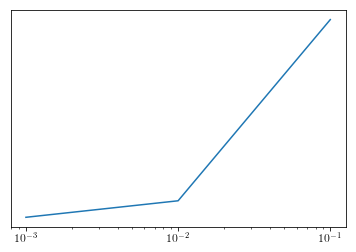

eta= 0.001 mag of gradJ =  3.16056237932e-06 mag d =  8.27916095931e-06 J= 0.000673730175629 incompressible? True mean enstrophy 1.0


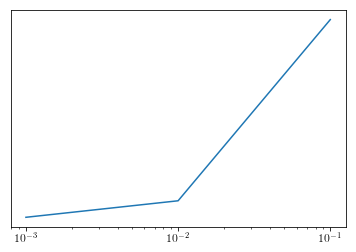

eta= 0.001 mag of gradJ =  3.15952003649e-06 mag d =  8.27612628372e-06 J= 0.000673730175631 incompressible? True mean enstrophy 1.0


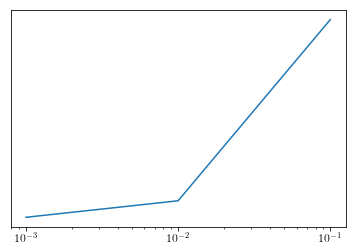

eta= 0.001 mag of gradJ =  3.15847804801e-06 mag d =  8.27309279814e-06 J= 0.000673730175634 incompressible? True mean enstrophy 1.0


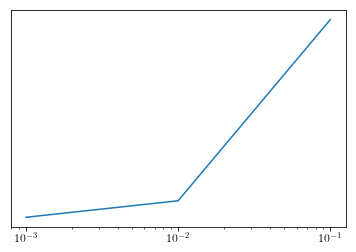

eta= 0.001 mag of gradJ =  3.15743641372e-06 mag d =  8.27006050276e-06 J= 0.000673730175637 incompressible? True mean enstrophy 1.0


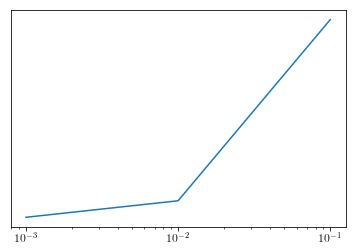

eta= 0.001 mag of gradJ =  3.1563951335e-06 mag d =  8.26702939681e-06 J= 0.00067373017564 incompressible? True mean enstrophy 1.0


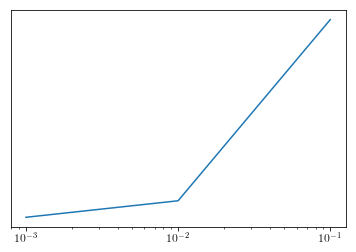

eta= 0.001 mag of gradJ =  3.15535420722e-06 mag d =  8.26399948e-06 J= 0.000673730175642 incompressible? True mean enstrophy 1.0


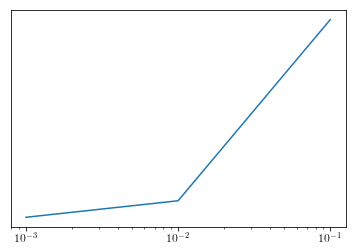

eta= 0.001 mag of gradJ =  3.15431363478e-06 mag d =  8.26097075168e-06 J= 0.000673730175645 incompressible? True mean enstrophy 1.0


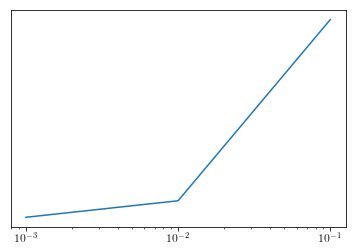

eta= 0.001 mag of gradJ =  3.15327341604e-06 mag d =  8.25794321117e-06 J= 0.000673730175648 incompressible? True mean enstrophy 1.0


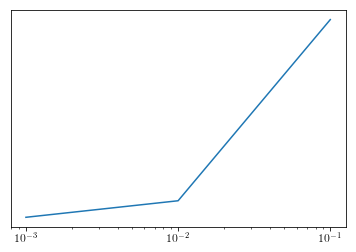

eta= 0.001 mag of gradJ =  3.15223355087e-06 mag d =  8.2549168585e-06 J= 0.000673730175651 incompressible? True mean enstrophy 1.0


KeyboardInterrupt: 

In [13]:
eta_array = np.array([0.1,.01,0.001])
num_iterations = 500
for i in range(num_iterations):
    gradJ, J = compute_gradJ_and_J(u)
    #d = -gradJ
    d = compute_d(u)
    #d = d / dot(d,d)**0.5
    eta = line_search(u,d,eta_array)
    u = normalize(div_free_proj(dealias(u + eta*d)))
    print('eta=',eta, 
          'mag of gradJ = ',dot(gradJ,gradJ)**0.5,
          'mag d = ', dot(d,d)**0.5,
          'J=',J,
          'incompressible?',is_incompressible(u),
          'mean enstrophy',mean_enstrophy(u))



In [11]:
usave = copy.copy(u)

In [14]:
pickle_file = 'git_u.pkl'
output = open(pickle_file, 'wb')
sol_save = {}
sol_save['N'] = N
sol_save['M'] = M
sol_save['L'] = L
sol_save['T'] = T
sol_save['h'] = L/N
sol_save['dt'] = T/M
sol_save['kappa'] = kappa
sol_save['gamma'] = gamma
sol_save['u'] = u

pickle.dump(sol_save,output)


In [51]:
u = copy.copy(usave)

In [ ]:
d = d / dot(d,d)**0.5
print(dot(d,d)**0.5)

In [ ]:
eta_array = 2**(-np.linspace(5,15,4))
eta_array = np.array([0.005,0.001,0.0005,0.0001])
print(eta_array)

In [ ]:
M_list = [100,200,400]
th_list = []
i = -1
for M in M_list:
    T = 0.1
    dt = T/(M-1)
    u = np.zeros((M,2,N,N))
    u[:,0] = 5.0*np.sin(2.*np.pi/L*st.X[1])
    th = integrate_forward(u,th0)
    th_list.append(th)
    st.plot(th[i])
    plt.show()
    vt.plot(u[i])
    plt.show()

err1 = st.l2norm(th_list[0][i]-th_list[1][i])
err2 = st.l2norm(th_list[1][i]-th_list[2][i])
print(np.log(err1/err2)/np.log(2))
err = np.array([err1,err2])
print(err)
m = np.array([1,0.5])
plt.loglog(m,err)
plt.loglog(m,err[0]*m**2/m[0]**2, label='predicted')
plt.legend()


In [31]:
gradJ, J = compute_gradJ_and_J(u)

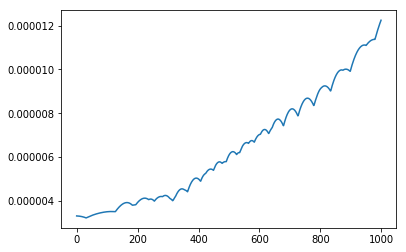

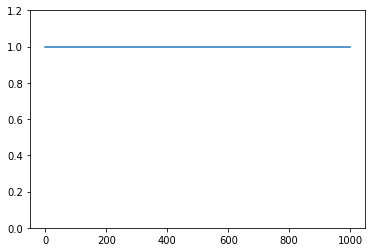

In [47]:
magJ =[]
enstrophy = []
for i in range(M):
    magJ.append(np.amax(gradJ[i]))
    enstrophy.append(vt.h1norm(u[i]))
    
plt.plot(magJ)
plt.show()
plt.plot(enstrophy)
plt.ylim([0,1.2])
plt.show()

In [6]:
import os    
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)
output_path='output_git/'
os.system('mkdir ' + output_path)
os.system('rm ' + output_path + 'images/*')
os.system('mkdir ' + output_path + 'images/')
    
N_grid = 512
st_grid = tools.ScalarTool(N_grid,L)
th_git = np.zeros((M,N,N))
th_git[0]=th0
u_git = copy.copy(u)
count = 0
for i in range(M-1):
    th_git[i+1] = th_git[i] + dt * f(th_git[i],u_git[i])
#     if np.mod(i,1)==0:
#         fig = plt.figure()
#         st_grid.plot(increase_res(th_git[i],N_grid),high_quality=True)
#         #st.plot(th[i])
#         plt.title('Time = %.3f' % time_array[i])
#         plt.savefig(output_path + 'images/' + "image%.4d.png" %
#                     count, format='png',dpi=300)
#         plt.show()
        
#         vt.plot(u_git[i])
#         plt.show()
#         count += 1
        
# os.system("ffmpeg -y -framerate 20 -i " + output_path + 'images/'
#           "image%04d.png -c:v libx264 -pix_fmt yuv420p " + output_path + "movie.mp4")

In [7]:
hm1norm_hist_git = np.zeros(M)
l2norm_hist_git = np.zeros(M)
u_h1norm_hist_git = np.zeros(M)

for i in range(M):
    hm1norm_hist_git[i] = st.hm1norm(th_git[i])
    l2norm_hist_git[i]= st.l2norm(th_git[i])
    u_h1norm_hist_git[i] = st.l2norm(vt.curl(u_git[i]))

In [8]:
N_grid = 512
st_grid = tools.ScalarTool(N_grid,L)

sol_lit = lit.sim(N=N,M=M-1,Pe = np.inf,plot=False,T=T,save_th_every=1,save_u_every=1)
u_lit = np.array(sol_lit.hist_u)
time_array = np.array(sol_lit.hist_u_time)
th_lit = np.array(sol_lit.hist_th)

for i in range(M-1):
    th_lit[i+1] = th_lit[i] + dt * f(th_lit[i],u_lit[i])
#     if np.mod(i,10)==0:
#         st_grid.plot(increase_res(th_lit[i],N_grid))
# #         plt.savefig(output_path + 'images/' + "image%.4d.png" %
# #             i, format='png')
#         #st.plot(th[i])
#         plt.show()
#         vt.plot(u_lit[i])
#         #plt.title('time = ' , time_array[i])
#         plt.show()
        

dt =  0.003003003003003003


In [9]:
hm1norm_hist_lit = np.zeros(M)
l2norm_hist_lit = np.zeros(M)
u_h1norm_hist_lit = np.zeros(M)

for i in range(M):
    hm1norm_hist_lit[i] = st.hm1norm(th_lit[i])
    l2norm_hist_lit[i]= st.l2norm(th_lit[i])
    u_h1norm_hist_lit[i] = st.l2norm(vt.curl(u_lit[i]))

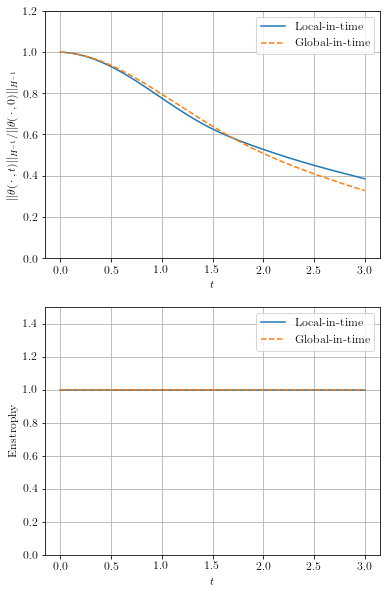

In [12]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 

plt.figure(figsize = (6,10))
plt.subplot(211)
plt.plot(time_array,hm1norm_hist_lit/hm1norm_hist_lit[0],label='Local-in-time')
plt.plot(time_array,hm1norm_hist_git/hm1norm_hist_git[0],label='Global-in-time',linestyle = '--')
plt.legend()
plt.ylabel('$\| \\theta(\,\cdot\,,t)\|_{H^{-1}} / \| \\theta(\,\cdot\,,0)\|_{H^{-1}}$')
plt.xlabel('$t$')
plt.grid('on')
plt.ylim([0,1.2])


# plt.figure()
# plt.plot(time_array,l2norm_hist_lit,label = 'LIT')
# plt.plot(time_array,l2norm_hist_git,label = 'GIT')
# plt.ylim([0,1.5*max(l2norm_hist_lit)])
# plt.legend()

plt.subplot(212)
plt.plot(time_array,u_h1norm_hist_lit**2.,label = 'Local-in-time')
plt.plot(time_array,u_h1norm_hist_git**2.,label = 'Global-in-time', linestyle = '--')
plt.ylim([0,1.5*max(u_h1norm_hist_lit)])
plt.legend()
plt.xlabel('$t$')
plt.ylabel('Enstrophy')
plt.grid('on')
plt.savefig('lit_vs_git_N64_T3p0_kappa0_L1_gamma1p0.eps',format='eps',dpi=300)
plt.show()

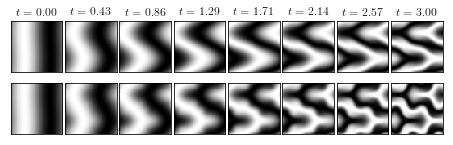

In [12]:
cmap = plt.cm.gray

pe_ind = 4
#final_time = (time_inf[ind_inf])
final_time = T
num_frames = 8

times2plot = np.linspace(time_array[0],final_time,num_frames)
indicies2plot_u= [ np.abs(time_array - times2plot[i]).argmin() for i in range(len(times2plot))] 
indicies2plot_l= [ np.abs(time_array - times2plot[i]).argmin() for i in range(len(times2plot))] 
#ind = np.abs(l2 - 10.0**(-12)).argmin()
#(tsteps,N,_) = np.shape(th_hist)
#st= ScalarTool(N,L)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=10)

fig_width = 6
fig_height = 2.1*fig_width/num_frames

f, (axes_u,axes_l) = plt.subplots(2,len(indicies2plot_l),sharey = True,figsize=(fig_width,fig_height))

end_ind_u=indicies2plot_u[-1]
    
for i,index in enumerate(indicies2plot_u):
    if index <= end_ind_u:
        im = axes_u[i].imshow(np.transpose(th_lit[index]),
                        cmap=cmap,
                        extent=(0, L, 0, L),
                        origin="lower",
                             vmin = -1.0,
                             vmax = 1.0)
    else:
        axes_u[i].get_xaxis().set_visible(False)
        axes_u[i].get_yaxis().set_visible(False)
        axes_u[i].axis('off')
        
    axes_u[i].set_xticks([])
    axes_u[i].set_yticks([])
    
    

    
    
for i,index in enumerate(indicies2plot_l):
    im = axes_l[i].imshow(np.transpose(th_git[index]),
                    cmap=cmap,
                    extent=(0, L, 0, L),
                    origin="lower")
    axes_l[i].set_xticks([])
    axes_l[i].set_yticks([])
    #axes_l[i].set_title('$t = %.2f $' % time[index])
    axes_u[i].set_title('$t = %.2f $' % time_array[index])

f.subplots_adjust(wspace = 0.05, bottom=0.0, left=0.0, top = 1.0, right=1.0)
plt.savefig('film.eps',dpi = 300, format = 'eps',bbox_inches='tight')


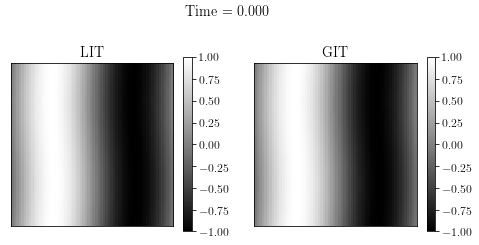

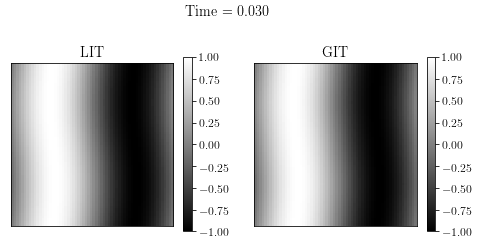

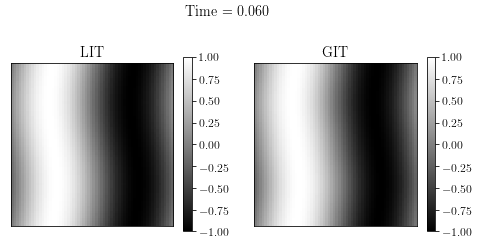

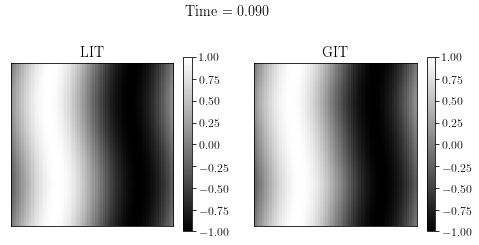

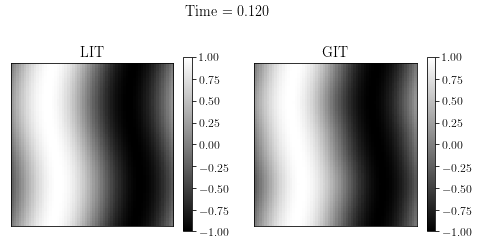

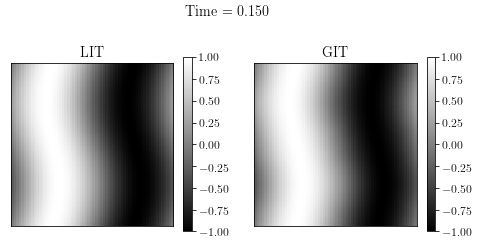

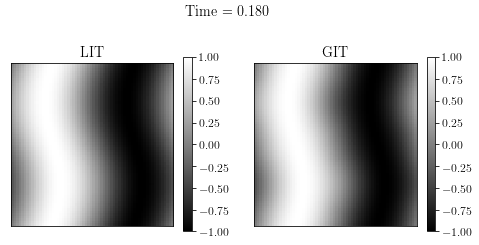

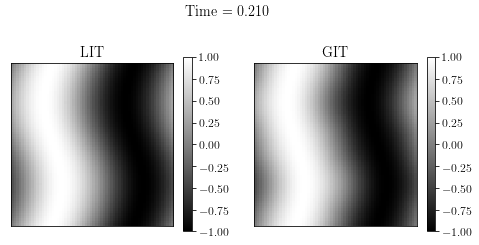

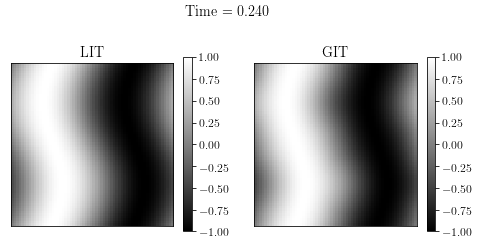

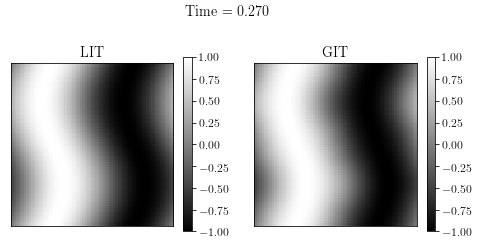

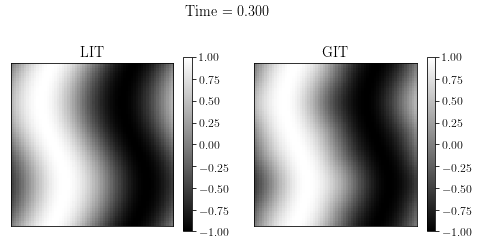

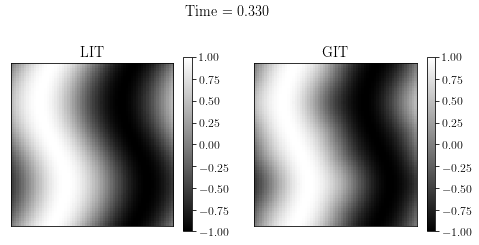

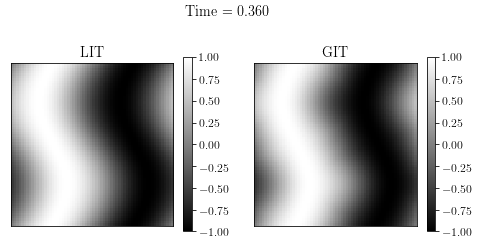

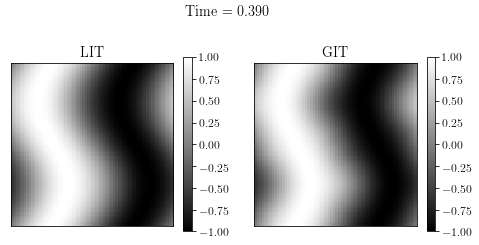

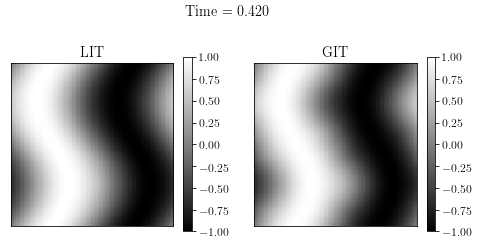

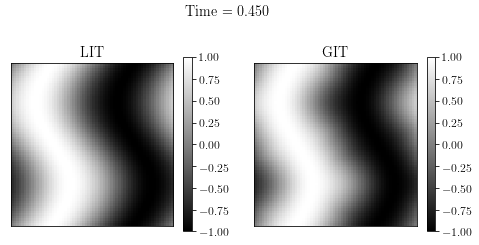

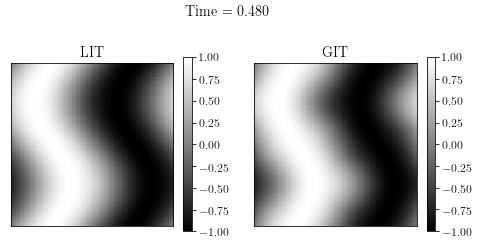

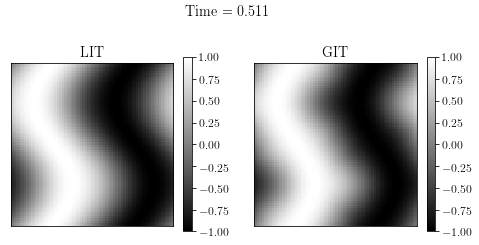

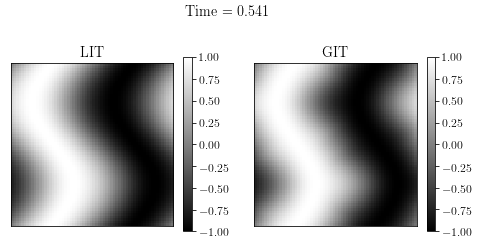

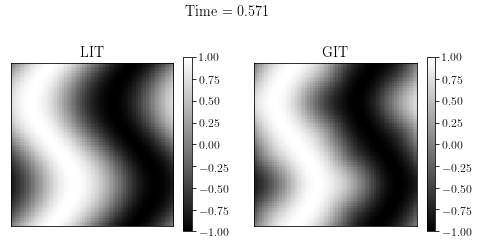

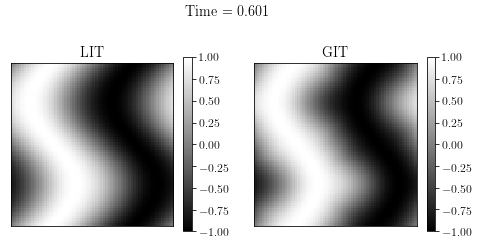

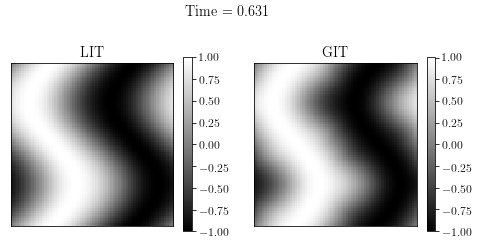

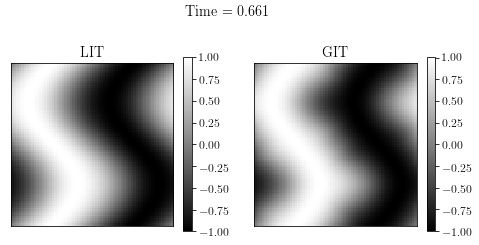

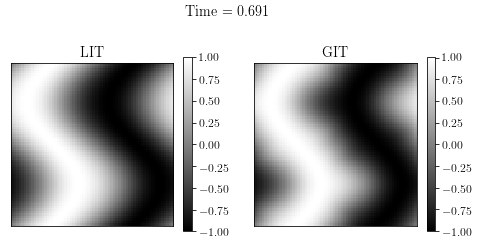

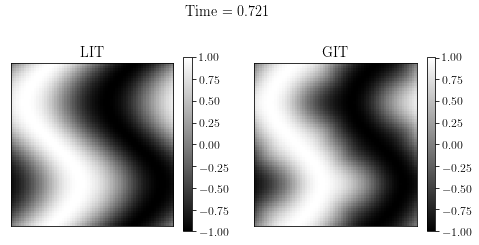

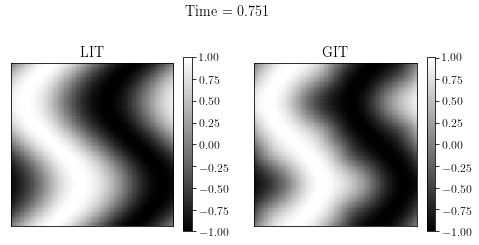

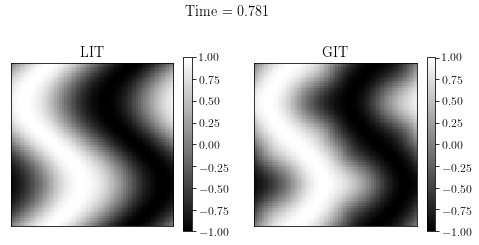

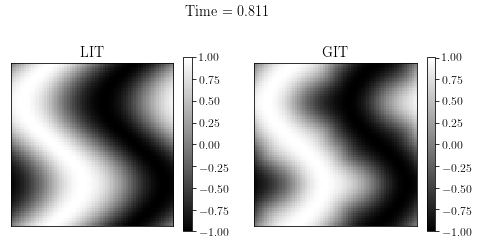

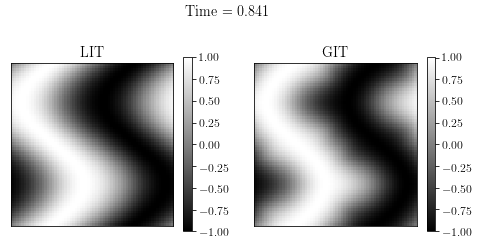

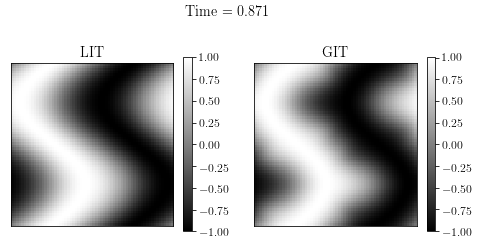

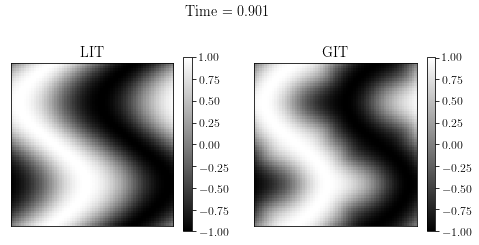

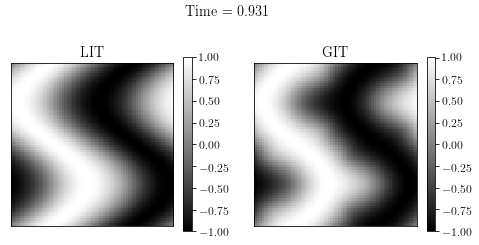

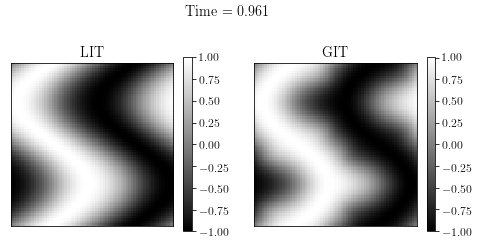

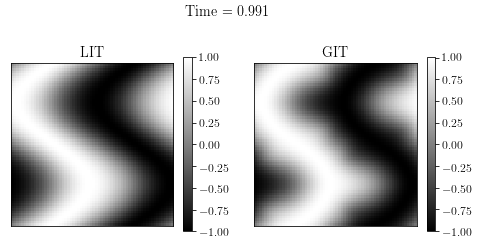

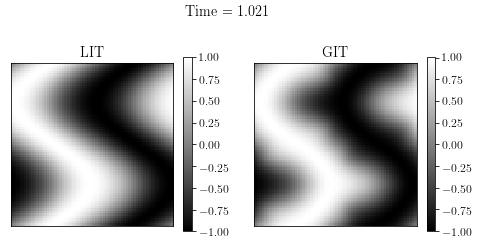

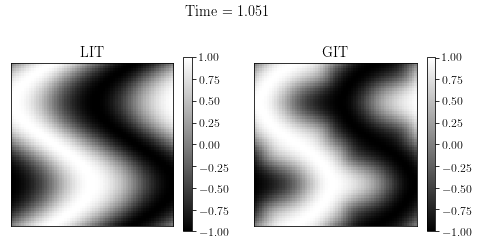

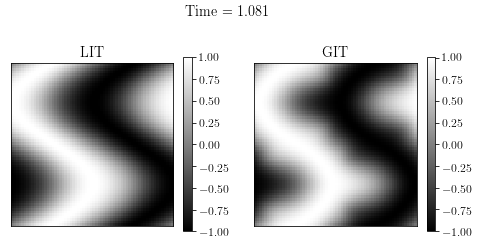

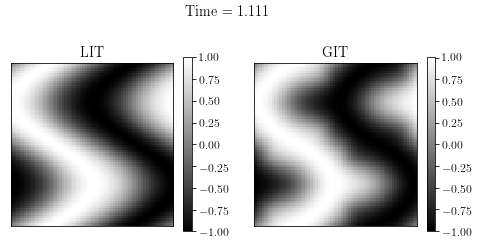

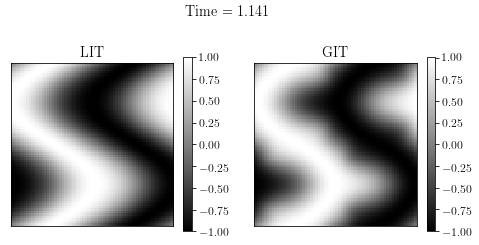

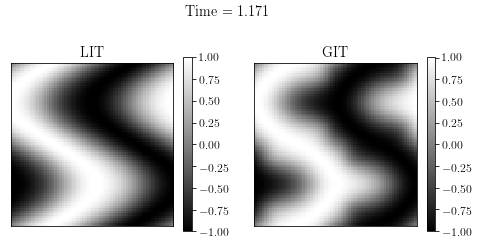

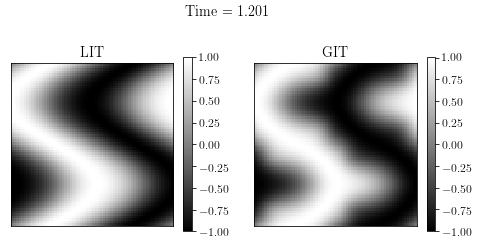

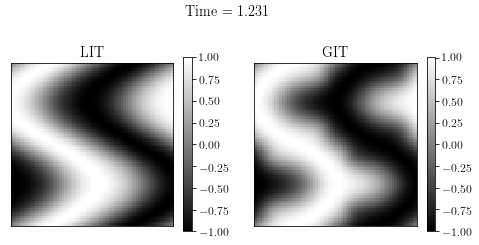

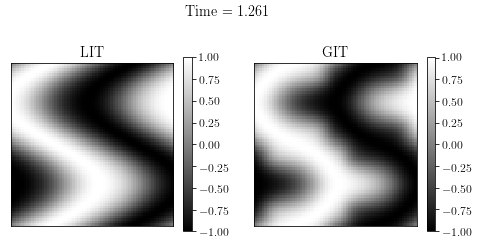

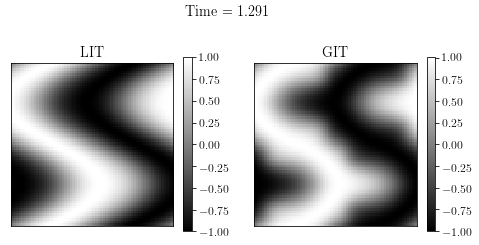

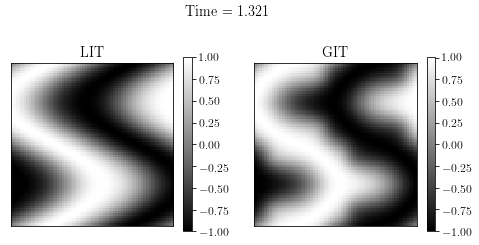

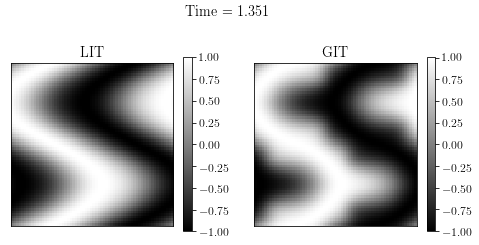

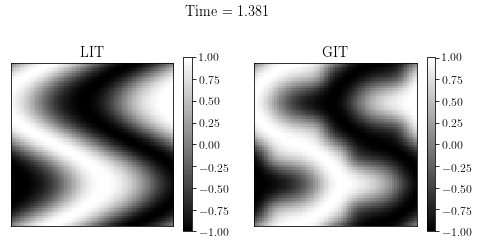

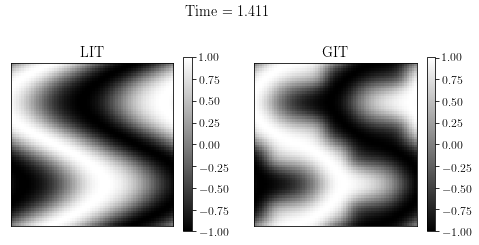

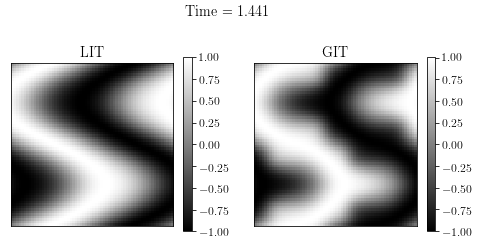

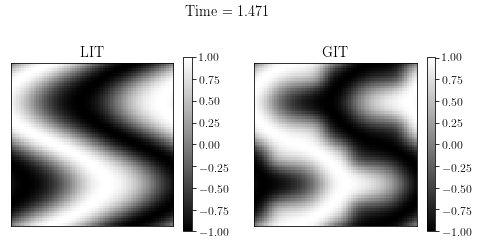

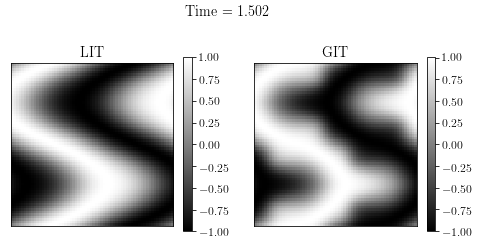

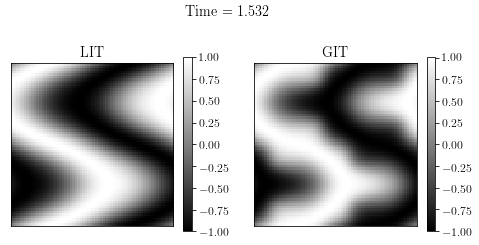

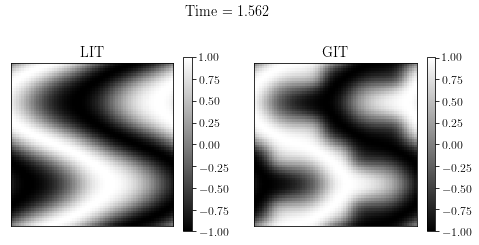

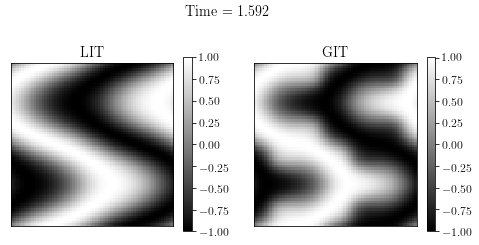

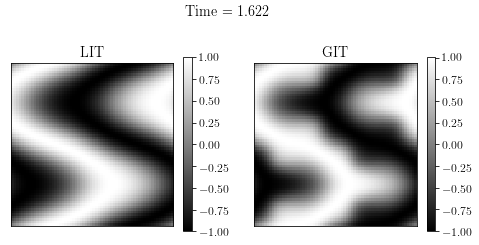

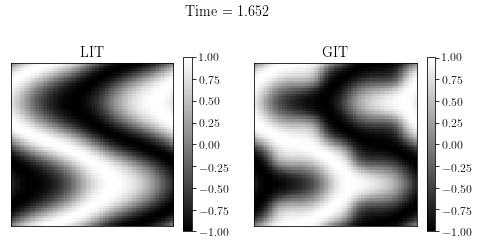

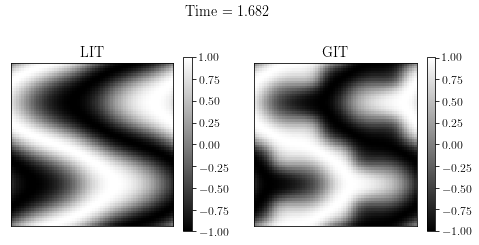

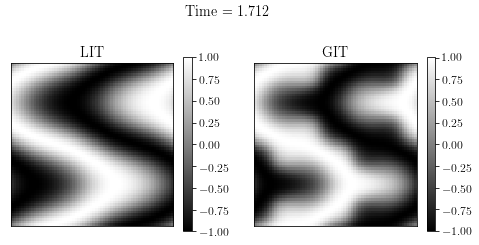

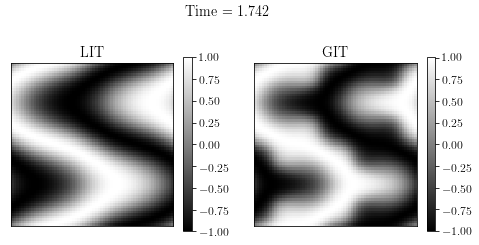

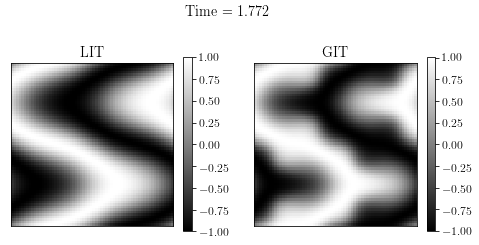

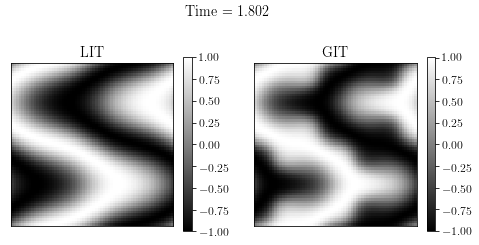

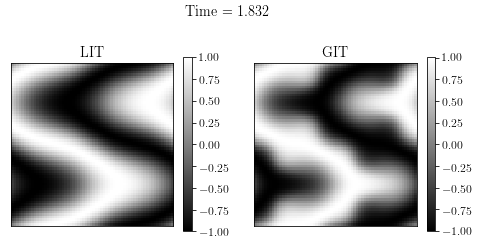

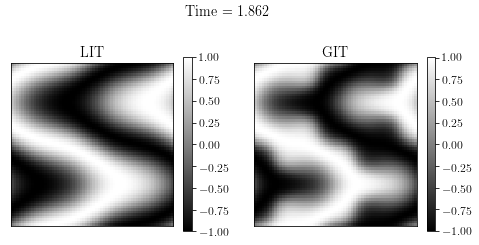

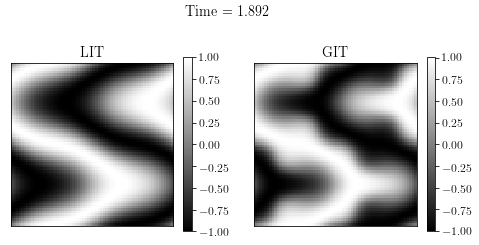

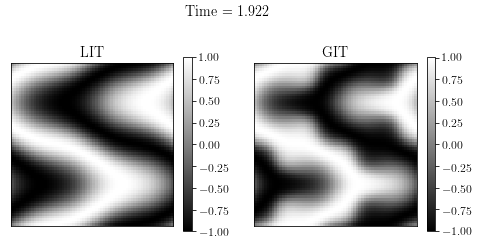

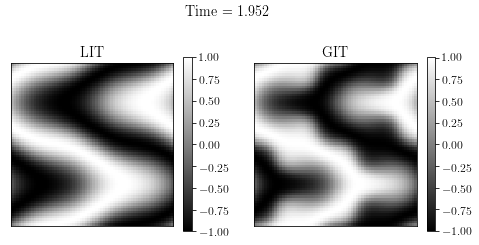

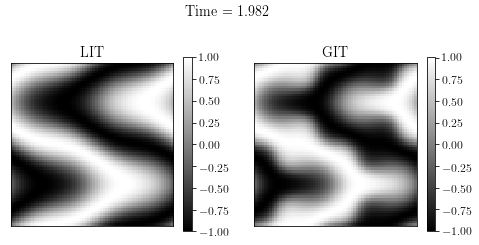

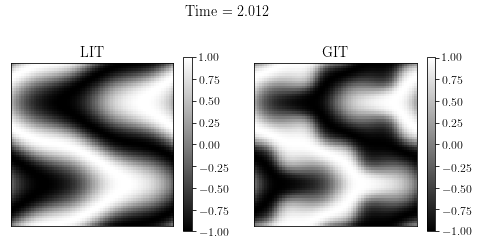

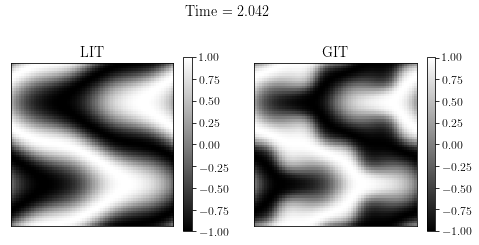

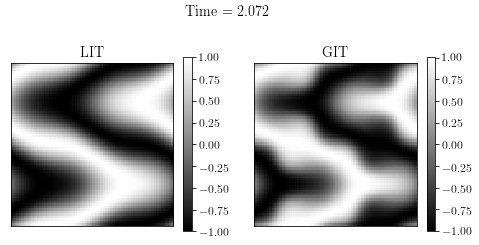

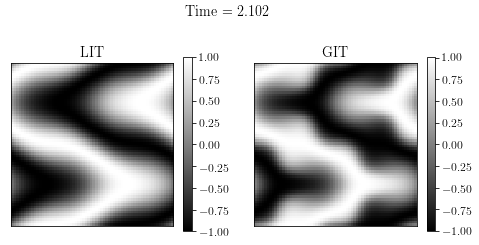

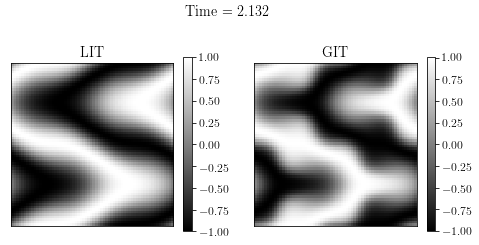

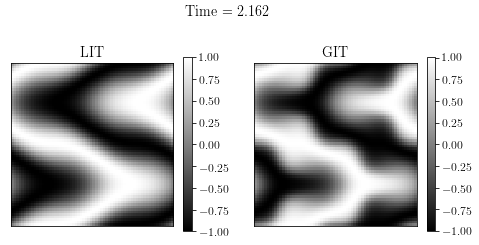

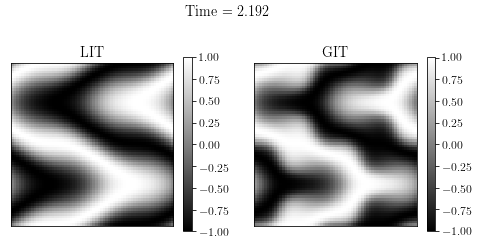

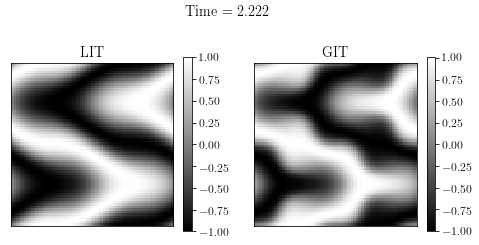

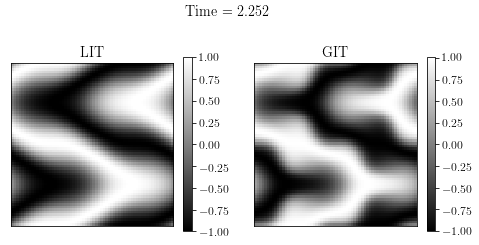

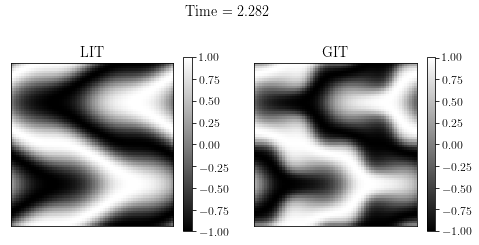

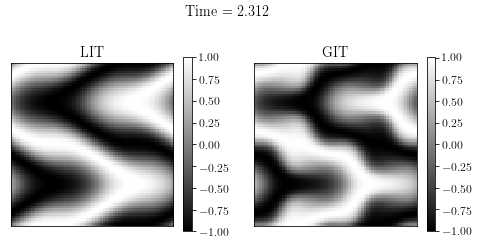

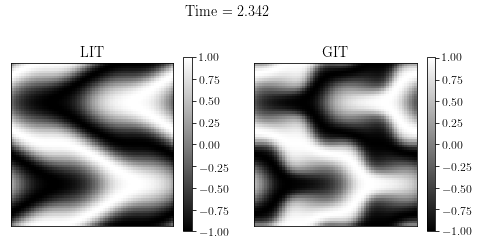

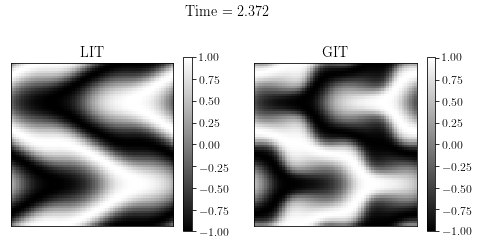

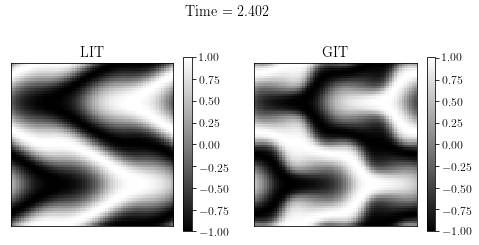

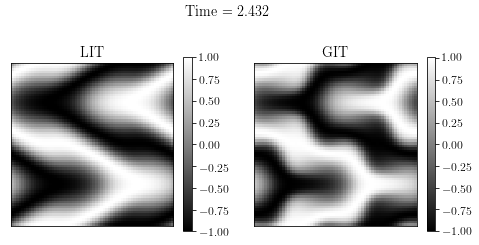

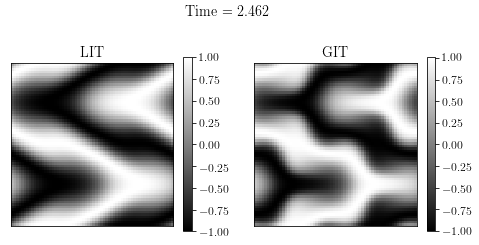

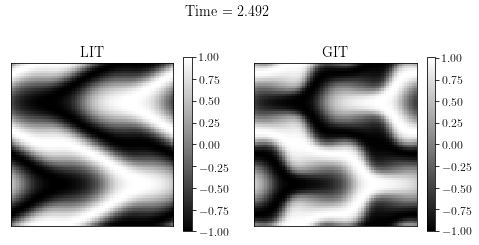

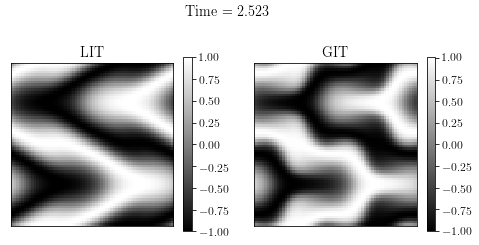

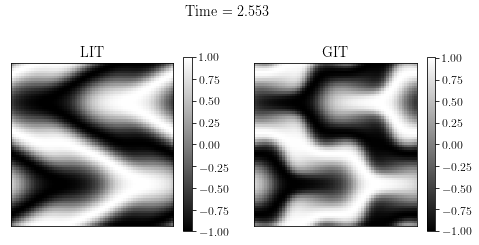

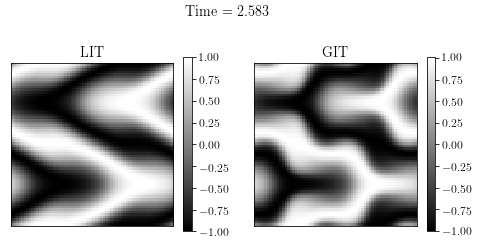

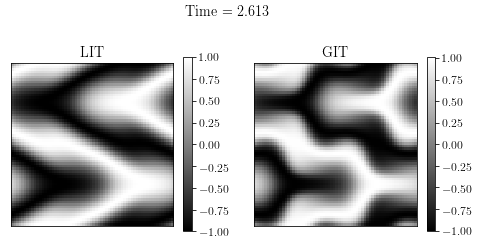

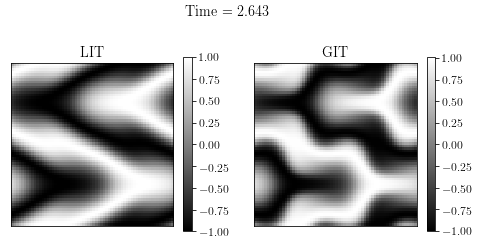

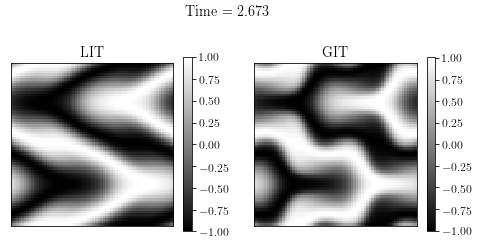

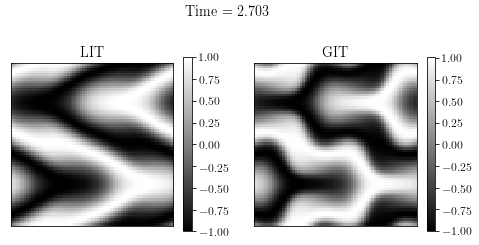

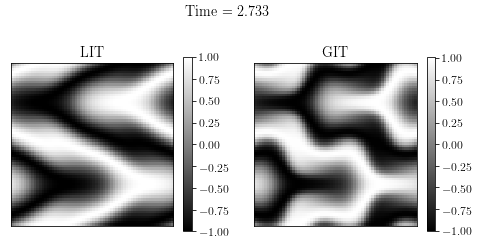

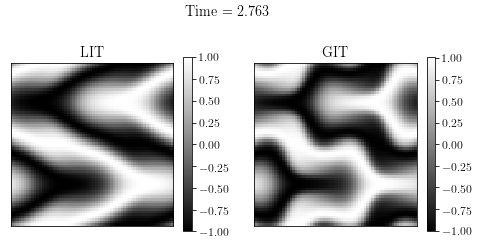

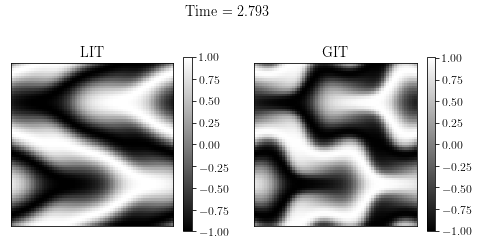

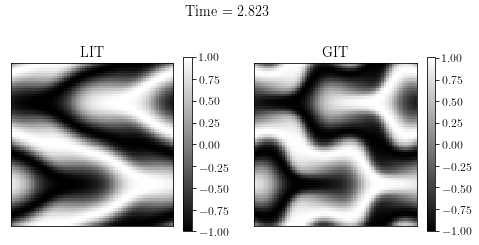

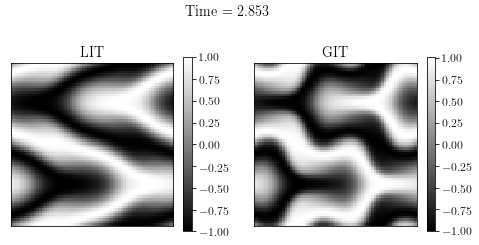

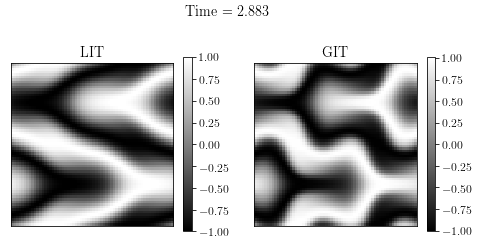

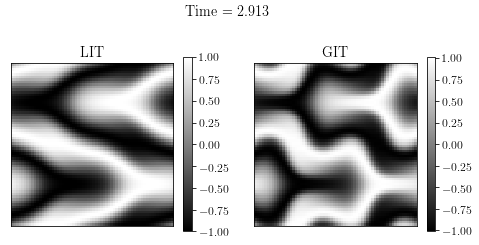

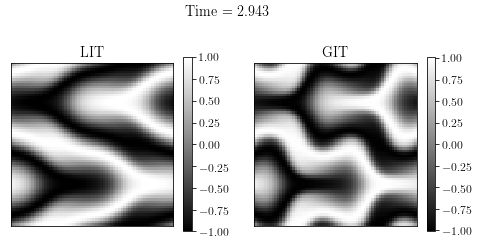

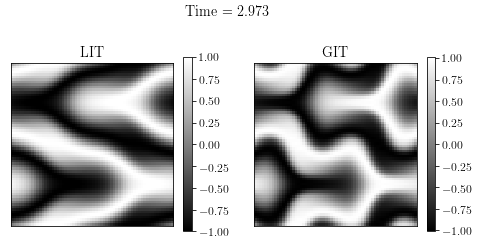

0

In [14]:
i = 2


skip_every = 10

time_1 = time_array[::skip_every]
time_2 = time_array[::skip_every]

L=1.0
shrink = 0.8
cmap=plt.cm.gray
output_path = 'output_lit_vs_git/'
scalar_hist_1= th_lit[::skip_every]
scalar_hist_2= th_git[::skip_every]




os.system('mkdir ' + output_path)

os.system('mkdir ' + output_path + 'images/')

for k in range(len(time_1)):
    

    fig, axes = plt.subplots(figsize = (8, 4), nrows=1, ncols=2)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)

    im = axes[0].imshow(np.transpose(scalar_hist_1[k]),
                    cmap=cmap,
                    extent=(0, L, 0, L),
                    origin="lower",
                       vmin=-1,vmax=1)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title('LIT')
    fig.colorbar(im, ax=axes[0], shrink = shrink)

    im = axes[1].imshow(np.transpose(scalar_hist_2[k]),
                    cmap=cmap,
                    extent=(0, L, 0, L),
                    origin="lower")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title('GIT')

    fig.colorbar(im, ax=axes[1], shrink = shrink)

    plt.suptitle('Time = %.3f' % time_1[k])


    plt.savefig(output_path + 'images/' + "image%.4d.png" %
               k, format='png',dpi = 300)
    plt.show()
    plt.close(fig)

os.system("ffmpeg -y -framerate 20 -i " + output_path + 'images/'
      "image%04d.png -c:v libx264 -pix_fmt yuv420p " + output_path + "movies.mp4")


In [15]:

os.system("ffmpeg -y -framerate 30 -i " + output_path + 'images/'
      "image%04d.png -c:v libx264 -pix_fmt yuv420p " + output_path + "movies.mp4")


0